<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
1- فراخوان توابع مورد نیاز
</b>
</div>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import gaussian_kde
#working_dir = os.getcwd()
working_dir ='..'  # Use on Jupyter Notebook

<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
2- خواندن دیتاهای خام مربوط به کک 1030 
</b>
</div>

In [2]:
df = pd.read_csv(f"{working_dir}/Raw-Data/coke_1030_Lab.csv",encoding='latin-1' )
print(f"size of raw data = {df.shape}")
#remove rejected materials
df = df.astype({'time_1':str})
df['time_1'] = df['time_1'].str.lower()
mask = df['time_1'] != 'reject'
df = df[mask]
print(f"after removing rejected goods = {df.shape}")
# Drop Some Columns
df.drop(labels=['trailer','time_1','location','sample_no','factory','humidity','s112_315'],axis=1,inplace=True)
#Filter Tarikh
df = df[df['tar'] >= 14020915]
#change type of tarikh column for grouping
df = df.astype({'tar': str})
print(f"from 14020915 to 14030915 = {df.shape}")
#group tarikh by Average of other columns
df = df.groupby('tar', as_index=False).mean().round(2)
df.reset_index(inplace=True ,drop=True)
print(f"After Grouping By Tarikh = {df.shape}")
print(df.describe())
#drop column ash because all time is 0.0
df.drop(labels=['ash'],axis=1,inplace=True)
#save prepared data for next
df.to_csv(f"{working_dir}/data/coke_1030.csv",index=False)
#remove dataframe from memory
del df

size of raw data = (1890, 13)
after removing rejected goods = (1872, 13)
from 14020915 to 14030915 = (683, 6)
After Grouping By Tarikh = (157, 6)
                c           s    ash        s112        s315
count  157.000000  157.000000  157.0  157.000000  157.000000
mean    81.690318    1.220127    0.0    2.142166    1.680573
std      1.193550    0.230451    0.0    0.960875    4.596496
min     80.000000    0.630000    0.0    0.000000    0.000000
25%     80.700000    1.000000    0.0    1.500000    0.500000
50%     81.500000    1.300000    0.0    2.000000    1.000000
75%     82.450000    1.400000    0.0    2.710000    2.000000
max     84.900000    1.500000    0.0    5.000000   57.000000


<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
1-2 - خوشه بندی داده 
</b>
</div>

(157, 4)
(157, 4)
Empty DataFrame
Columns: []
Index: []
(157, 2)
(157,)


/tmp/ipykernel_1519/1180391286.py:34: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


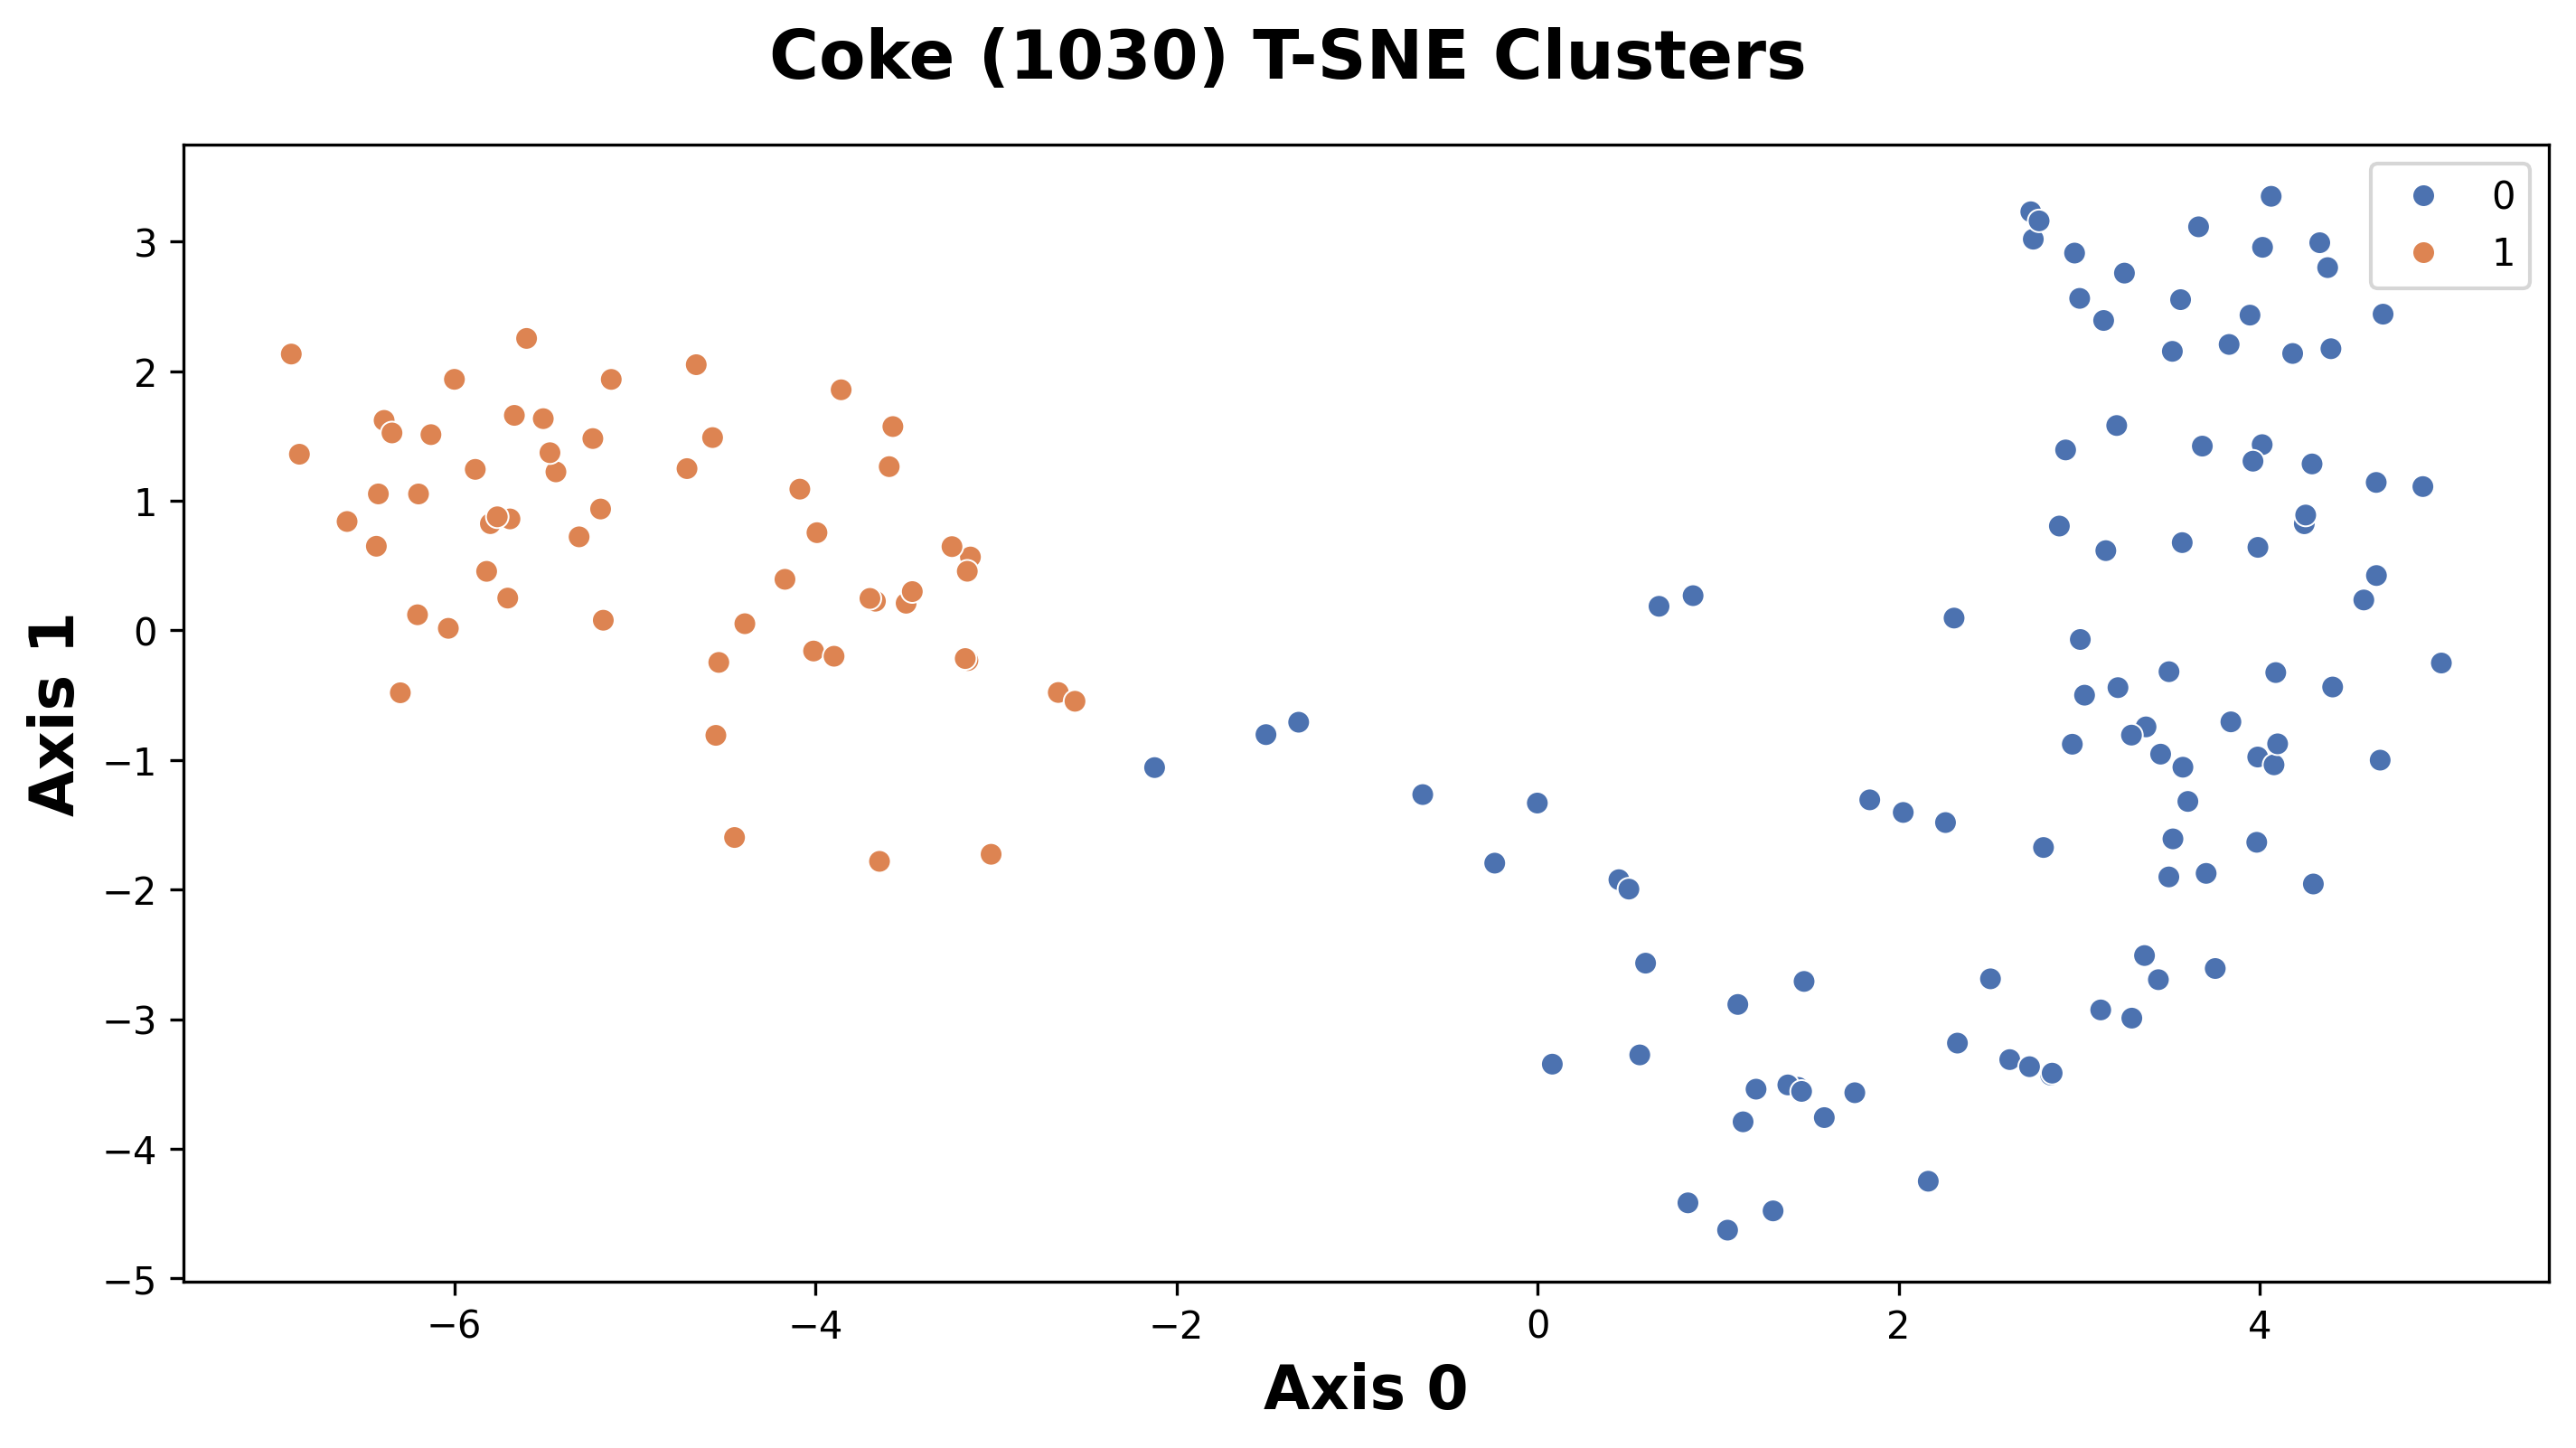

(157, 4)
Index(['c', 's', 's112'], dtype='object')


/tmp/ipykernel_1519/1180391286.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/1180391286.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/1180391286.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(


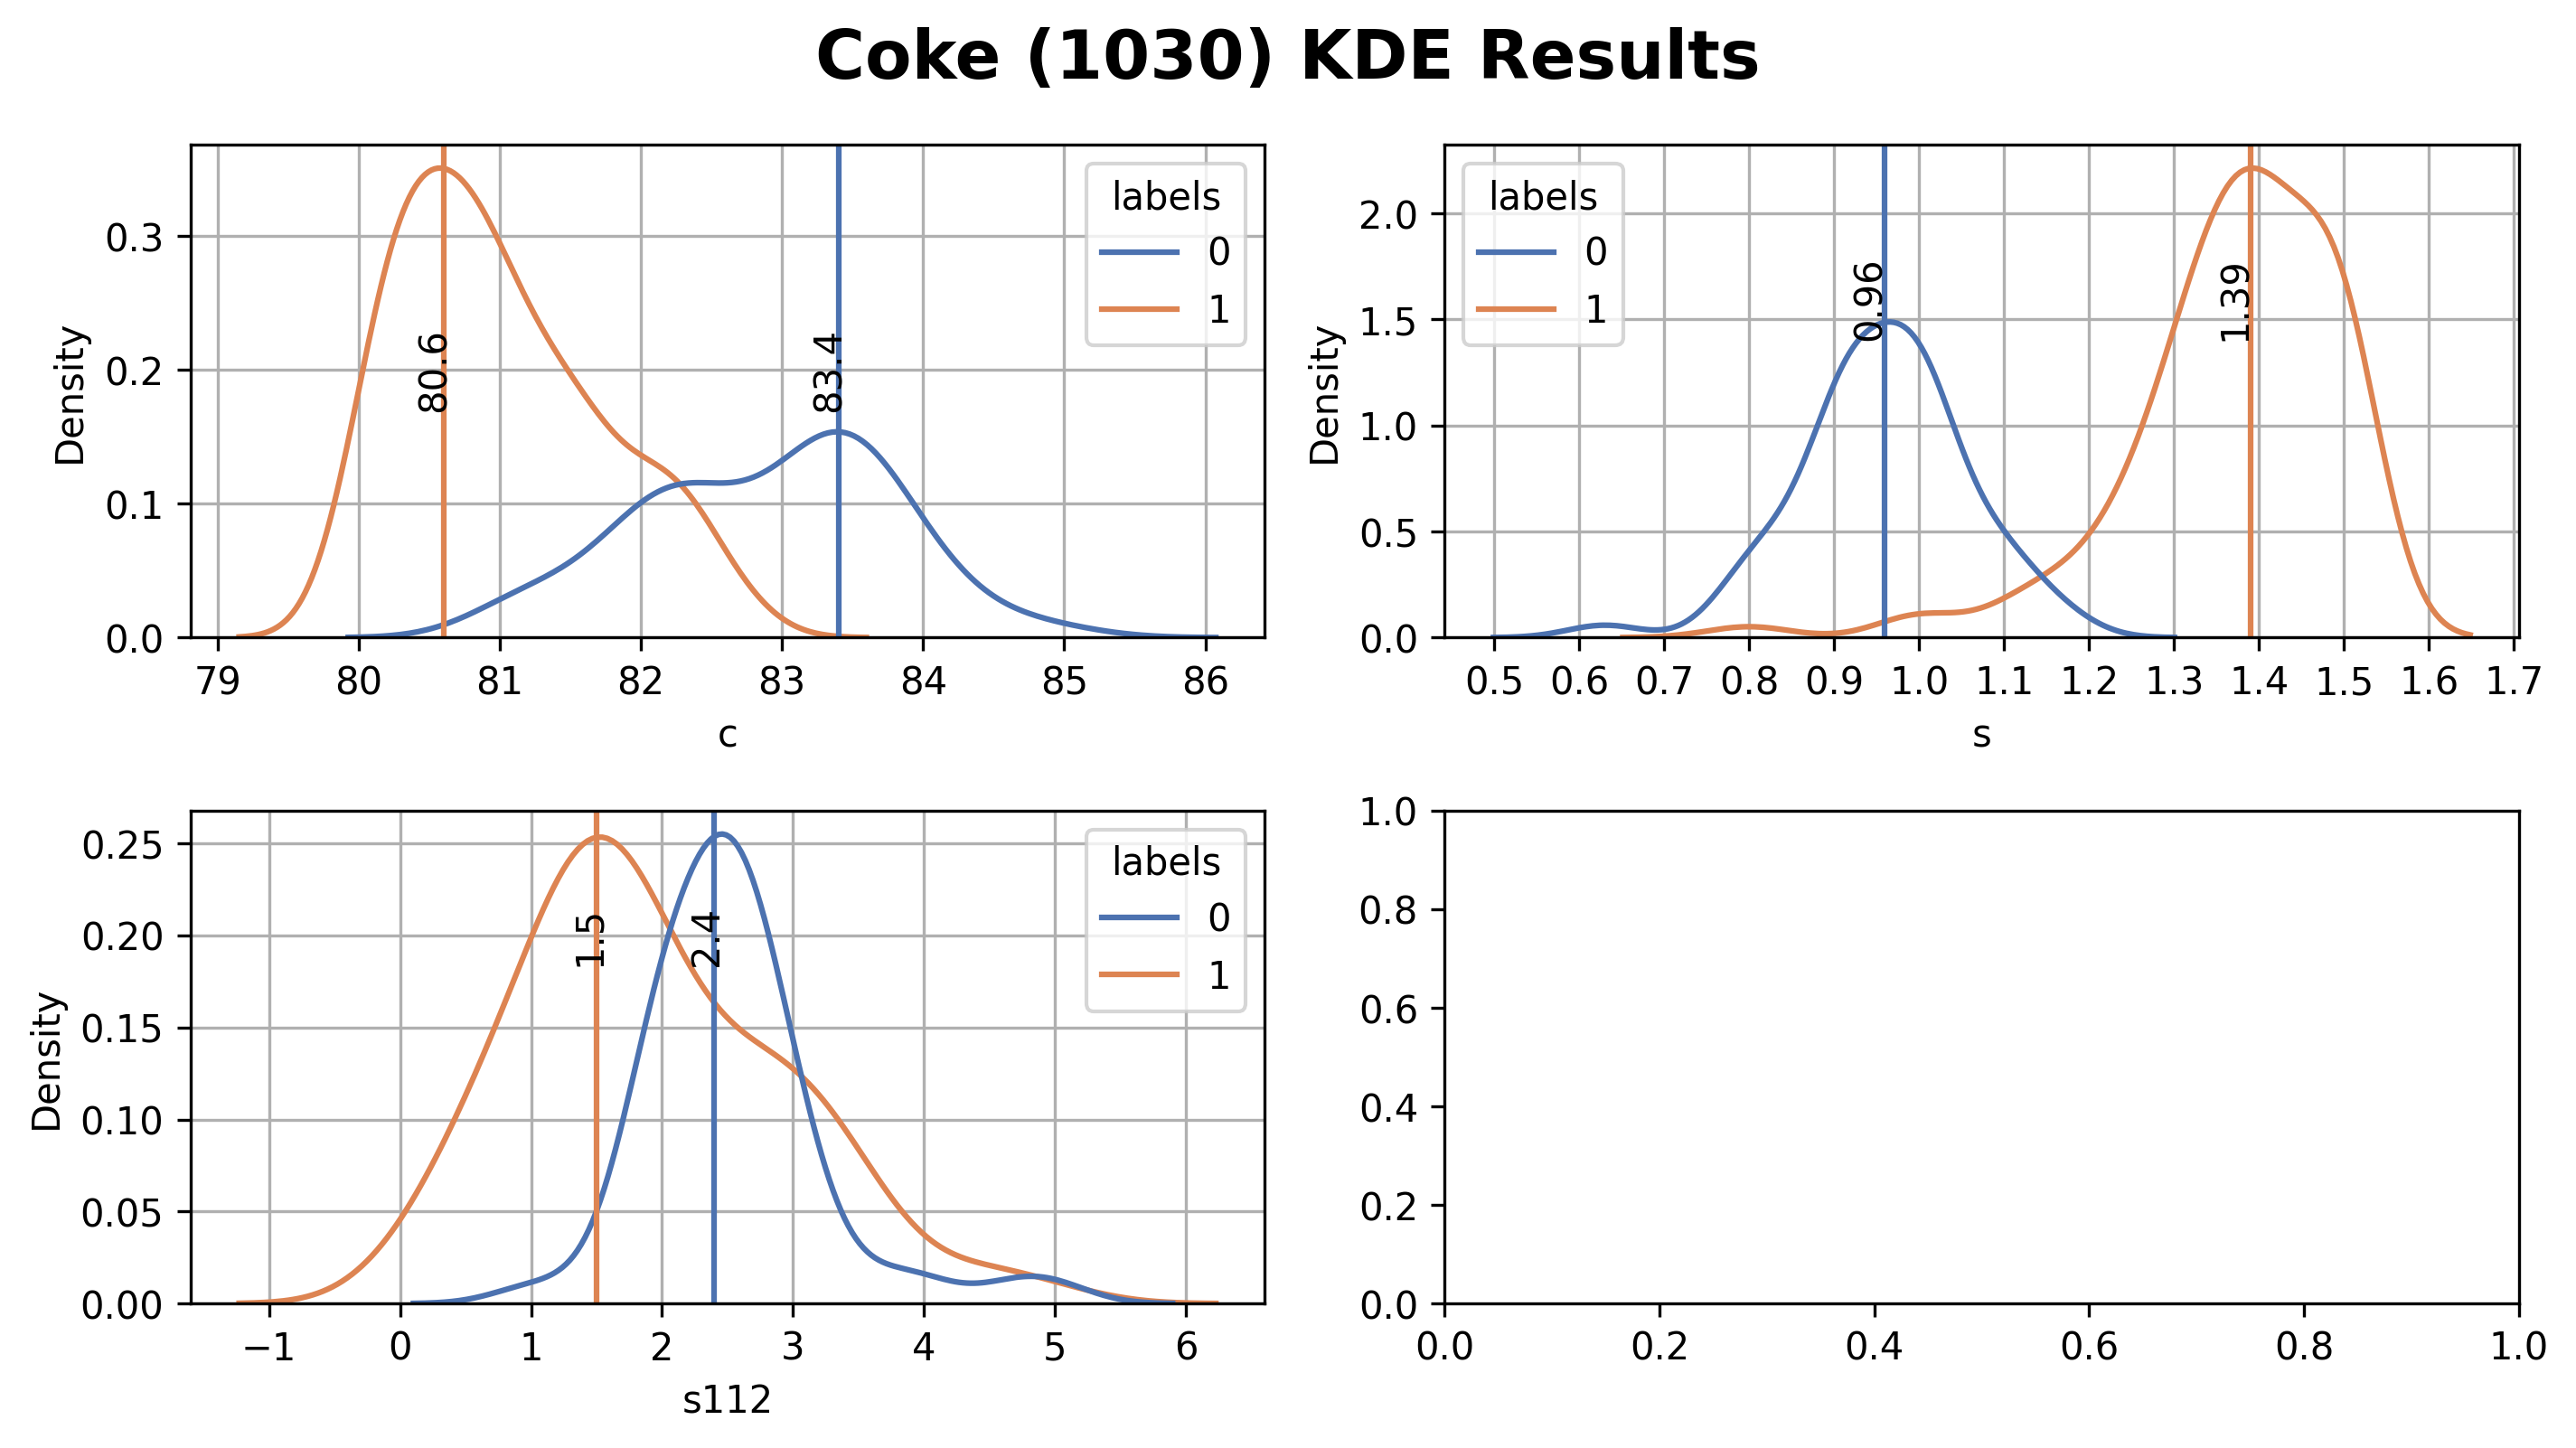

In [3]:
df = pd.read_csv(f"{working_dir}/data/coke_1030.csv")
df.set_index(keys='tar', inplace=True ,drop=True)
print(df.shape)
#--------Normalizing-------- 
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
print(normal_df.shape)
#--------Correlation--------
corr_df = normal_df.corr().abs()
corr_df = corr_df.where(np.triu(np.ones(corr_df.shape),k= 1).astype(bool)) #paiine matice motegharen ast ve hazf shod
high_corr_columns_name = pd.DataFrame(corr_df.ge(.95).stack().loc[lambda corr_df: corr_df].index.to_list())
print(high_corr_columns_name)
df.drop(labels=['s315'] ,axis=1,inplace=True)
#-------Clustering---------
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
t_sne = TSNE(n_components=2, learning_rate='auto',random_state=0,
                  init='random', perplexity=50)
data=t_sne.fit_transform(normal_df)
sne_column_name = [f"SNE{column}"  for column in range(2) ]
sne_df = pd.DataFrame(data=data,columns=sne_column_name)
print(sne_df.shape)
model = AgglomerativeClustering(n_clusters = 2, metric= 'euclidean', linkage ='average')
model.fit(sne_df)
print(model.labels_.shape)
# ---------PLOT-------------
fig = plt.figure(figsize=(9.6,5.4),dpi=300)
fig.suptitle('Coke (1030) T-SNE Clusters', fontsize=18,fontweight='bold')
ax1 = fig.subplots(1,1)
ax1.set_xlabel('Axis 0', fontsize=16,fontweight='bold')
ax1.set_ylabel('Axis 1', fontsize=16,fontweight='bold')
#ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
cmap = sns.color_palette("deep", as_cmap=True)
sns.scatterplot(
    data=sne_df,
    x='SNE0',
    y='SNE1',
    hue=model.labels_,
    palette= cmap,
    )
fig.tight_layout()
plt.savefig(f'{working_dir}/presentation/coke-1030-tsne-clusters.jpg')
plt.show()
#----------Labeling---------
clust_lable_dict = {0:1,1:0}
labels = [clust_lable_dict[i] for i in model.labels_]
df["labels"] = labels
print(df.shape)
#----------Labes Conditions-----
plot_name = df.columns.drop('labels')
print(plot_name)
num = 0
for k in range(1):
    fig = plt.figure(num=k,figsize=(9.6,5.4),dpi=300)
    fig.suptitle('Coke (1030) KDE Results', fontsize=18,fontweight='bold')
    ax = fig.subplots(2,2)
    #sns.set_style("ticks",{'axes.grid' : True})
    for i in range(2):
        for j in range(2):
            if num == len(plot_name):
                break
            ax[i][j].grid(True)
            sns.kdeplot(
                data=df,
                x=plot_name[num],
                hue="labels",
                #hue_order=[0,2,3,],
                fill=False,
                #alpha = 0.4,
                palette= cmap,
                ax=ax[i][j],
            )
            num = num +1
    fig.tight_layout()
ax[0][0].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[0][0].axvline(83.4,color=cmap[0])
ax[0][0].text(83.2, 0.2, '83.4', rotation=90, va='center')
ax[0][0].axvline(80.6,color=cmap[1])
ax[0][0].text(80.4, 0.2, '80.6', rotation=90, va='center')
ax[0][1].xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax[0][1].axvline(0.96,color=cmap[0])
ax[0][1].text(0.92, 1.6, '0.96', rotation=90, va='center')
ax[0][1].axvline(1.39,color=cmap[1])
ax[0][1].text(1.35, 1.6, '1.39', rotation=90, va='center')
ax[1][0].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[1][0].axvline(2.4,color=cmap[0])
ax[1][0].text(2.2, 0.2, '2.4', rotation=90, va='center')
ax[1][0].axvline(1.5,color=cmap[1])
ax[1][0].text(1.3, 0.2, '1.5', rotation=90, va='center')
plt.savefig(f'{working_dir}/presentation/coke-1030-kde-results.jpg')
plt.show()
# save For next use
df.to_csv(f"{working_dir}/data/coke_1030_with_labels.csv",index=True)
del df,normal_df,corr_df,high_corr_columns_name

<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
3- خواندن دیتاهای خام مربوط به کک فاین 
</b>
</div>

In [4]:
df = pd.read_csv(f"{working_dir}/Raw-Data/coke_Fine_Lab.csv",encoding='latin-1' )
print(f"size of raw data = {df.shape}")
#remove rejected materials
df = df.astype({'time_1':str})
df['time_1'] = df['time_1'].str.lower()
mask = df['time_1'] != 'reject'
df = df[mask]
print(f"after removing rejected goods = {df.shape}")
# Drop Some Columns
df.drop(labels=['sampling_d','trailer','time_1','location','sample_no','factory'],axis=1,inplace=True)
#Filter Tarikh
df = df[df['tar'] >= 14020915]
#change type of tarikh column for grouping
df = df.astype({'tar': str})
print(f"from 14020915 to 14030915 = {df.shape}")
#group tarikh by Average of other columns
df = df.groupby('tar', as_index=False).mean().round(2)
df.reset_index(inplace=True ,drop=True)
print(f"After Grouping By Tarikh  = {df.shape}")
print(df.describe())
#drop column ash because all time is 0.0
df.drop(labels=['ash'],axis=1,inplace=True)
#save prepared data for next
df.to_csv(f"{working_dir}/data/coke_fine.csv",index=False)
#remove dataframe from memory
del df

size of raw data = (3796, 14)
after removing rejected goods = (3778, 14)
from 14020915 to 14030915 = (1118, 8)
After Grouping By Tarikh  = (181, 8)
                c           s    humidity    ash         s05     s05_335  \
count  181.000000  181.000000  181.000000  181.0  181.000000  181.000000   
mean    84.339945    1.084972    0.096354    0.0    2.292376   96.540055   
std      5.881336    0.300516    0.545765    0.0    0.844233    1.582831   
min     75.470000    0.210000    0.000000    0.0    0.000000   91.500000   
25%     80.670000    0.920000    0.000000    0.0    2.000000   96.500000   
50%     82.030000    1.100000    0.000000    0.0    2.000000   97.000000   
75%     84.440000    1.320000    0.000000    0.0    2.500000   97.000000   
max     98.690000    1.830000    5.300000    0.0    5.330000   99.000000   

             s335  
count  181.000000  
mean     1.167348  
std      1.036174  
min      0.000000  
25%      0.800000  
50%      1.000000  
75%      1.000000  
max    

<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
1-3 - خوشه بندی داده 
</b>
</div>

(181, 6)
(181, 6)
Empty DataFrame
Columns: []
Index: []
(181, 2)
(181,)


/tmp/ipykernel_1519/2290828258.py:34: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


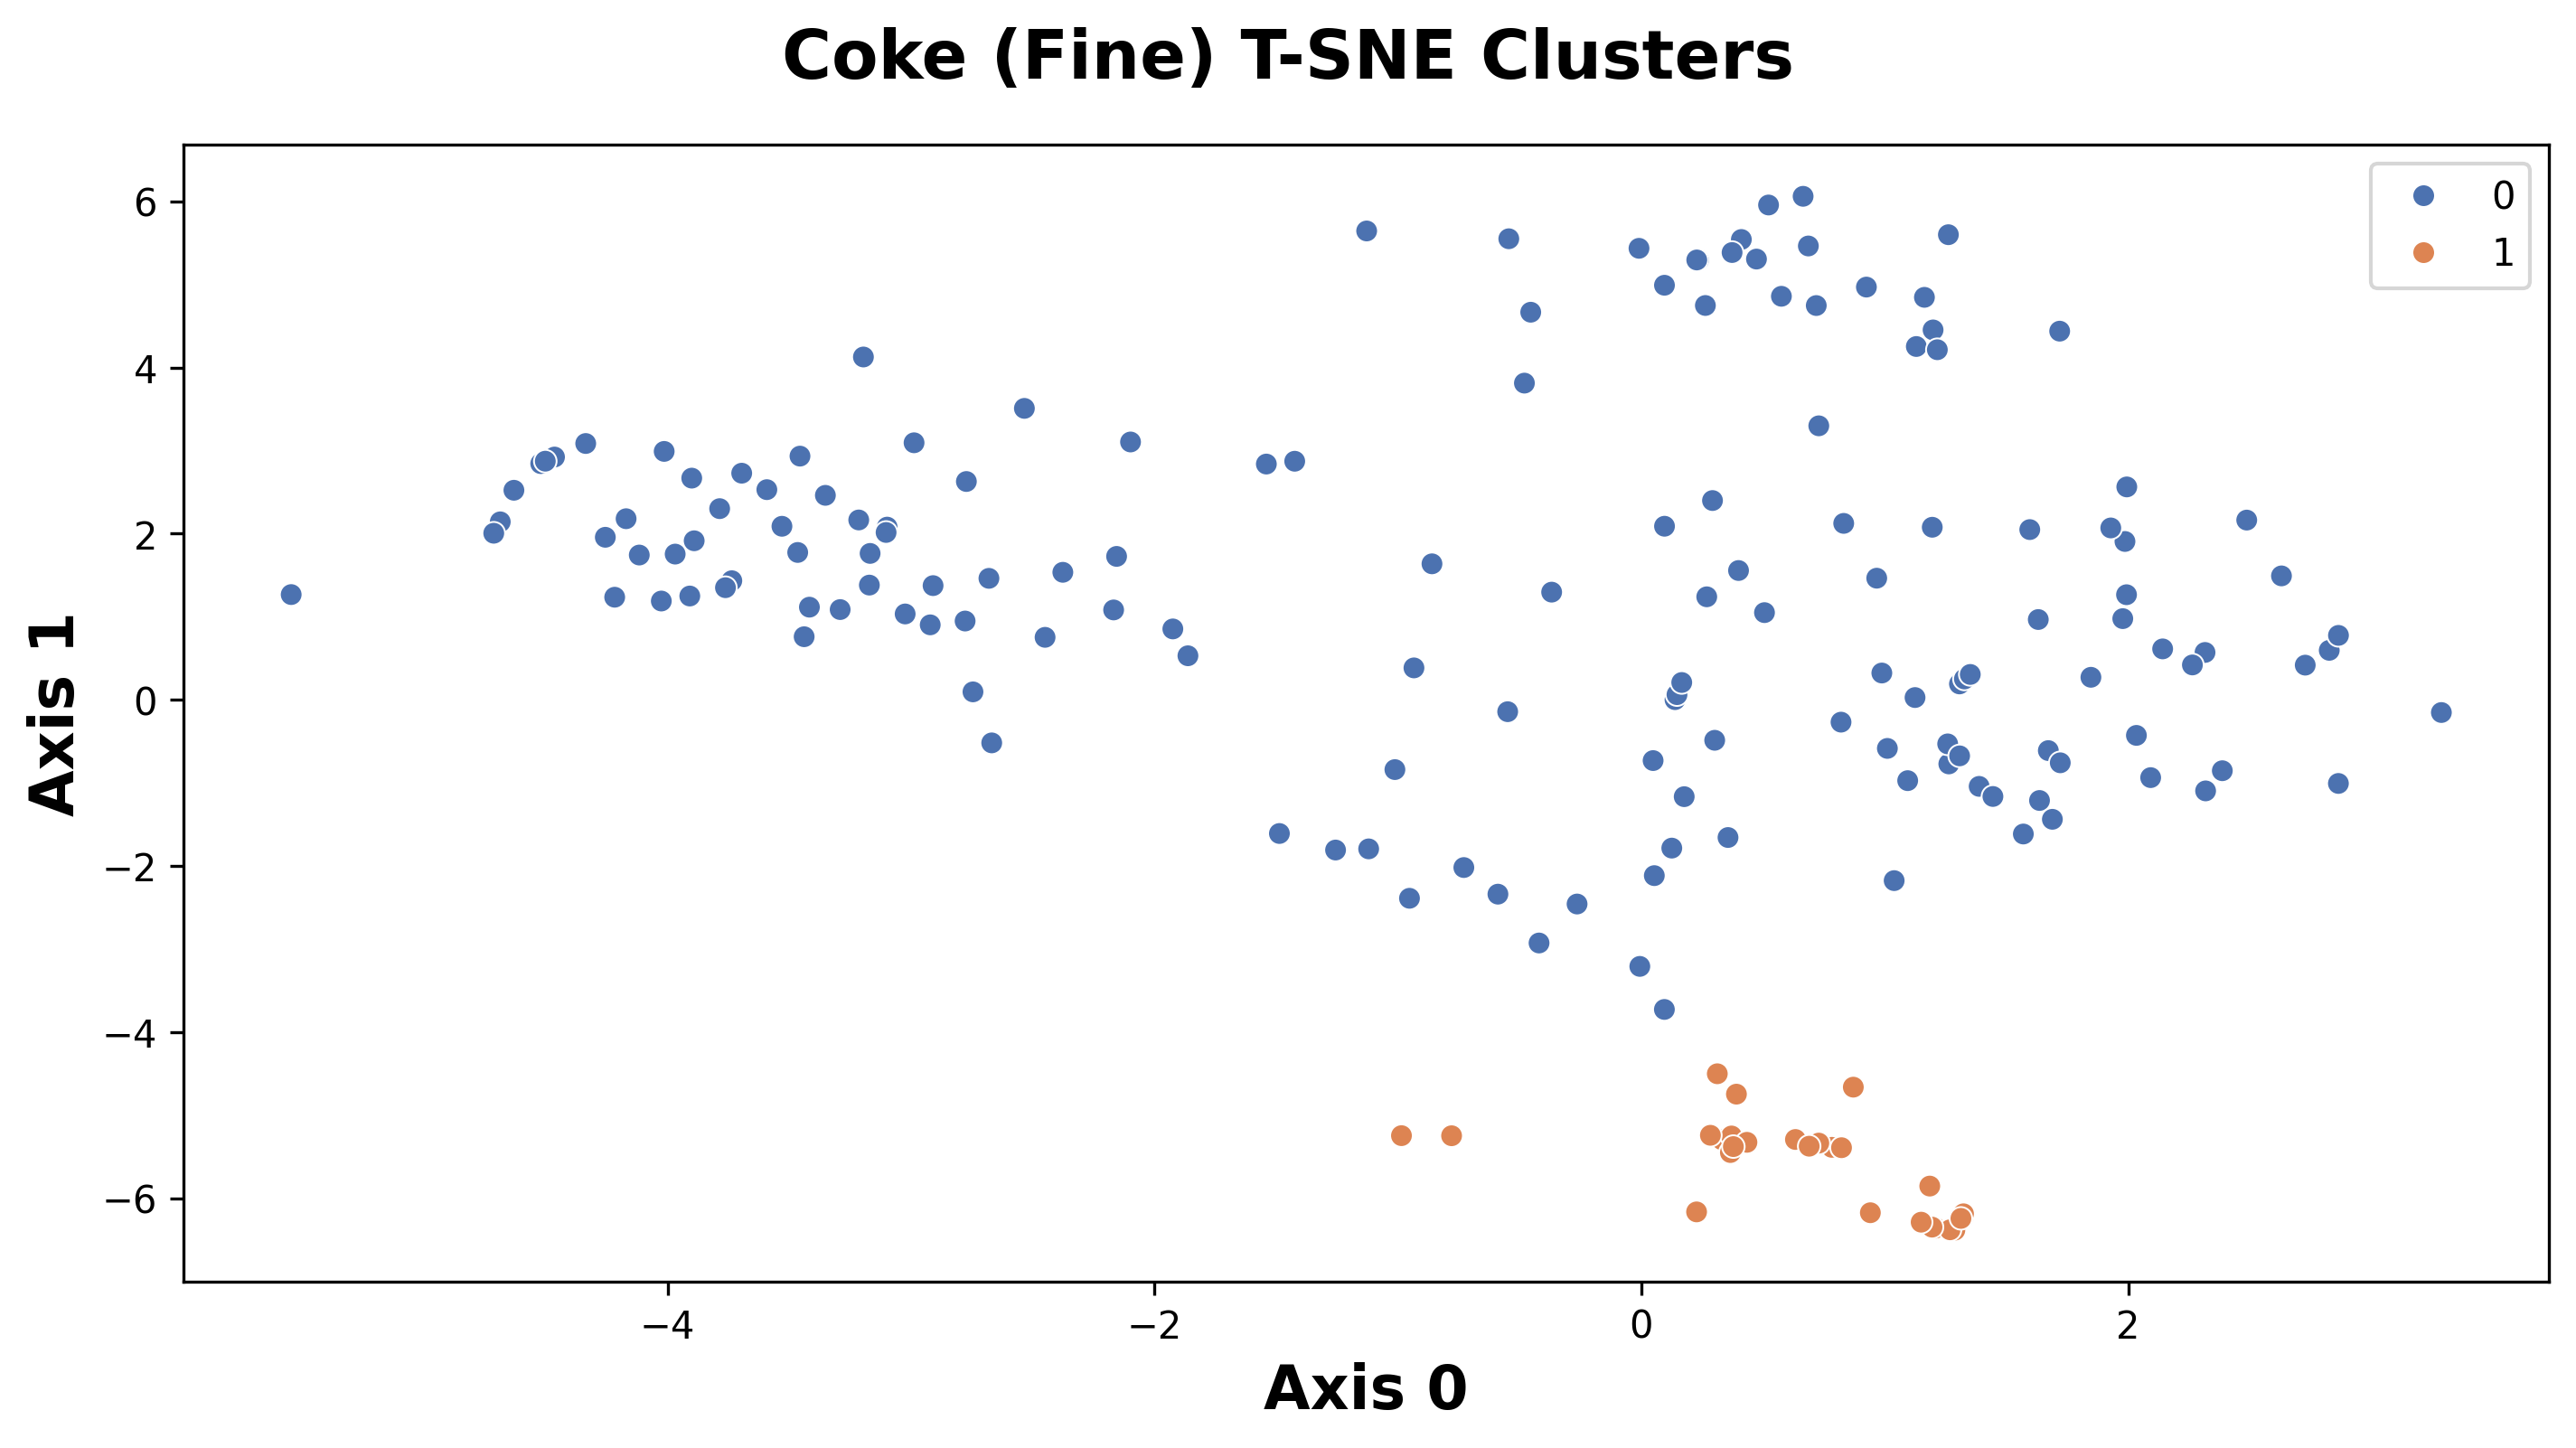

(181, 4)
Index(['c', 's', 's05'], dtype='object')
[<Axes: > <Axes: > <Axes: >]


/tmp/ipykernel_1519/2290828258.py:64: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/2290828258.py:64: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/2290828258.py:64: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(


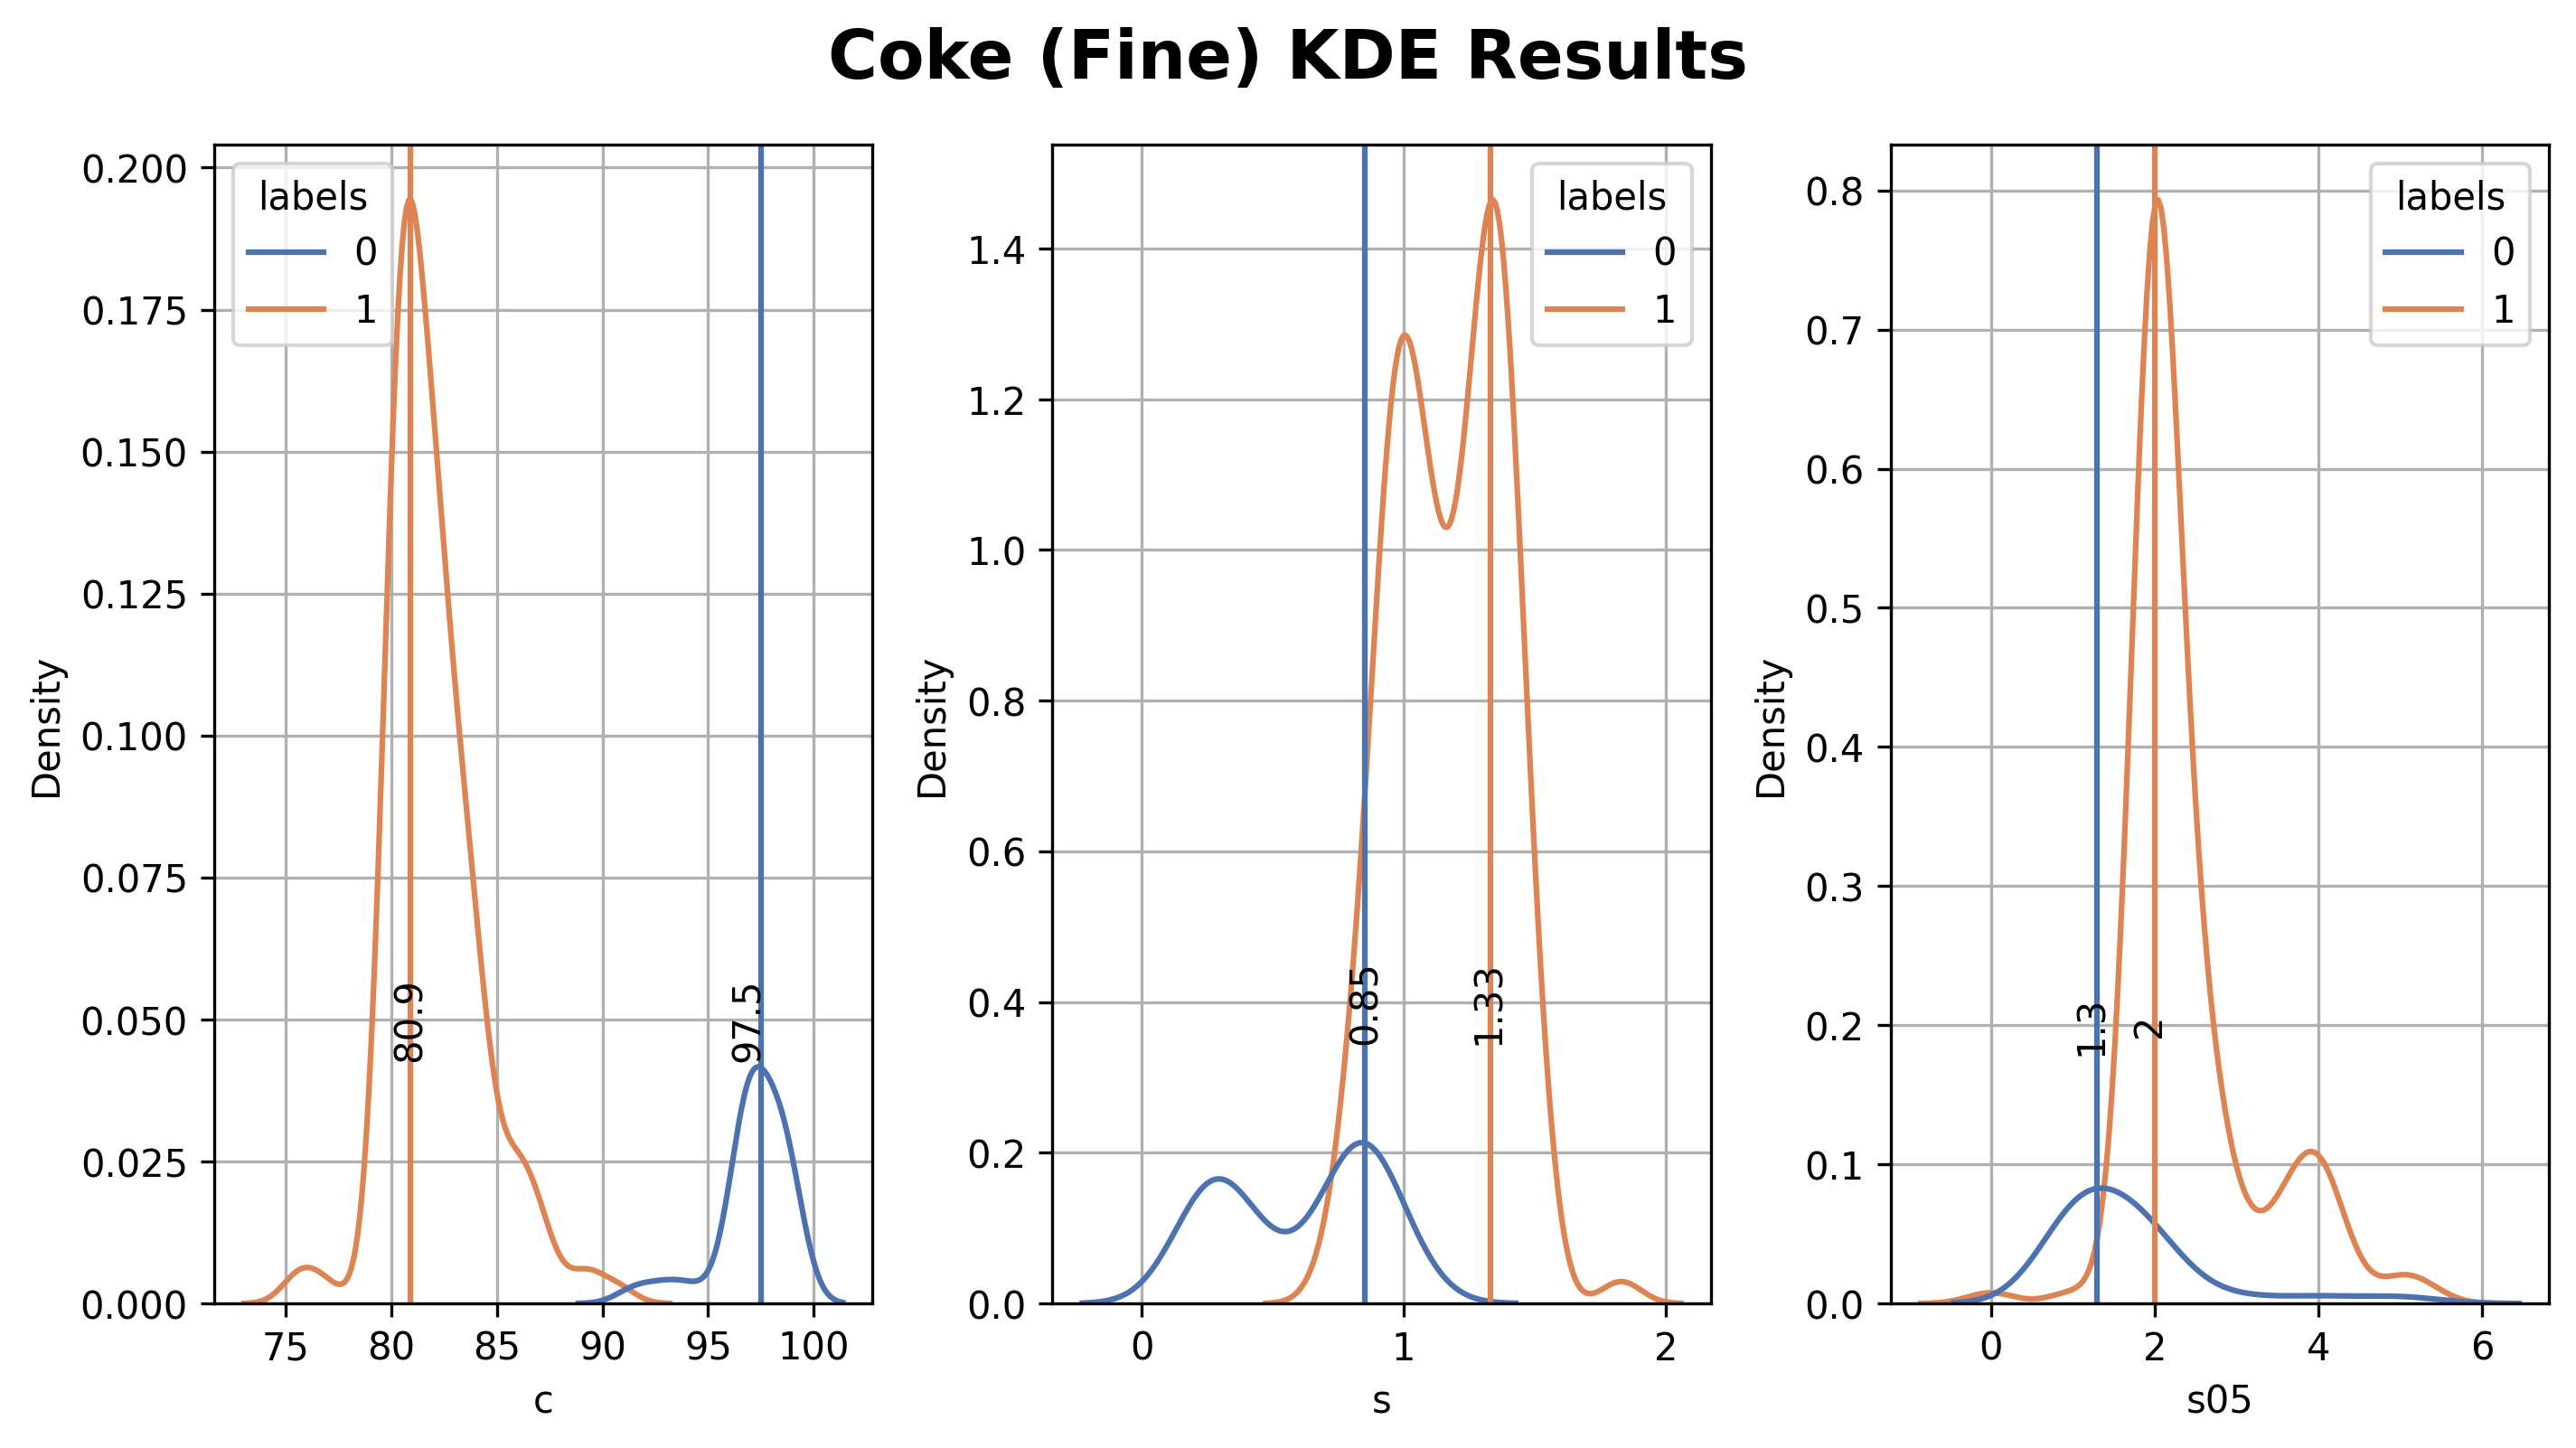

In [5]:
df = pd.read_csv(f"{working_dir}/data/coke_fine.csv")
df.set_index(keys='tar', inplace=True ,drop=True)
print(df.shape)
#--------Normalizing-------- 
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
print(normal_df.shape)
#--------Correlation--------
corr_df = normal_df.corr().abs()
corr_df = corr_df.where(np.triu(np.ones(corr_df.shape),k= 1).astype(bool)) #paiine matice motegharen ast ve hazf shod
high_corr_columns_name = pd.DataFrame(corr_df.ge(.95).stack().loc[lambda corr_df: corr_df].index.to_list())
print(high_corr_columns_name)
df.drop(labels=['humidity','s05_335','s335'] ,axis=1,inplace=True)
#-------Clustering---------
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
t_sne = TSNE(n_components=2, learning_rate='auto',random_state=0,
                  init='random', perplexity=60)
data=t_sne.fit_transform(normal_df)
sne_column_name = [f"SNE{column}"  for column in range(2) ]
sne_df = pd.DataFrame(data=data,columns=sne_column_name)
print(sne_df.shape)
model = AgglomerativeClustering(n_clusters = 2, metric= 'euclidean', linkage ='average')
model.fit(sne_df)
print(model.labels_.shape)
# ---------PLOT-------------
fig = plt.figure(figsize=(9.6,5.4),dpi=300)
fig.suptitle('Coke (Fine) T-SNE Clusters', fontsize=18,fontweight='bold')
ax1 = fig.subplots(1,1)
ax1.set_xlabel('Axis 0', fontsize=16,fontweight='bold')
ax1.set_ylabel('Axis 1', fontsize=16,fontweight='bold')
#ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
cmap = sns.color_palette("deep", as_cmap=True)
sns.scatterplot(
    data=sne_df,
    x='SNE0',
    y='SNE1',
    hue=model.labels_,
    palette= cmap,
    )
fig.tight_layout()
plt.savefig(f'{working_dir}/presentation/coke-fine-tsne-clusters.jpg')
plt.show()
#----------Labeling---------
clust_lable_dict = {0:1,1:0,2:2}
labels = [clust_lable_dict[i] for i in model.labels_]
df["labels"] = labels
print(df.shape)
#----------Labes Conditions-----
plot_name = df.columns.drop('labels')
print(plot_name)
num = 0
for k in range(1):
    fig = plt.figure(num=k,figsize=(9.6,5.4),dpi=300)
    fig.suptitle('Coke (Fine) KDE Results', fontsize=18,fontweight='bold')
    ax = fig.subplots(1,3)
    print(ax)
    #sns.set_style("ticks",{'axes.grid' : True})
    for i in range(1):
        for j in range(3):
            if num == len(plot_name):
                break
            ax[j].grid(True)
            sns.kdeplot(
                data=df,
                x=plot_name[num],
                hue="labels",
                #hue_order=[0,2,3,],
                fill=False,
                #alpha = 0.4,
                palette= cmap,
                ax=ax[j],
            )
            num = num +1
    fig.tight_layout()
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
ax[0].axvline(80.9,color=cmap[1])
ax[0].text(80, 0.05, '80.9', rotation=90, va='center')
ax[0].axvline(97.5,color=cmap[0])
ax[0].text(96, 0.05, '97.5', rotation=90, va='center')
ax[1].axvline(1.33,color=cmap[1])
ax[1].text(1.25, 0.4, '1.33', rotation=90, va='center')
ax[1].axvline(0.85,color=cmap[0])
ax[1].text(0.78, 0.4, '0.85', rotation=90, va='center')
ax[2].axvline(2,color=cmap[1])
ax[2].text(1.7, 0.2, '2', rotation=90, va='center')
ax[2].axvline(1.3,color=cmap[0])
ax[2].text(1.0, 0.2, '1.3', rotation=90, va='center')

plt.savefig(f'{working_dir}/presentation/coke-fine-kde-results.jpg')
plt.show()

# save For next use
df.to_csv(f"{working_dir}/data/coke_fine_with_labels.csv",index=True)
del df,normal_df,corr_df,high_corr_columns_name

<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
4- خواندن دیتاهای خام مربوط به دولومیت 
</b>
</div>

In [6]:
df = pd.read_csv(f"{working_dir}/Raw-Data/dolo_Lab.csv",encoding='latin-1' )
print(f"size of raw data = {df.shape}")
# Drop Some Columns
df.drop(labels=['sample_no','factory'],axis=1,inplace=True)
#Filter Tarikh
df = df[df['tar'] >= 14020915]
#change type of tarikh column for grouping
df = df.astype({'tar': str})
print(f"from 14020915 to 14030915 = {df.shape}")
#group tarikh by Average of other columns
df = df.groupby('tar', as_index=False).mean().round(2)
df.reset_index(inplace=True ,drop=True)
print(f"After Grouping By Tarikh  = {df.shape}")
print(df.describe())
#save prepared data for next
df.to_csv(f"{working_dir}/data/dolo.csv",index=False)
#remove dataframe from memory
del df

size of raw data = (4476, 8)
from 14020915 to 14030915 = (627, 6)
After Grouping By Tarikh  = (289, 6)
              cao         mgo       s0_95     s95_385   s385_1000
count  289.000000  289.000000  289.000000  289.000000  289.000000
mean    55.067197   33.609619    2.683356   82.296505    0.140934
std      0.909331    0.807629    0.898629   21.279715    1.390729
min     49.930000   32.000000    0.000000    0.000000    0.000000
25%     54.570000   33.000000    2.000000   64.330000    0.000000
50%     54.900000   33.630000    2.670000   96.500000    0.000000
75%     55.550000   34.100000    3.500000   97.000000    0.000000
max     58.700000   38.200000    7.000000   99.000000   19.000000


<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
1-4 - خوشه بندی داده 
</b>
</div>

(289, 5)
(289, 5)
Empty DataFrame
Columns: []
Index: []
(289, 2)
(289,)


/tmp/ipykernel_1519/1531014664.py:33: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


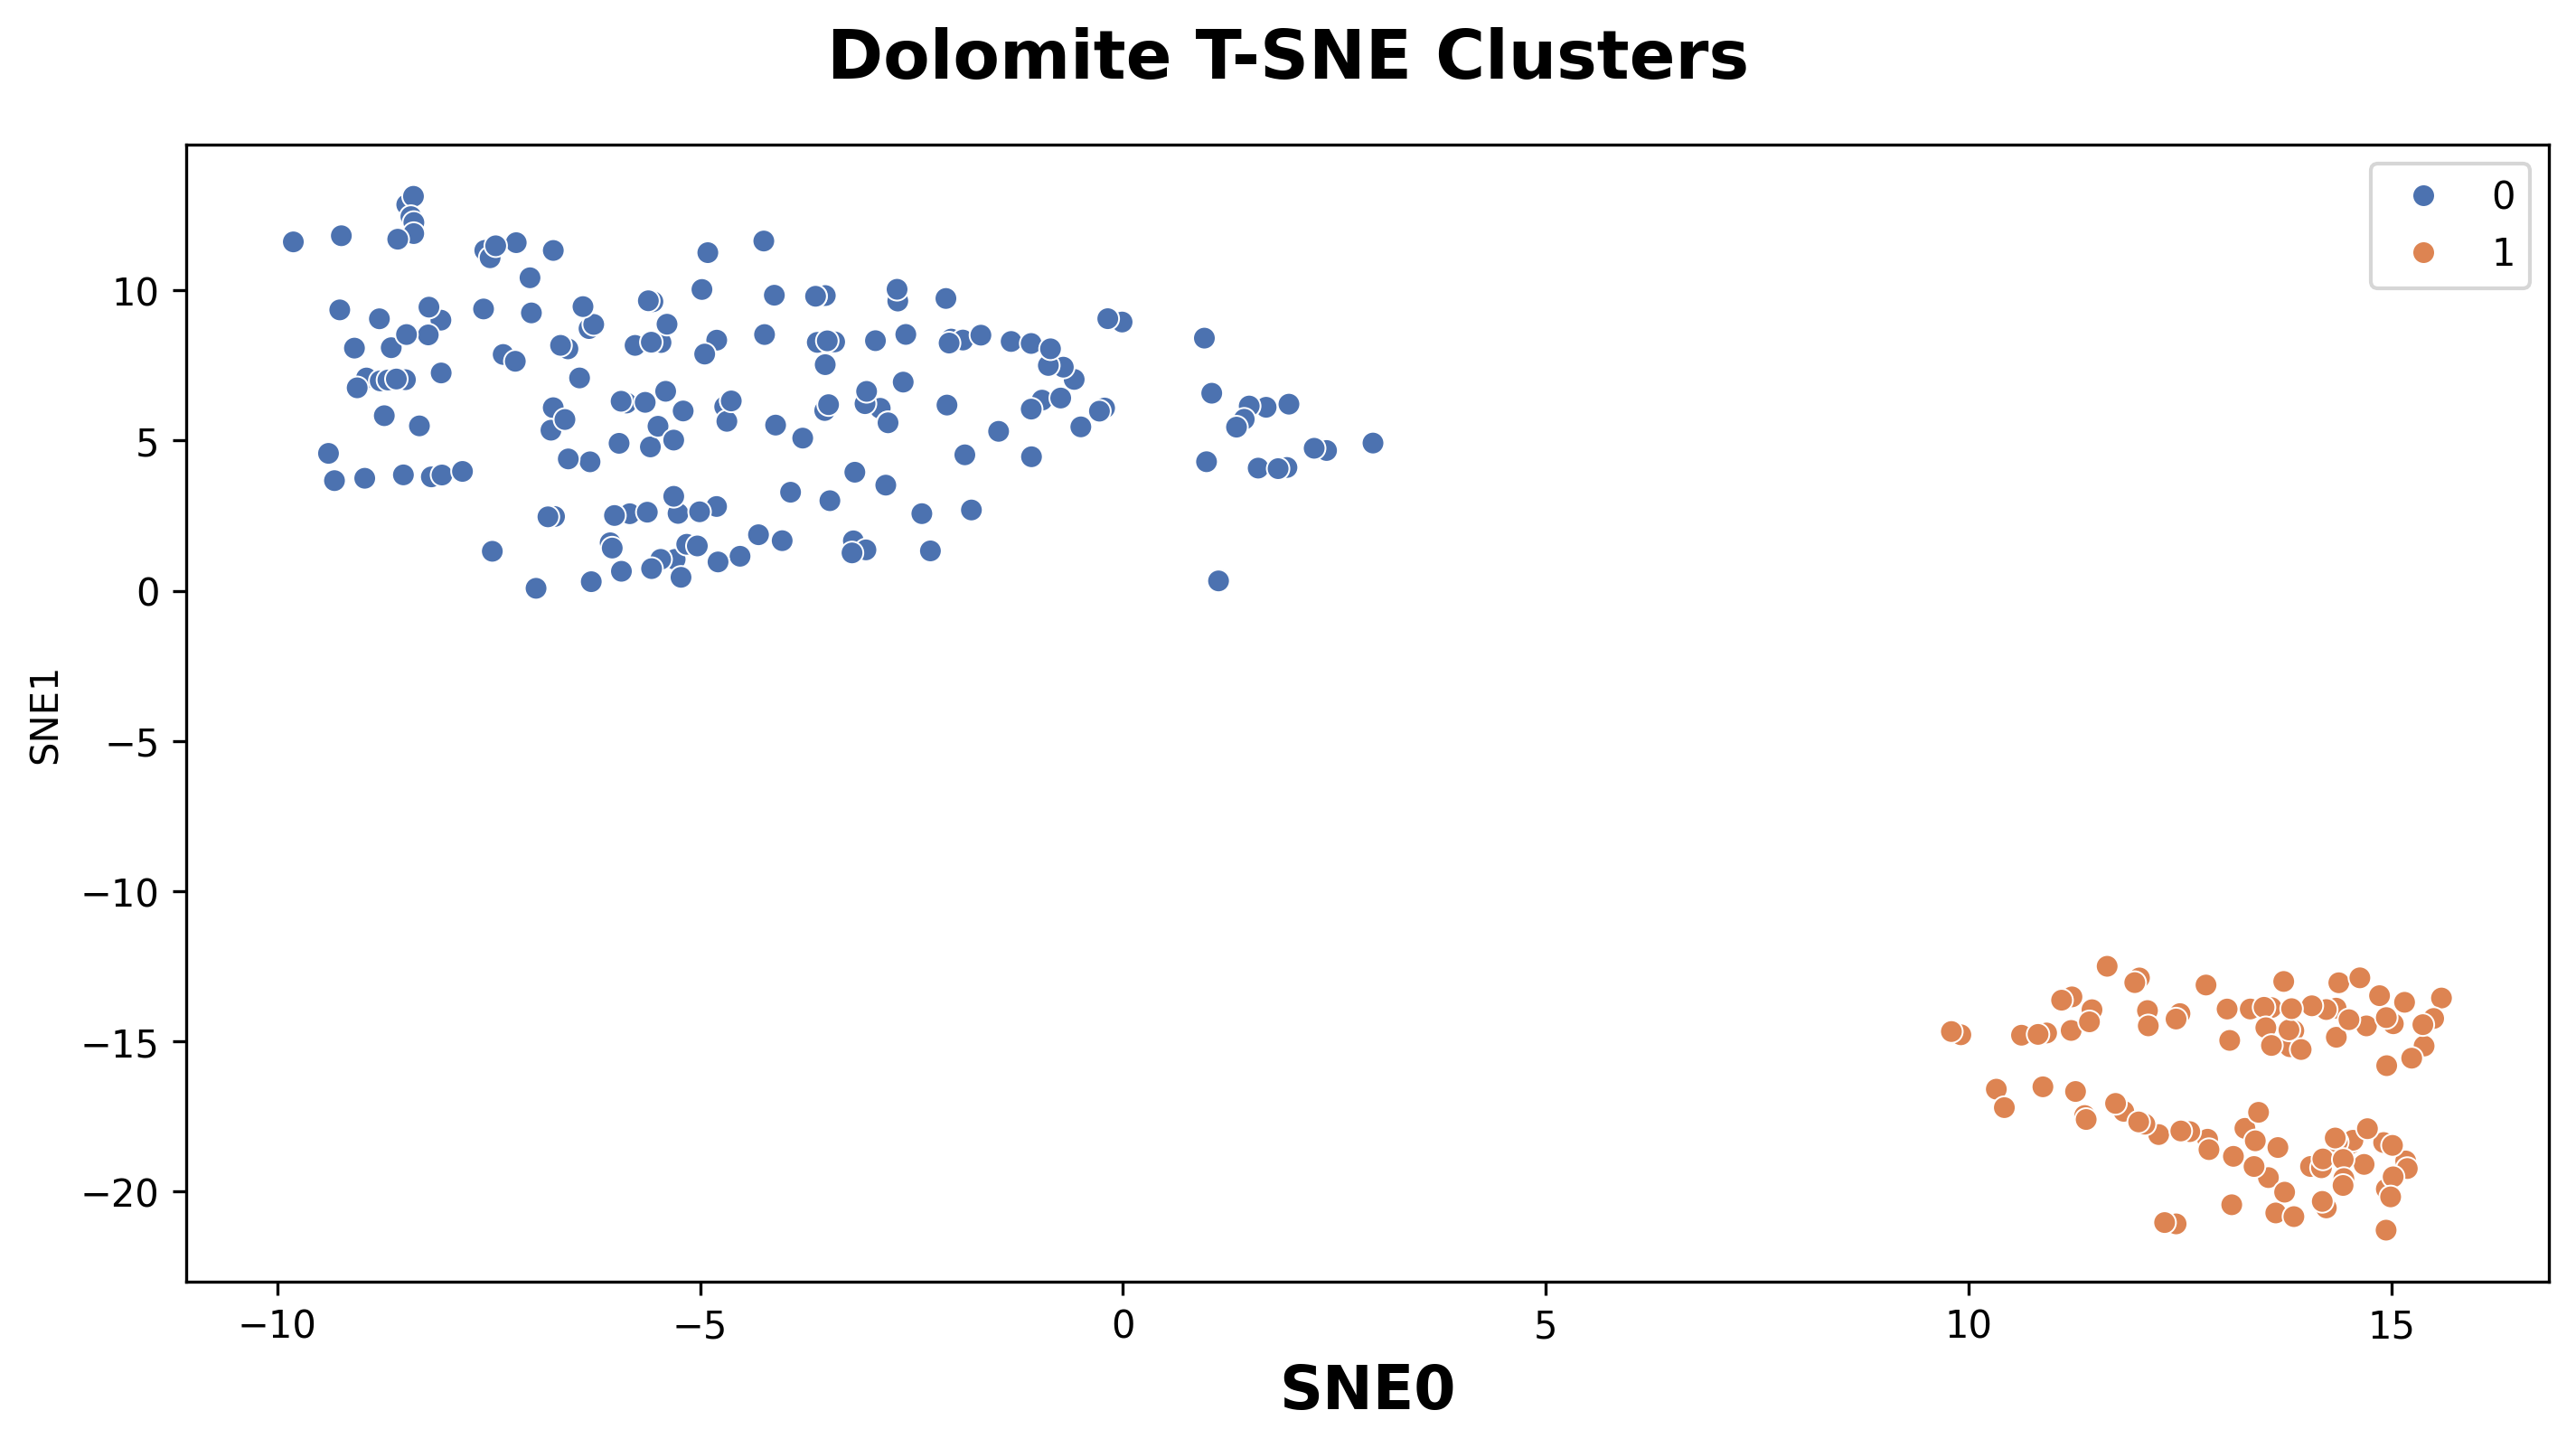

(289, 6)
Index(['cao', 'mgo', 's0_95'], dtype='object')


/tmp/ipykernel_1519/1531014664.py:62: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/1531014664.py:62: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/1531014664.py:62: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(


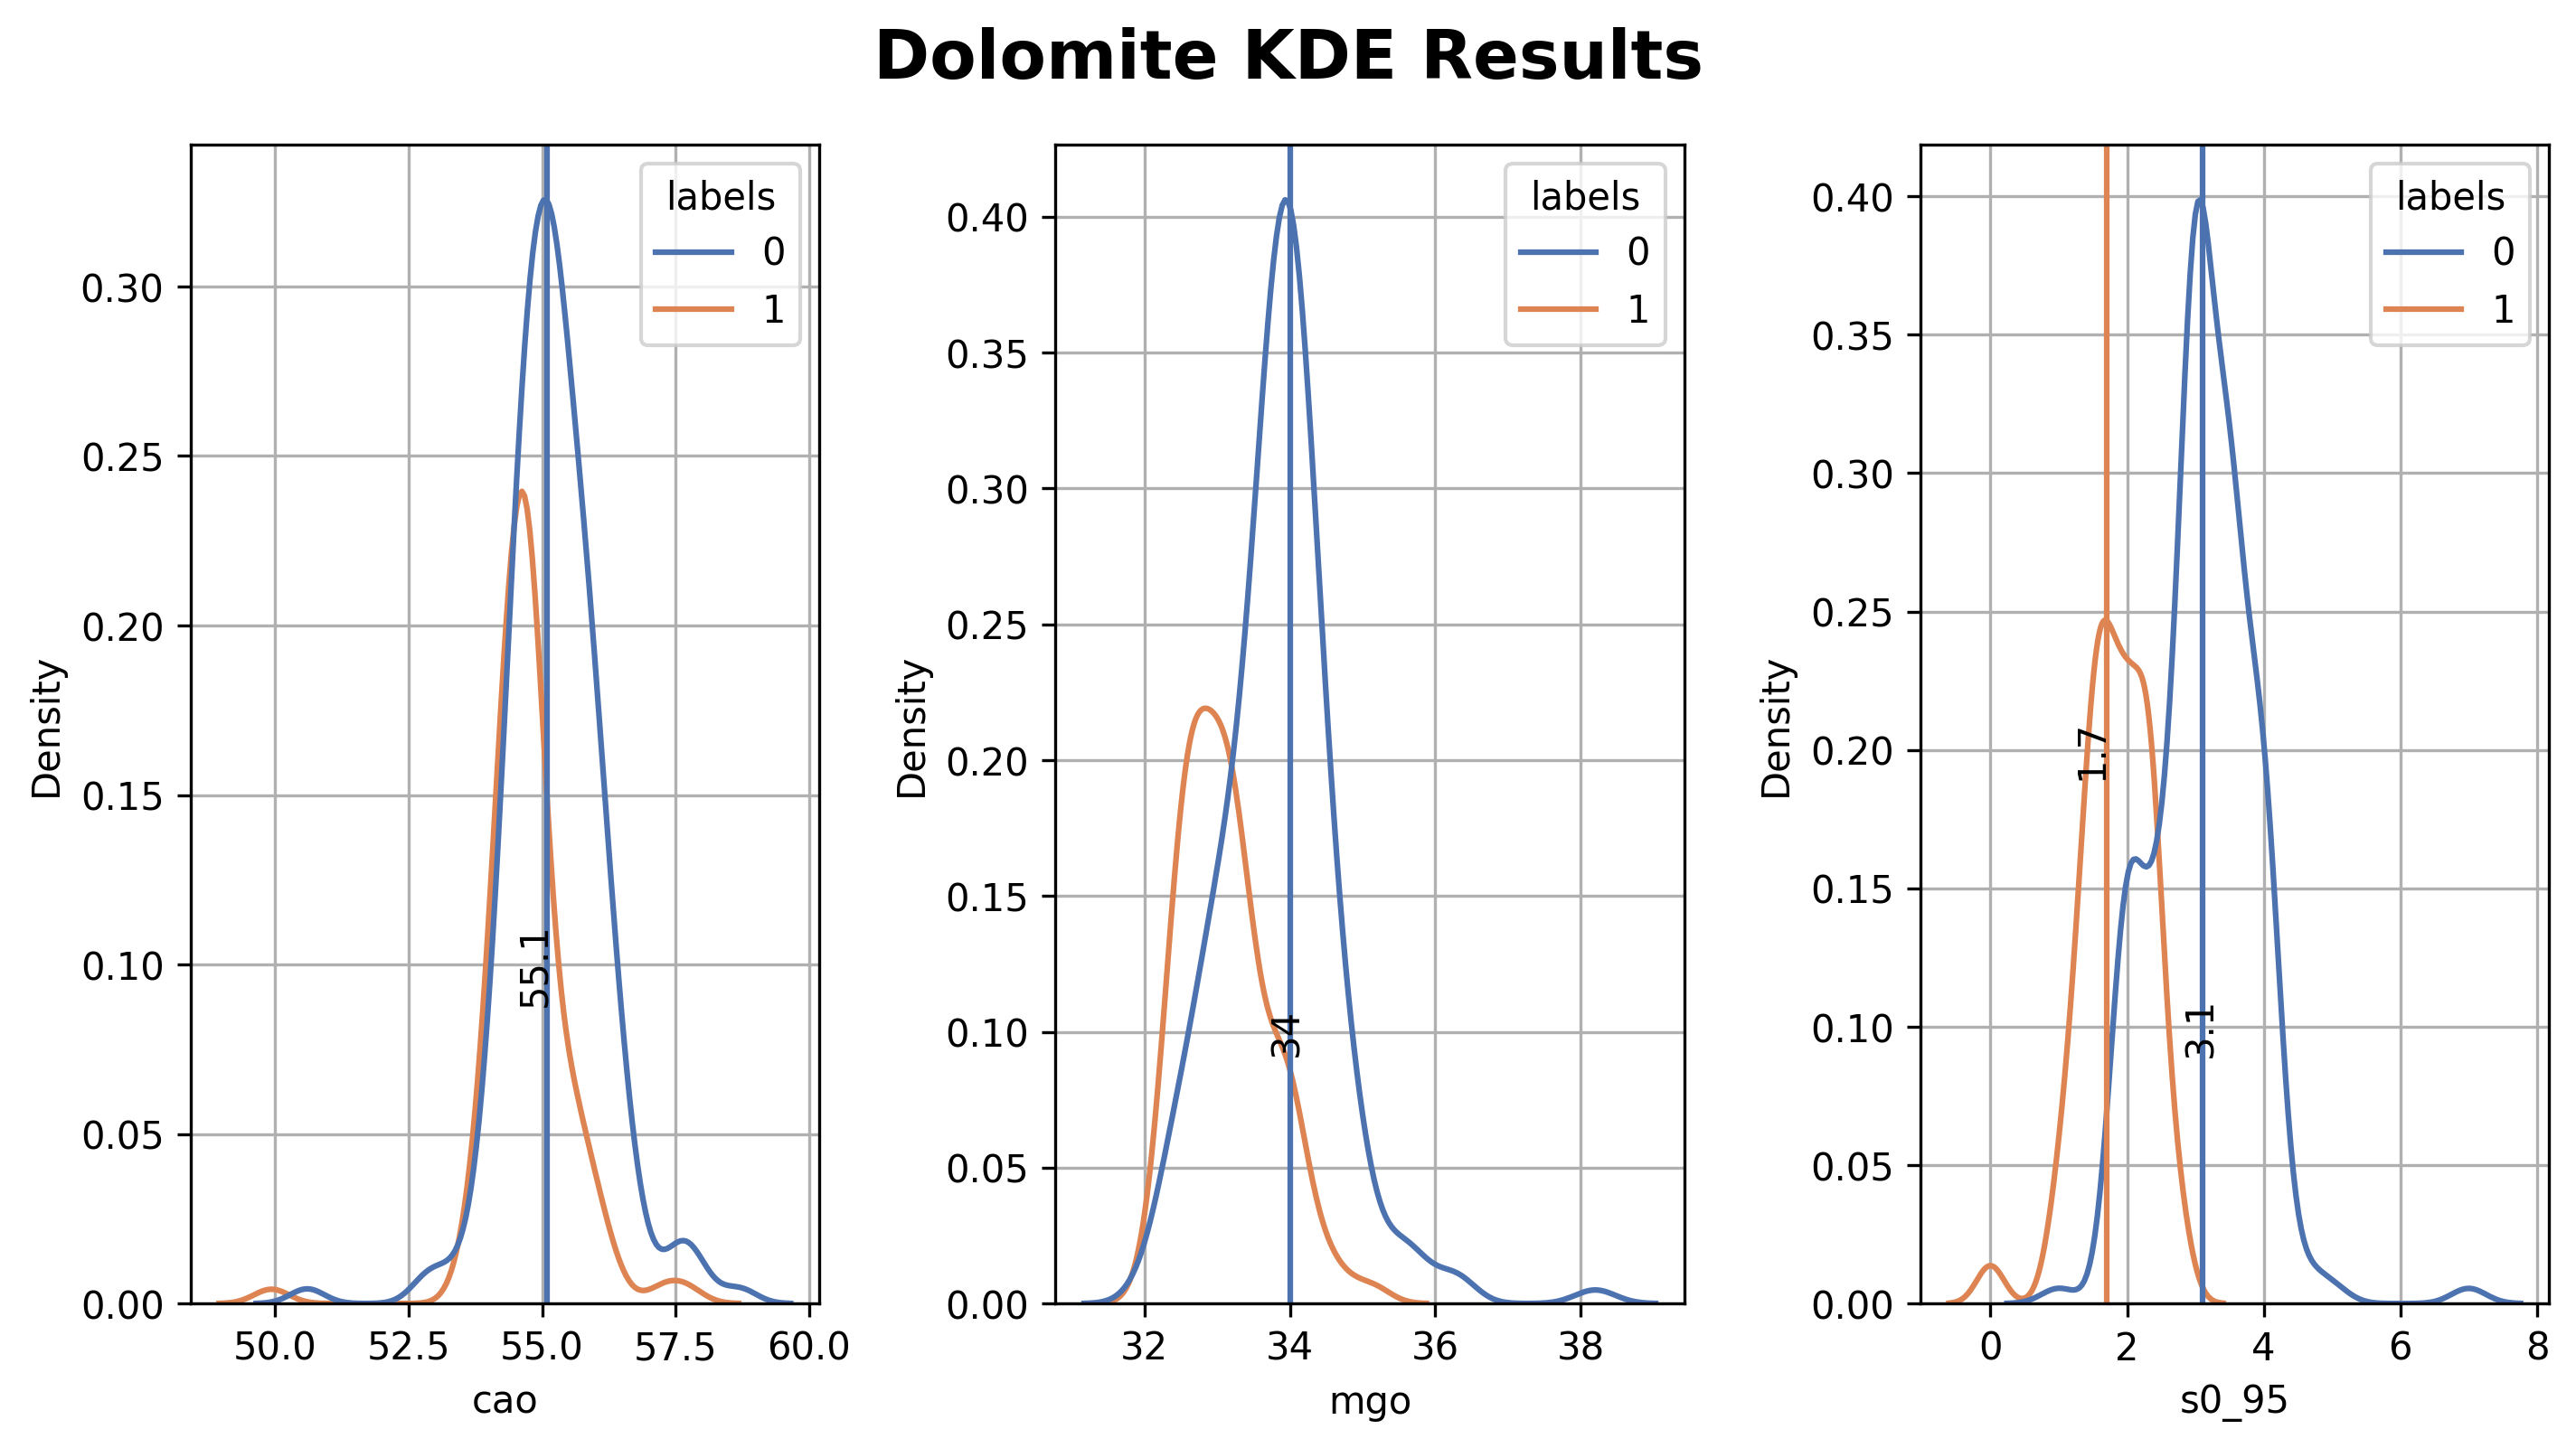

In [7]:
df = pd.read_csv(f"{working_dir}/data/dolo.csv")
df.set_index(keys='tar', inplace=True ,drop=True)
print(df.shape)
#--------Normalizing-------- 
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
print(normal_df.shape)
#--------Correlation--------
corr_df = normal_df.corr().abs()
corr_df = corr_df.where(np.triu(np.ones(corr_df.shape),k= 1).astype(bool)) #paiine matice motegharen ast ve hazf shod
high_corr_columns_name = pd.DataFrame(corr_df.ge(.95).stack().loc[lambda corr_df: corr_df].index.to_list())
print(high_corr_columns_name)
#df.drop(labels=['s315'] ,axis=1,inplace=True)
#-------Clustering---------
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
t_sne = TSNE(n_components=2, learning_rate='auto',random_state=0,
                  init='random', perplexity=50)
data=t_sne.fit_transform(normal_df)
sne_column_name = [f"SNE{column}"  for column in range(2) ]
sne_df = pd.DataFrame(data=data,columns=sne_column_name)
print(sne_df.shape)
model = AgglomerativeClustering(n_clusters = 2, metric= 'euclidean', linkage ='average')
model.fit(sne_df)
print(model.labels_.shape)
# ---------PLOT-------------
fig = plt.figure(figsize=(9.6,5.4),dpi=300)
fig.suptitle('Dolomite T-SNE Clusters', fontsize=18,fontweight='bold')
ax1 = fig.subplots(1,1)
ax1.set_xlabel('SNE0', fontsize=16,fontweight='bold')
#ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
cmap = sns.color_palette("deep", as_cmap=True)
sns.scatterplot(
    data=sne_df,
    x='SNE0',
    y='SNE1',
    hue=model.labels_,
    palette= cmap,
    )
fig.tight_layout()
plt.savefig(f'{working_dir}/presentation/dolomite-tsne-clusters.jpg')
plt.show()
#----------Labeling---------
clust_lable_dict = {0:0,1:1}
labels = [clust_lable_dict[i] for i in model.labels_]
df["labels"] = labels
print(df.shape)
#----------Labes Conditions-----
plot_name = df.columns.drop(['labels','s95_385','s385_1000'])
print(plot_name)
num = 0
for k in range(1):
    fig = plt.figure(num=k,figsize=(9.6,5.4),dpi=300)
    fig.suptitle('Dolomite KDE Results', fontsize=18,fontweight='bold')
    ax = fig.subplots(1,3)
    #sns.set_style("ticks",{'axes.grid' : True})
    for i in range(2):
        for j in range(3):
            if num == len(plot_name):
                break
            ax[j].grid(True)
            sns.kdeplot(
                data=df,
                x=plot_name[num],
                hue="labels",
                #hue_order=[0,2,3,],
                fill=False,
                #alpha = 0.4,
                palette= cmap,
                ax=ax[j],
            )
            num = num +1
    fig.tight_layout()
#ax[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
ax[0].axvline(55.1,color=cmap[0])
ax[0].text(54.5, 0.1, '55.1', rotation=90, va='center')
ax[1].axvline(34,color=cmap[0])
ax[1].text(33.7, 0.1, '34', rotation=90, va='center')
ax[2].axvline(3.1,color=cmap[0])
ax[2].text(2.8, 0.1, '3.1', rotation=90, va='center')
ax[2].axvline(1.7,color=cmap[1])
ax[2].text(1.2, 0.2, '1.7', rotation=90, va='center')
plt.savefig(f'{working_dir}/presentation/dolomite-kde-results.jpg')
plt.show()

# save For next use
df.to_csv(f"{working_dir}/data/dolo_with_labels.csv",index=True)
del df,normal_df,corr_df,high_corr_columns_name

<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
5- خواندن دیتاهای خام مربوط به آهک 
</b>
</div>

In [8]:
df = pd.read_csv(f"{working_dir}/Raw-Data/lime_Lab.csv",encoding='latin-1' )
print(f"size of raw data = {df.shape}")
# Drop Some Columns
df.drop(labels=['sample_no','factory'],axis=1,inplace=True)
#Filter Tarikh
df = df[df['tar'] >= 14020915]
#change type of tarikh column for grouping
df = df.astype({'tar': str})
print(f"from 14020915 to 14030915 = {df.shape}")
#group tarikh by Average of other columns
df = df.groupby('tar', as_index=False).mean().round(2)
df.reset_index(inplace=True ,drop=True)
print(f"After Grouping By Tarikh  = {df.shape}")
print(df.describe())
#drop some columns because all time are 0.0
df.drop(labels=['s0_5','s5_335','s335','s508'],axis=1,inplace=True)
#save prepared data for next
df.to_csv(f"{working_dir}/data/lime.csv",index=False)
#remove dataframe from memory
del df

size of raw data = (8613, 11)
from 14020915 to 14030915 = (1077, 9)
After Grouping By Tarikh  = (316, 9)
              cao         mgo   s0_5  s5_335   s335       s0_95     s95_508  \
count  316.000000  316.000000  316.0   316.0  316.0  316.000000  316.000000   
mean    91.325348    1.218449    0.0     0.0    0.0    3.859810   84.259494   
std      0.537335    0.136190    0.0     0.0    0.0    2.072044   18.643998   
min     89.500000    0.800000    0.0     0.0    0.0    0.800000   19.200000   
25%     90.972500    1.200000    0.0     0.0    0.0    3.000000   72.555000   
50%     91.345000    1.200000    0.0     0.0    0.0    4.000000   95.500000   
75%     91.700000    1.200000    0.0     0.0    0.0    4.330000   96.000000   
max     93.100000    2.430000    0.0     0.0    0.0   27.580000   97.500000   

        s508  
count  316.0  
mean     0.0  
std      0.0  
min      0.0  
25%      0.0  
50%      0.0  
75%      0.0  
max      0.0  


<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
1-5 - خوشه بندی داده 
</b>
</div>

(316, 4)
(316, 4)
Empty DataFrame
Columns: []
Index: []
(316, 2)
(316,)


/tmp/ipykernel_1519/1531676770.py:34: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


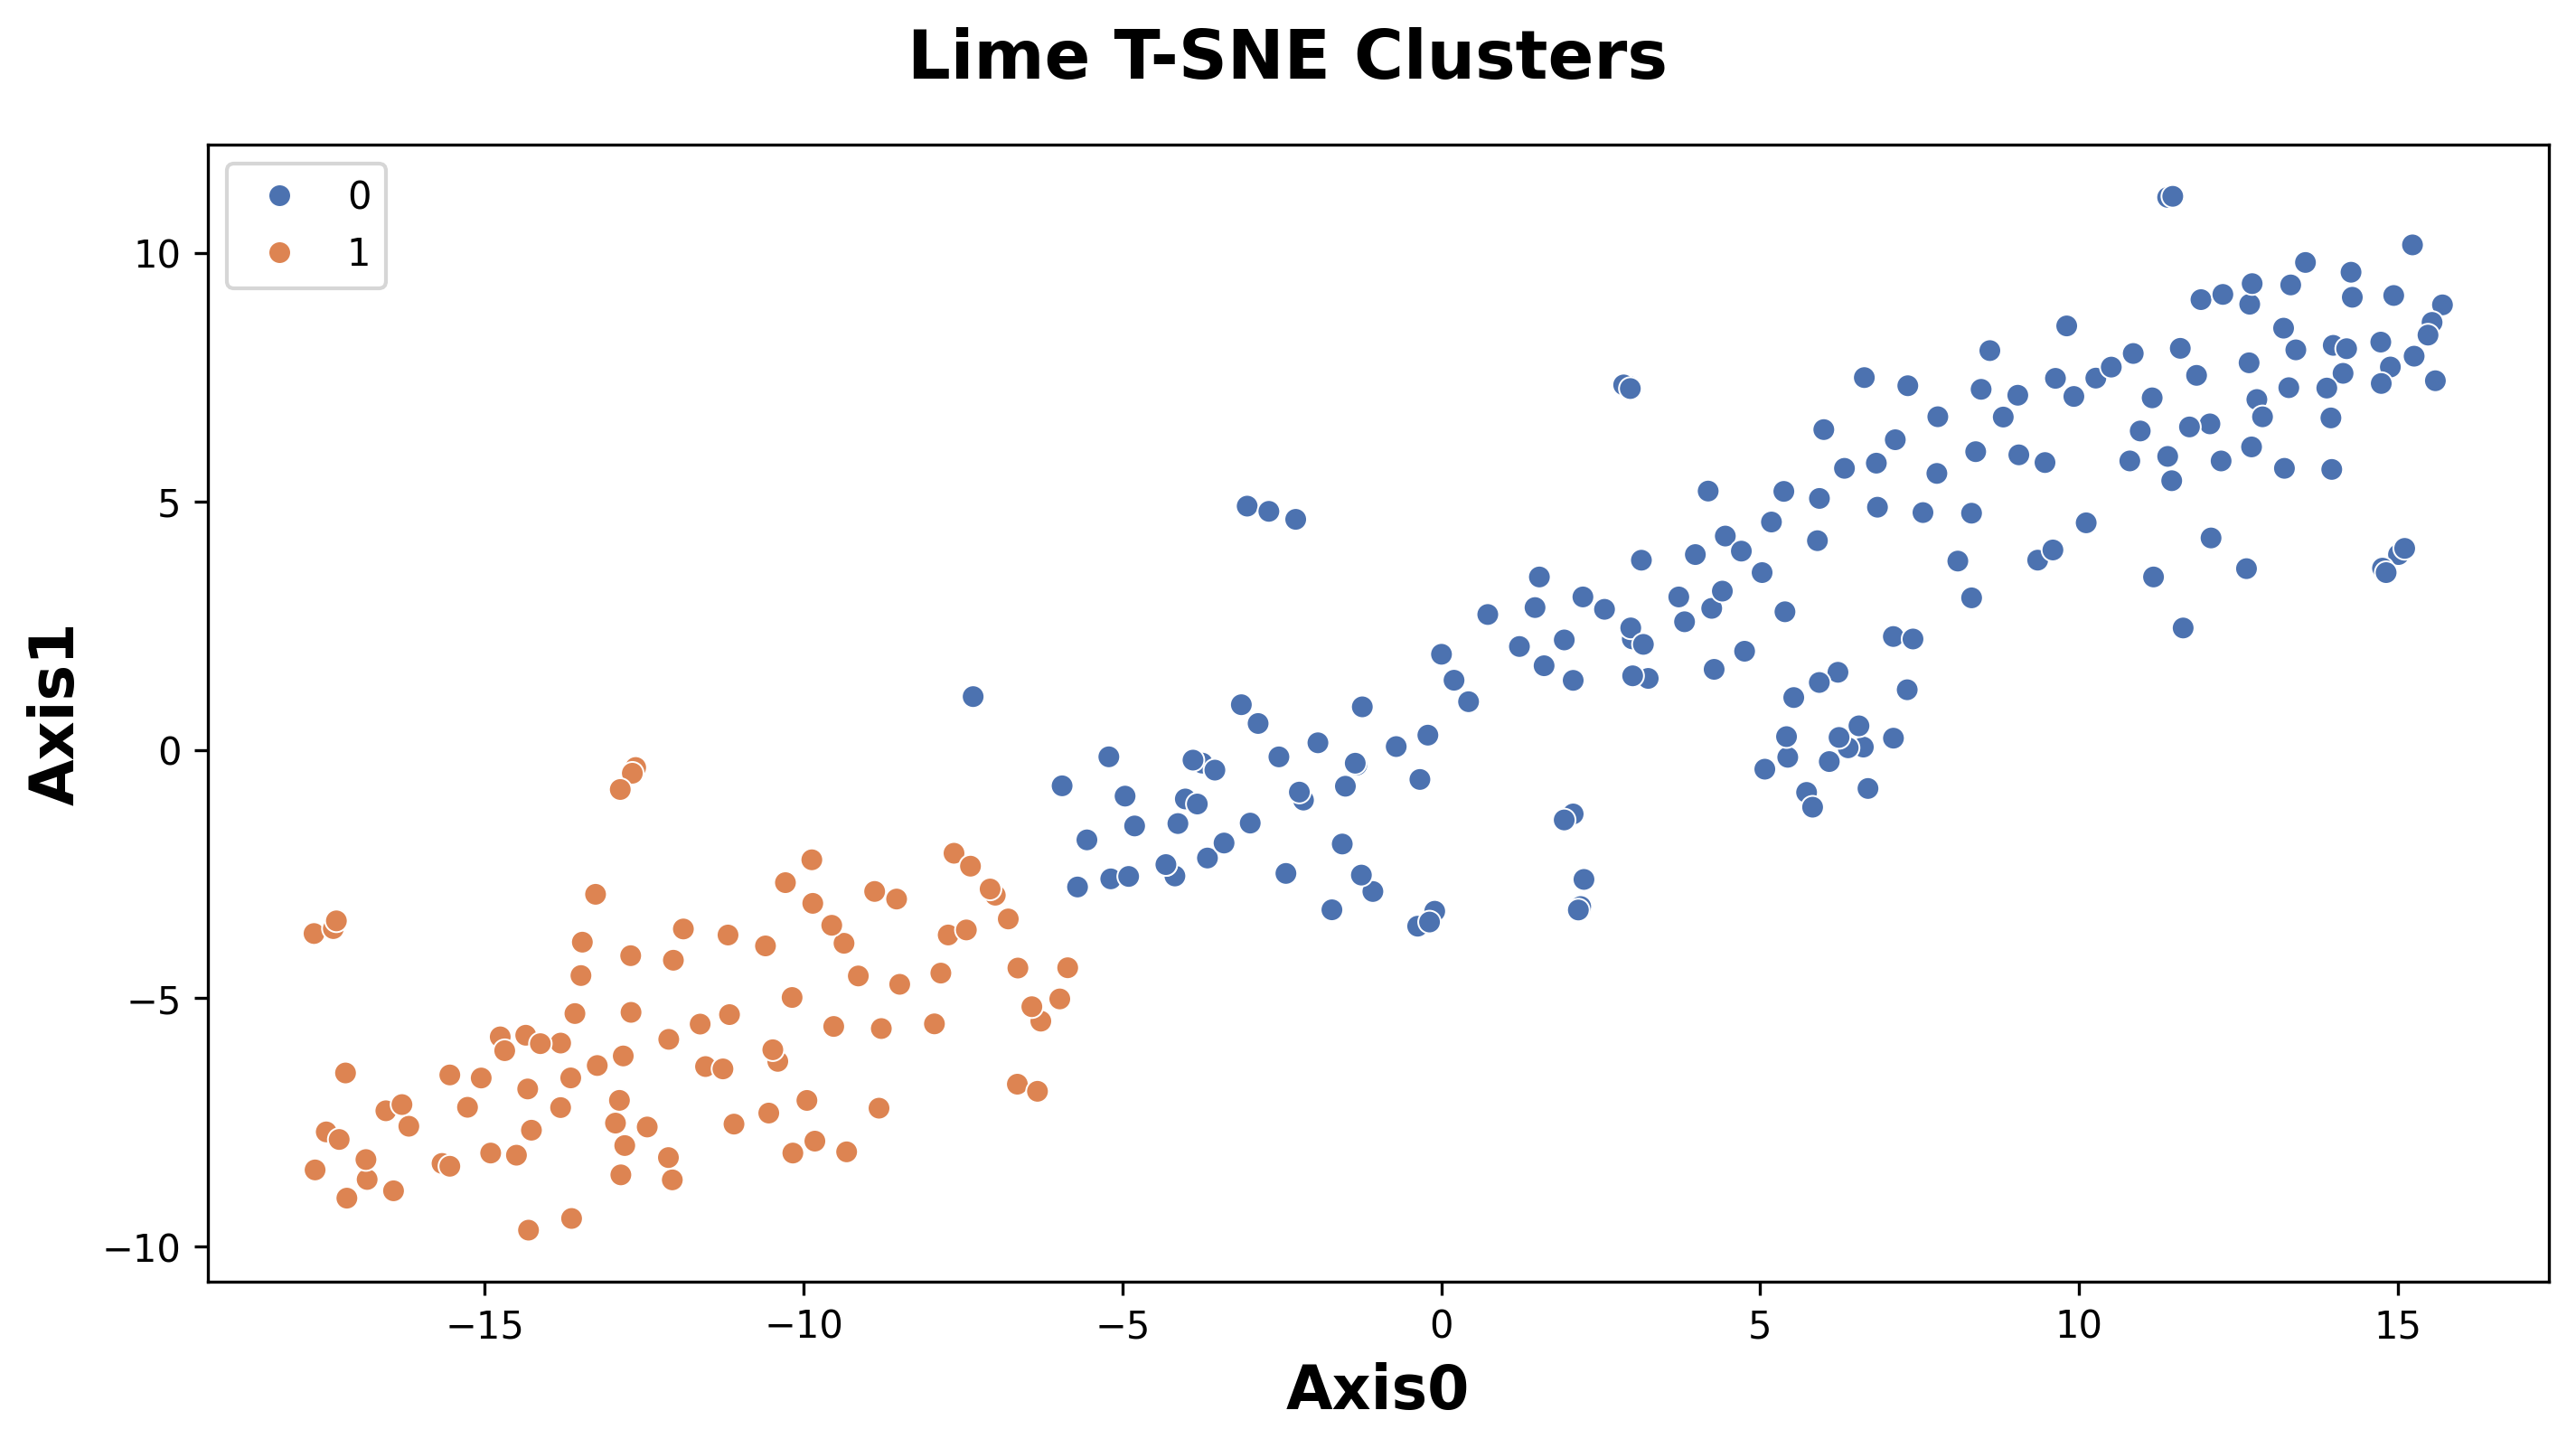

(316, 4)
Index(['cao', 'mgo', 's0_95'], dtype='object')


/tmp/ipykernel_1519/1531676770.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/1531676770.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/1531676770.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(


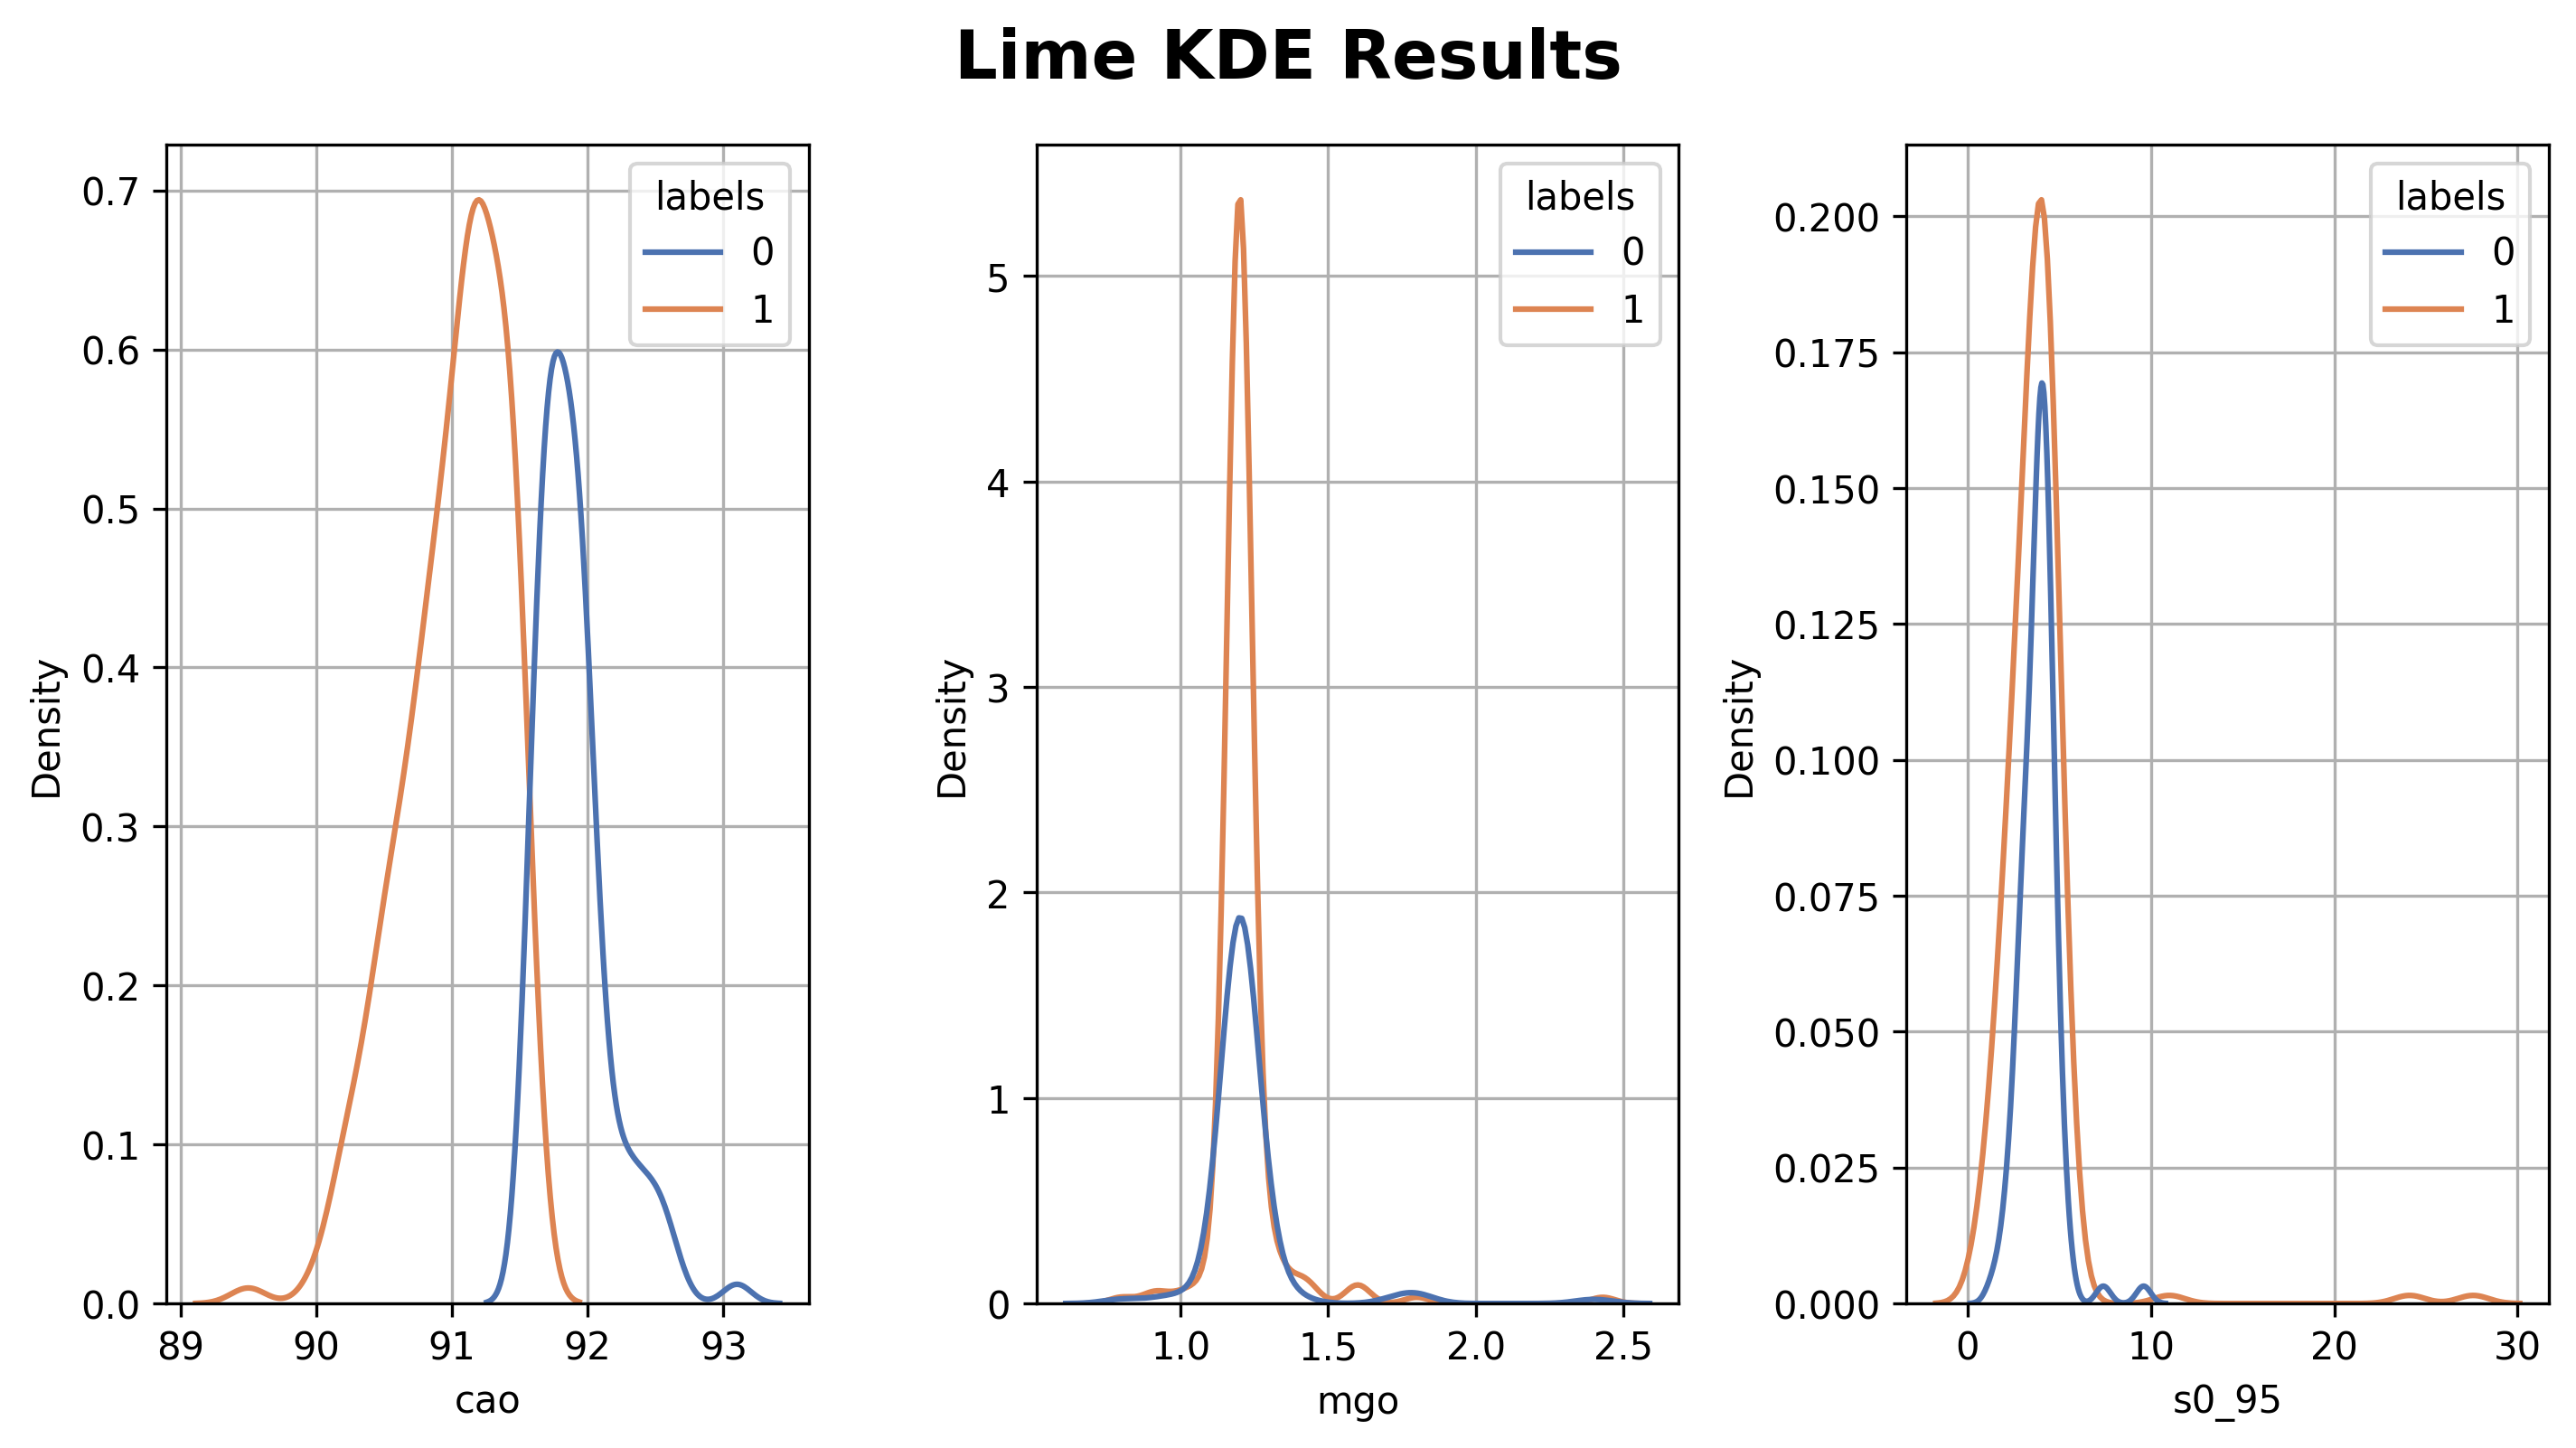

In [9]:
df = pd.read_csv(f"{working_dir}/data/lime.csv")
df.set_index(keys='tar', inplace=True ,drop=True)
print(df.shape)
#--------Normalizing-------- 
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
print(normal_df.shape)
#--------Correlation--------
corr_df = normal_df.corr().abs()
corr_df = corr_df.where(np.triu(np.ones(corr_df.shape),k= 1).astype(bool)) #paiine matice motegharen ast ve hazf shod
high_corr_columns_name = pd.DataFrame(corr_df.ge(.95).stack().loc[lambda corr_df: corr_df].index.to_list())
print(high_corr_columns_name)
df.drop(labels=['s95_508'] ,axis=1,inplace=True)
#-------Clustering---------
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
t_sne = TSNE(n_components=2, learning_rate='auto',random_state=0,
                  init='random', perplexity=50)
data=t_sne.fit_transform(normal_df)
sne_column_name = [f"SNE{column}"  for column in range(2) ]
sne_df = pd.DataFrame(data=data,columns=sne_column_name)
print(sne_df.shape)
model = AgglomerativeClustering(n_clusters = 2, metric= 'euclidean', linkage ='average')
model.fit(sne_df)
print(model.labels_.shape)
# ---------PLOT-------------
fig = plt.figure(figsize=(9.6,5.4),dpi=300)
fig.suptitle('Lime T-SNE Clusters', fontsize=18,fontweight='bold')
ax1 = fig.subplots(1,1)
ax1.set_xlabel('Axis0', fontsize=16,fontweight='bold')
ax1.set_ylabel('Axis1', fontsize=16,fontweight='bold')
#ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
cmap = sns.color_palette("deep", as_cmap=True)
sns.scatterplot(
    data=sne_df,
    x='SNE0',
    y='SNE1',
    hue=model.labels_,
    palette= cmap,
    )
fig.tight_layout()
plt.savefig(f'{working_dir}/presentation/lime-tsne-clusters.jpg')
plt.show()
#----------Labeling---------
clust_lable_dict = {0:1,1:0}
labels = [clust_lable_dict[i] for i in model.labels_]
df["labels"] = labels
print(df.shape)
#----------Labes Conditions-----
plot_name = df.columns.drop('labels')
print(plot_name)
num = 0
for k in range(1):
    fig = plt.figure(num=k,figsize=(9.6,5.4),dpi=300)
    fig.suptitle('Lime KDE Results', fontsize=18,fontweight='bold')
    ax = fig.subplots(1,3)
    #sns.set_style("ticks",{'axes.grid' : True})
    for i in range(1):
        for j in range(3):
            if num == len(plot_name):
                break
            ax[j].grid(True)
            sns.kdeplot(
                data=df,
                x=plot_name[num],
                hue="labels",
                #hue_order=[0,2,3,],
                fill=False,
                #alpha = 0.4,
                palette= cmap,
                ax=ax[j],
            )
            num = num +1
    fig.tight_layout()
plt.savefig(f'{working_dir}/presentation/lime-kde-results.jpg')
plt.show()

# save For next use
df.to_csv(f"{working_dir}/data/lime_with_labels.csv",index=True)
del df,normal_df,corr_df,high_corr_columns_name

<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
6- خواندن دیتاهای خام مربوط به DRI 
</b>
</div>

size of raw data = (8364, 21)
from 14020915 to 14030915 = (1947, 15)
After Grouping By Tarikh  = (345, 14)
<class 'pandas.core.frame.DataFrame'>
Index: 345 entries, 0 to 662
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tar       345 non-null    object 
 1   fe_metal  345 non-null    float64
 2   fe_total  345 non-null    float64
 3   md        345 non-null    float64
 4   c         345 non-null    float64
 5   cao       345 non-null    float64
 6   sio2      345 non-null    float64
 7   mgo       345 non-null    float64
 8   al2o3     345 non-null    float64
 9   p         345 non-null    float64
 10  mno       345 non-null    float64
 11  gunge     345 non-null    float64
 12  feo       345 non-null    float64
 13  feo_c     345 non-null    float64
dtypes: float64(13), object(1)
memory usage: 40.4+ KB
None


/tmp/ipykernel_1519/2156073508.py:20: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


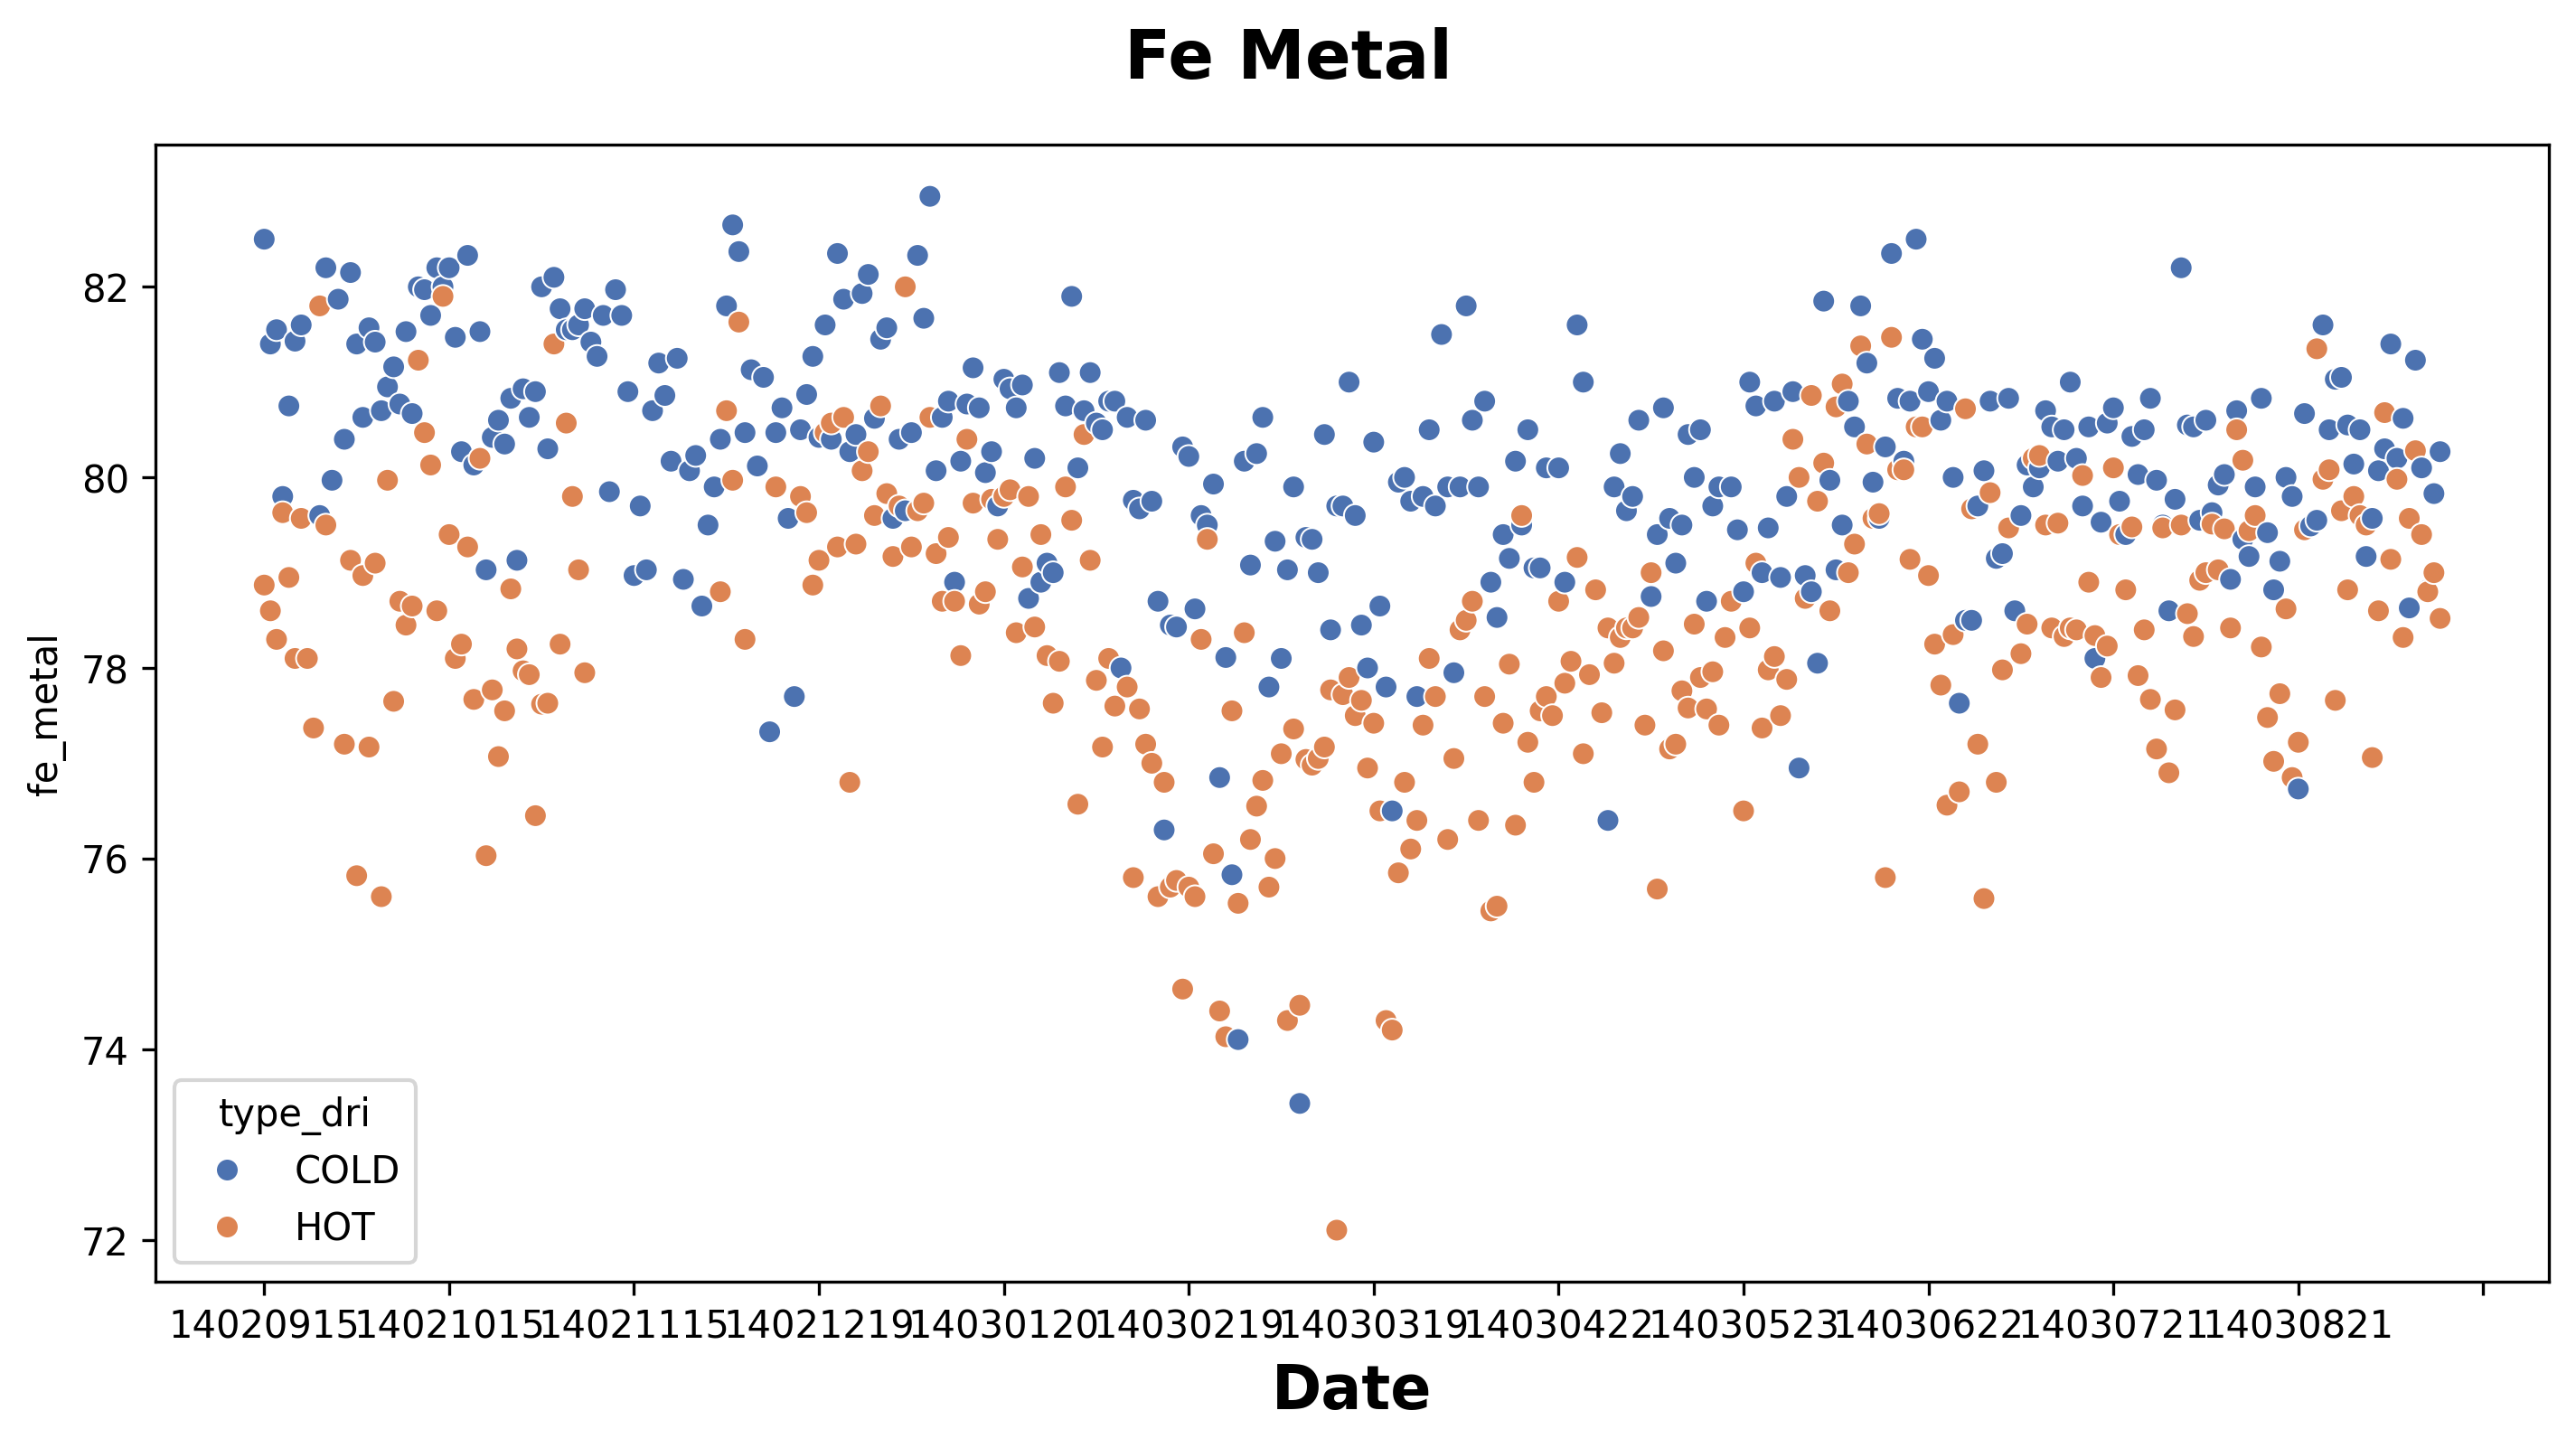

In [10]:
df = pd.read_csv(f"{working_dir}/Raw-Data/dri_Lab.csv",encoding='latin-1' )
print(f"size of raw data = {df.shape}")
# Drop Some Columns attention s & md_c removed because was 0
df.drop(labels=['lab_no','factory','heat_no','dqi','s','md_c'],axis=1,inplace=True)
#Filter Tarikh
df = df[df['tar'].between(14020915,14030915)]
print(f"from 14020915 to 14030915 = {df.shape}")
#change type of tarikh column for grouping
df = df.astype({'tar': str})
df = df.groupby(['tar','type_dri'], as_index=False).mean().round(2)

#----PLOT---------------
fig = plt.figure(figsize=(9.6,5.4),dpi=300)
fig.suptitle('Fe Metal', fontsize=18,fontweight='bold')
ax1 = fig.subplots(1,1)
ax1.set_xlabel('Date', fontsize=16,fontweight='bold')
#ax1.set_xlim(99.7,99.9)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(30))
cmap = sns.color_palette("deep", as_cmap=True)
sns.scatterplot(
    data=df,
    x='tar',
    y='fe_metal',
    hue='type_dri',
    #hue_order=[0,2,3,],
    #fill=False,
    #alpha = 0.4,
    palette= cmap,
    )
#plt.axvline(99.827, c='green')
#plt.annotate('99.827 %', xy =(99.825, 5),rotation = 90,ha='center', fontsize=20,alpha = 0.8)
#plt.axvline(99.807, c='green')
#plt.annotate('99.807 %', xy =(99.805, 5),rotation = 90,ha='center', fontsize=20,alpha = 0.8)
#sns.move_legend(obj = ax1, loc = 'best', labels=["Adelie", "Chinstrap", "Gentoo"])
fig.tight_layout()
#plt.savefig(f'{working_dir}/fig/C5000 Amp VS O2 purity.jpg')
#----End Of PLOT--------

#use only cold data and drop column
mask = df['type_dri'] == 'COLD'
df = df[mask]
df.drop(labels=['type_dri'],axis=1,inplace=True)
print(f"After Grouping By Tarikh  = {df.shape}")
print(df.info())
plt.show()
plt.close()
#save prepared data for next
df.to_csv(f"{working_dir}/data/dri.csv",index=False)
#remove dataframe from memory
del df

<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
1-6 - خوشه بندی داده 
</b>
</div>

(345, 13)
(345, 13)
        0      1
0      md    feo
1     cao   sio2
2     cao    mgo
3     cao  al2o3
4     cao      p
5     cao    mno
6    sio2    mgo
7    sio2  al2o3
8    sio2      p
9    sio2    mno
10    mgo  al2o3
11    mgo    mno
12  al2o3      p
13  al2o3    mno
(345, 2)
(345,)


/tmp/ipykernel_1519/65041519.py:34: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


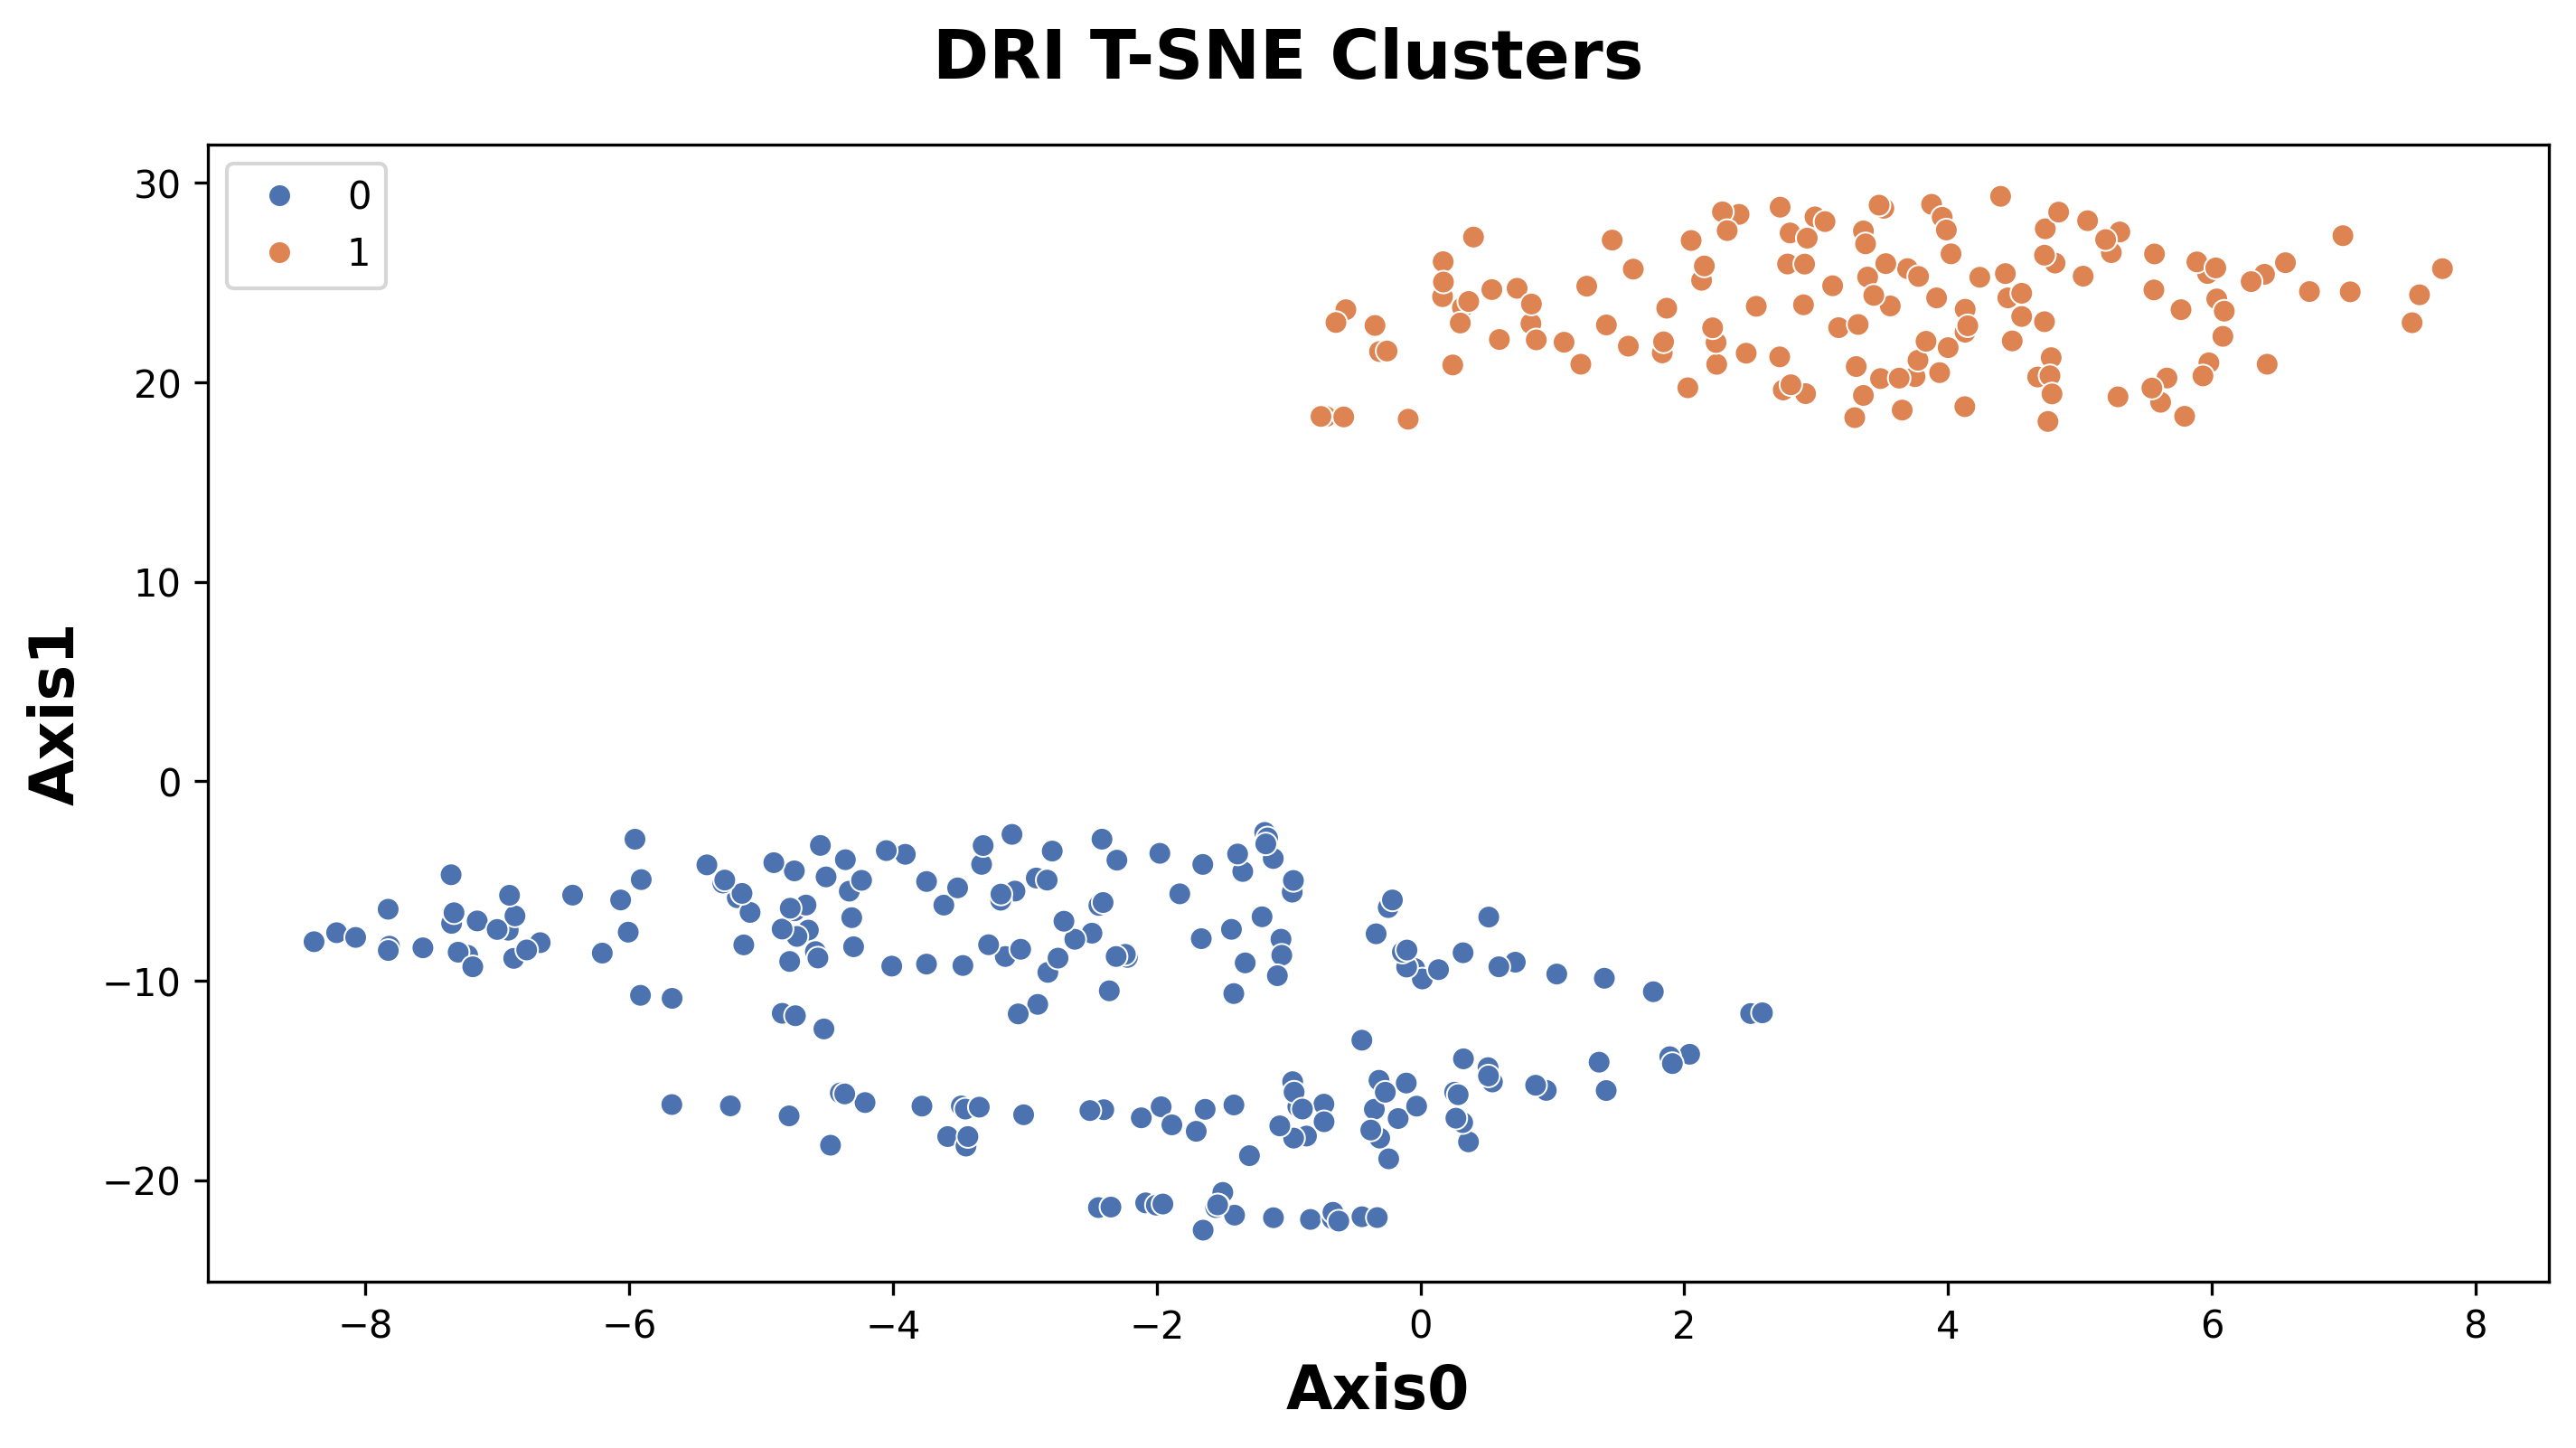

(345, 14)
Index(['fe_metal', 'fe_total', 'md', 'c', 'cao', 'sio2', 'mgo', 'al2o3', 'p',
       'mno', 'gunge', 'feo', 'feo_c'],
      dtype='object')


/tmp/ipykernel_1519/65041519.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/65041519.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/65041519.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/65041519.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/65041519.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/65041519.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/65041519.py:63: UserWarning: The palette list has more values (10) than needed (2), which may not be int

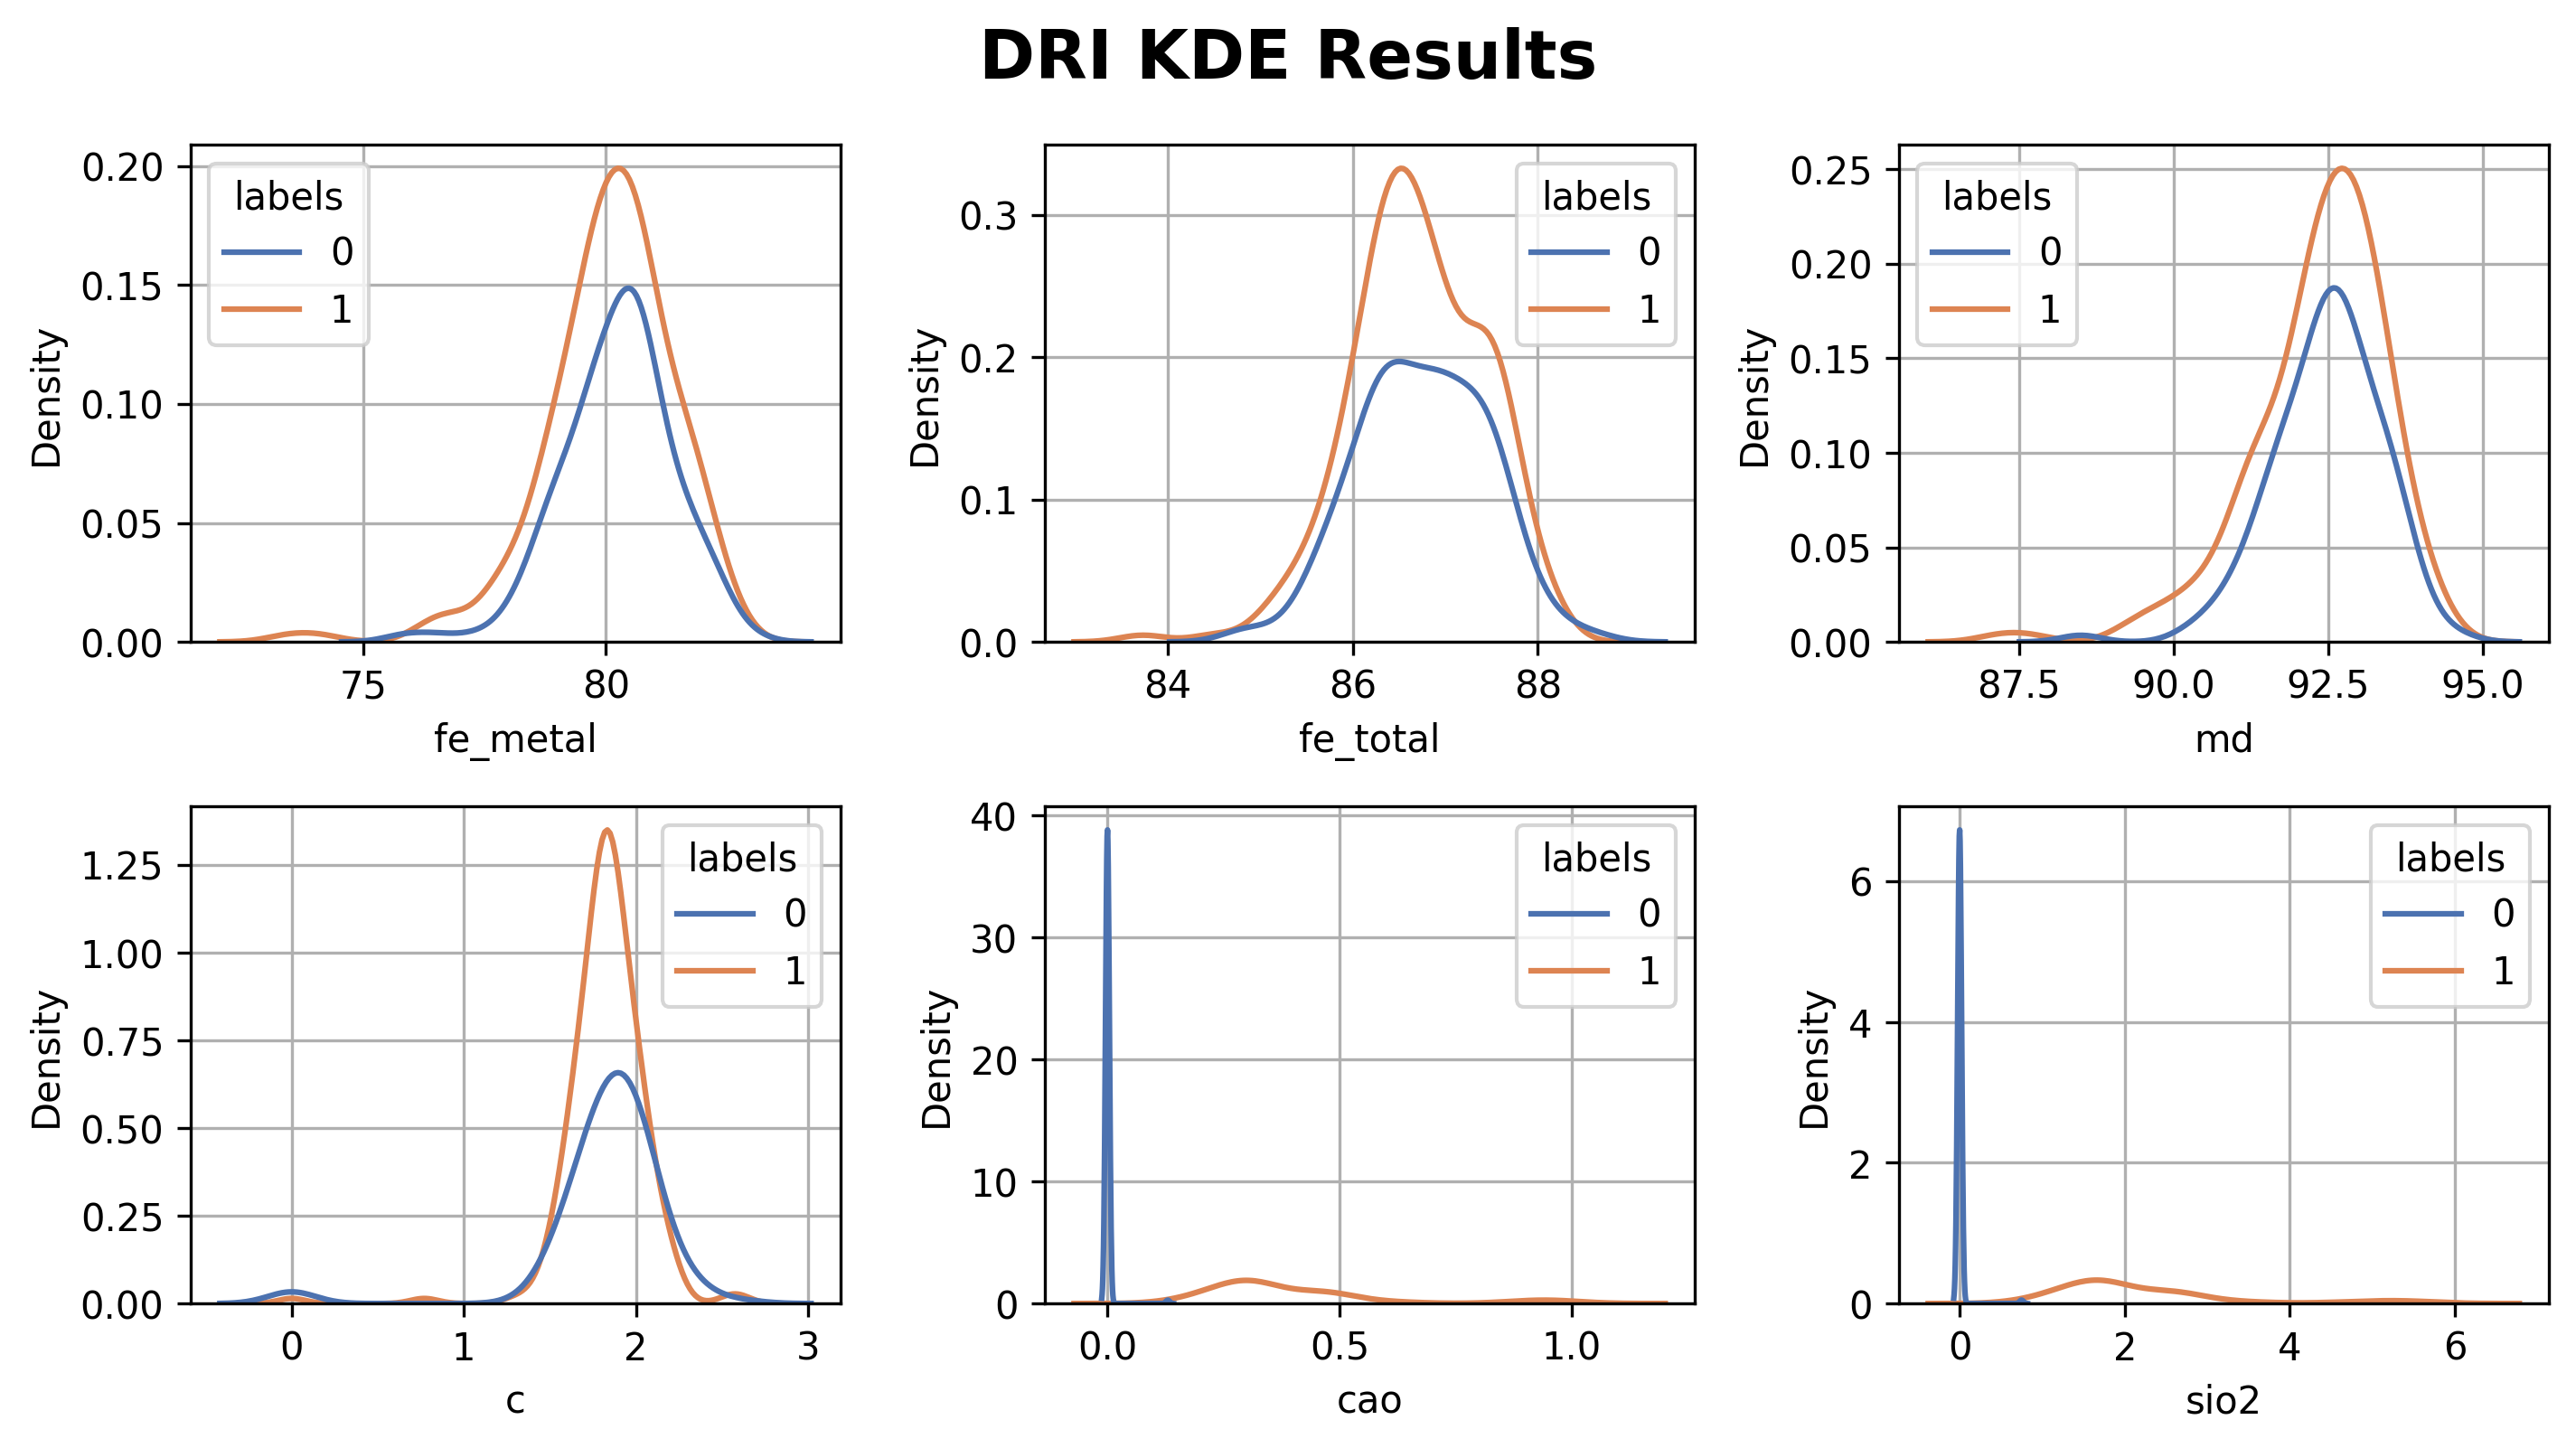

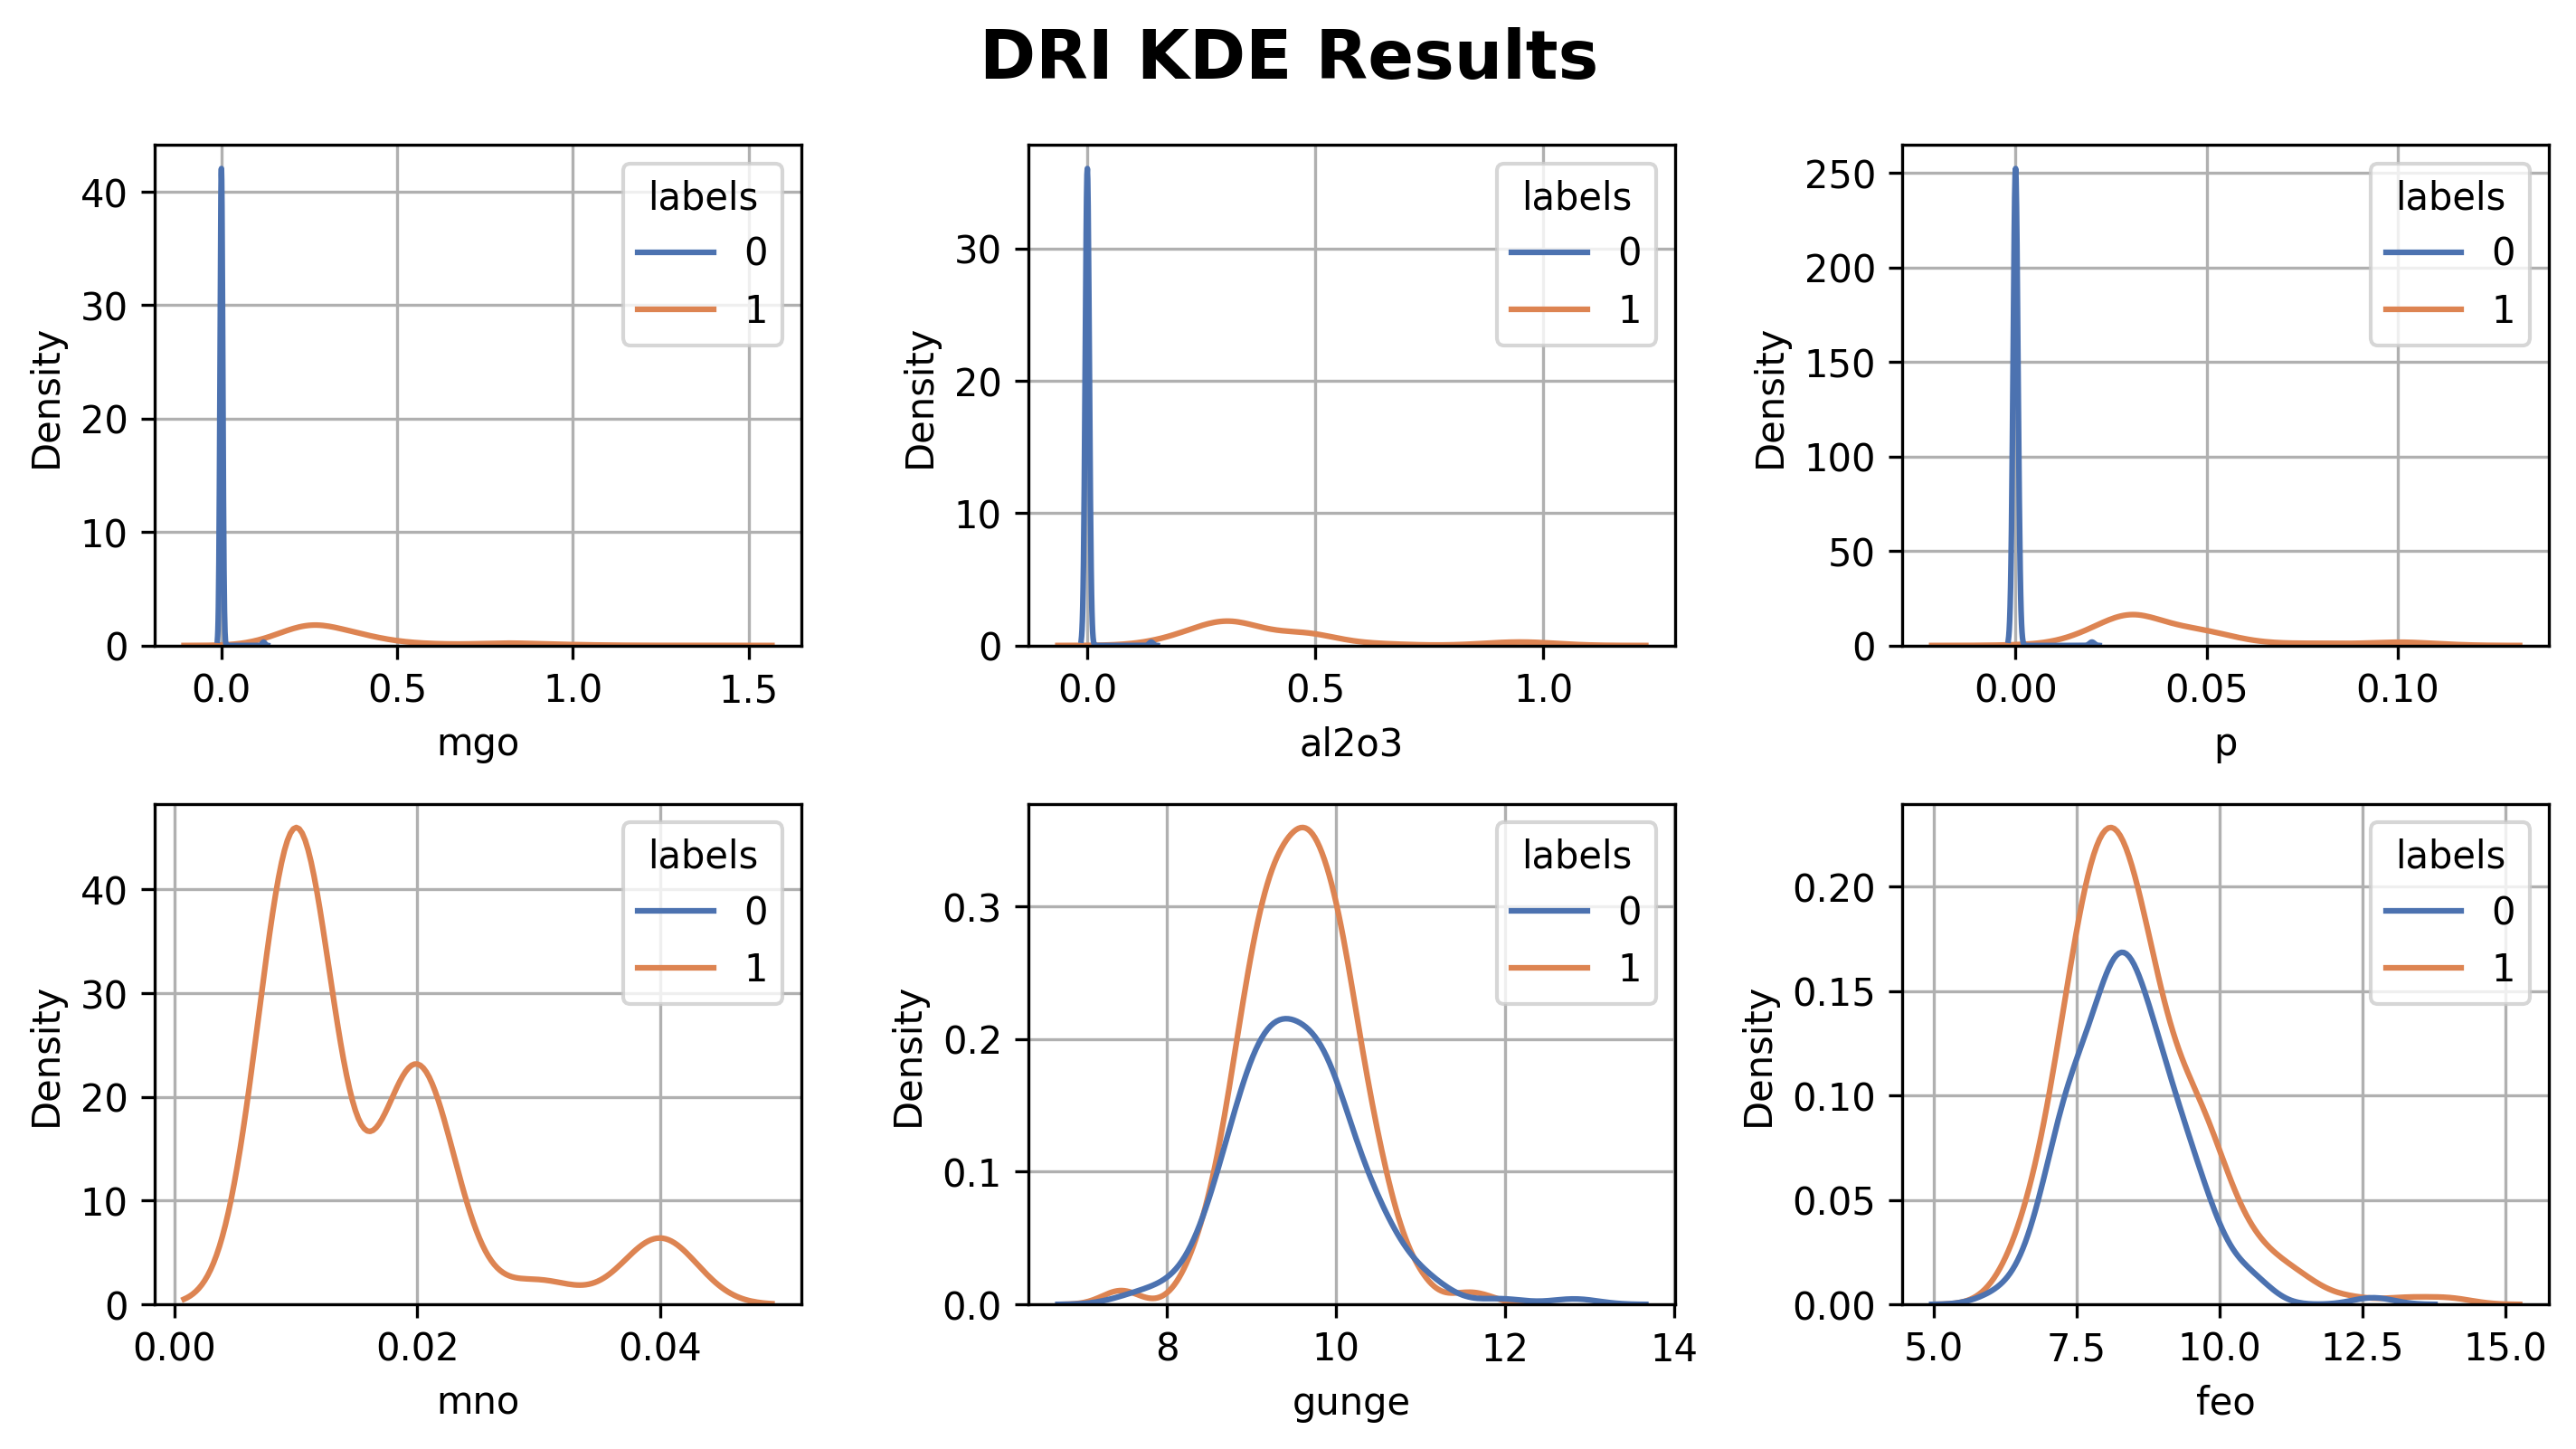

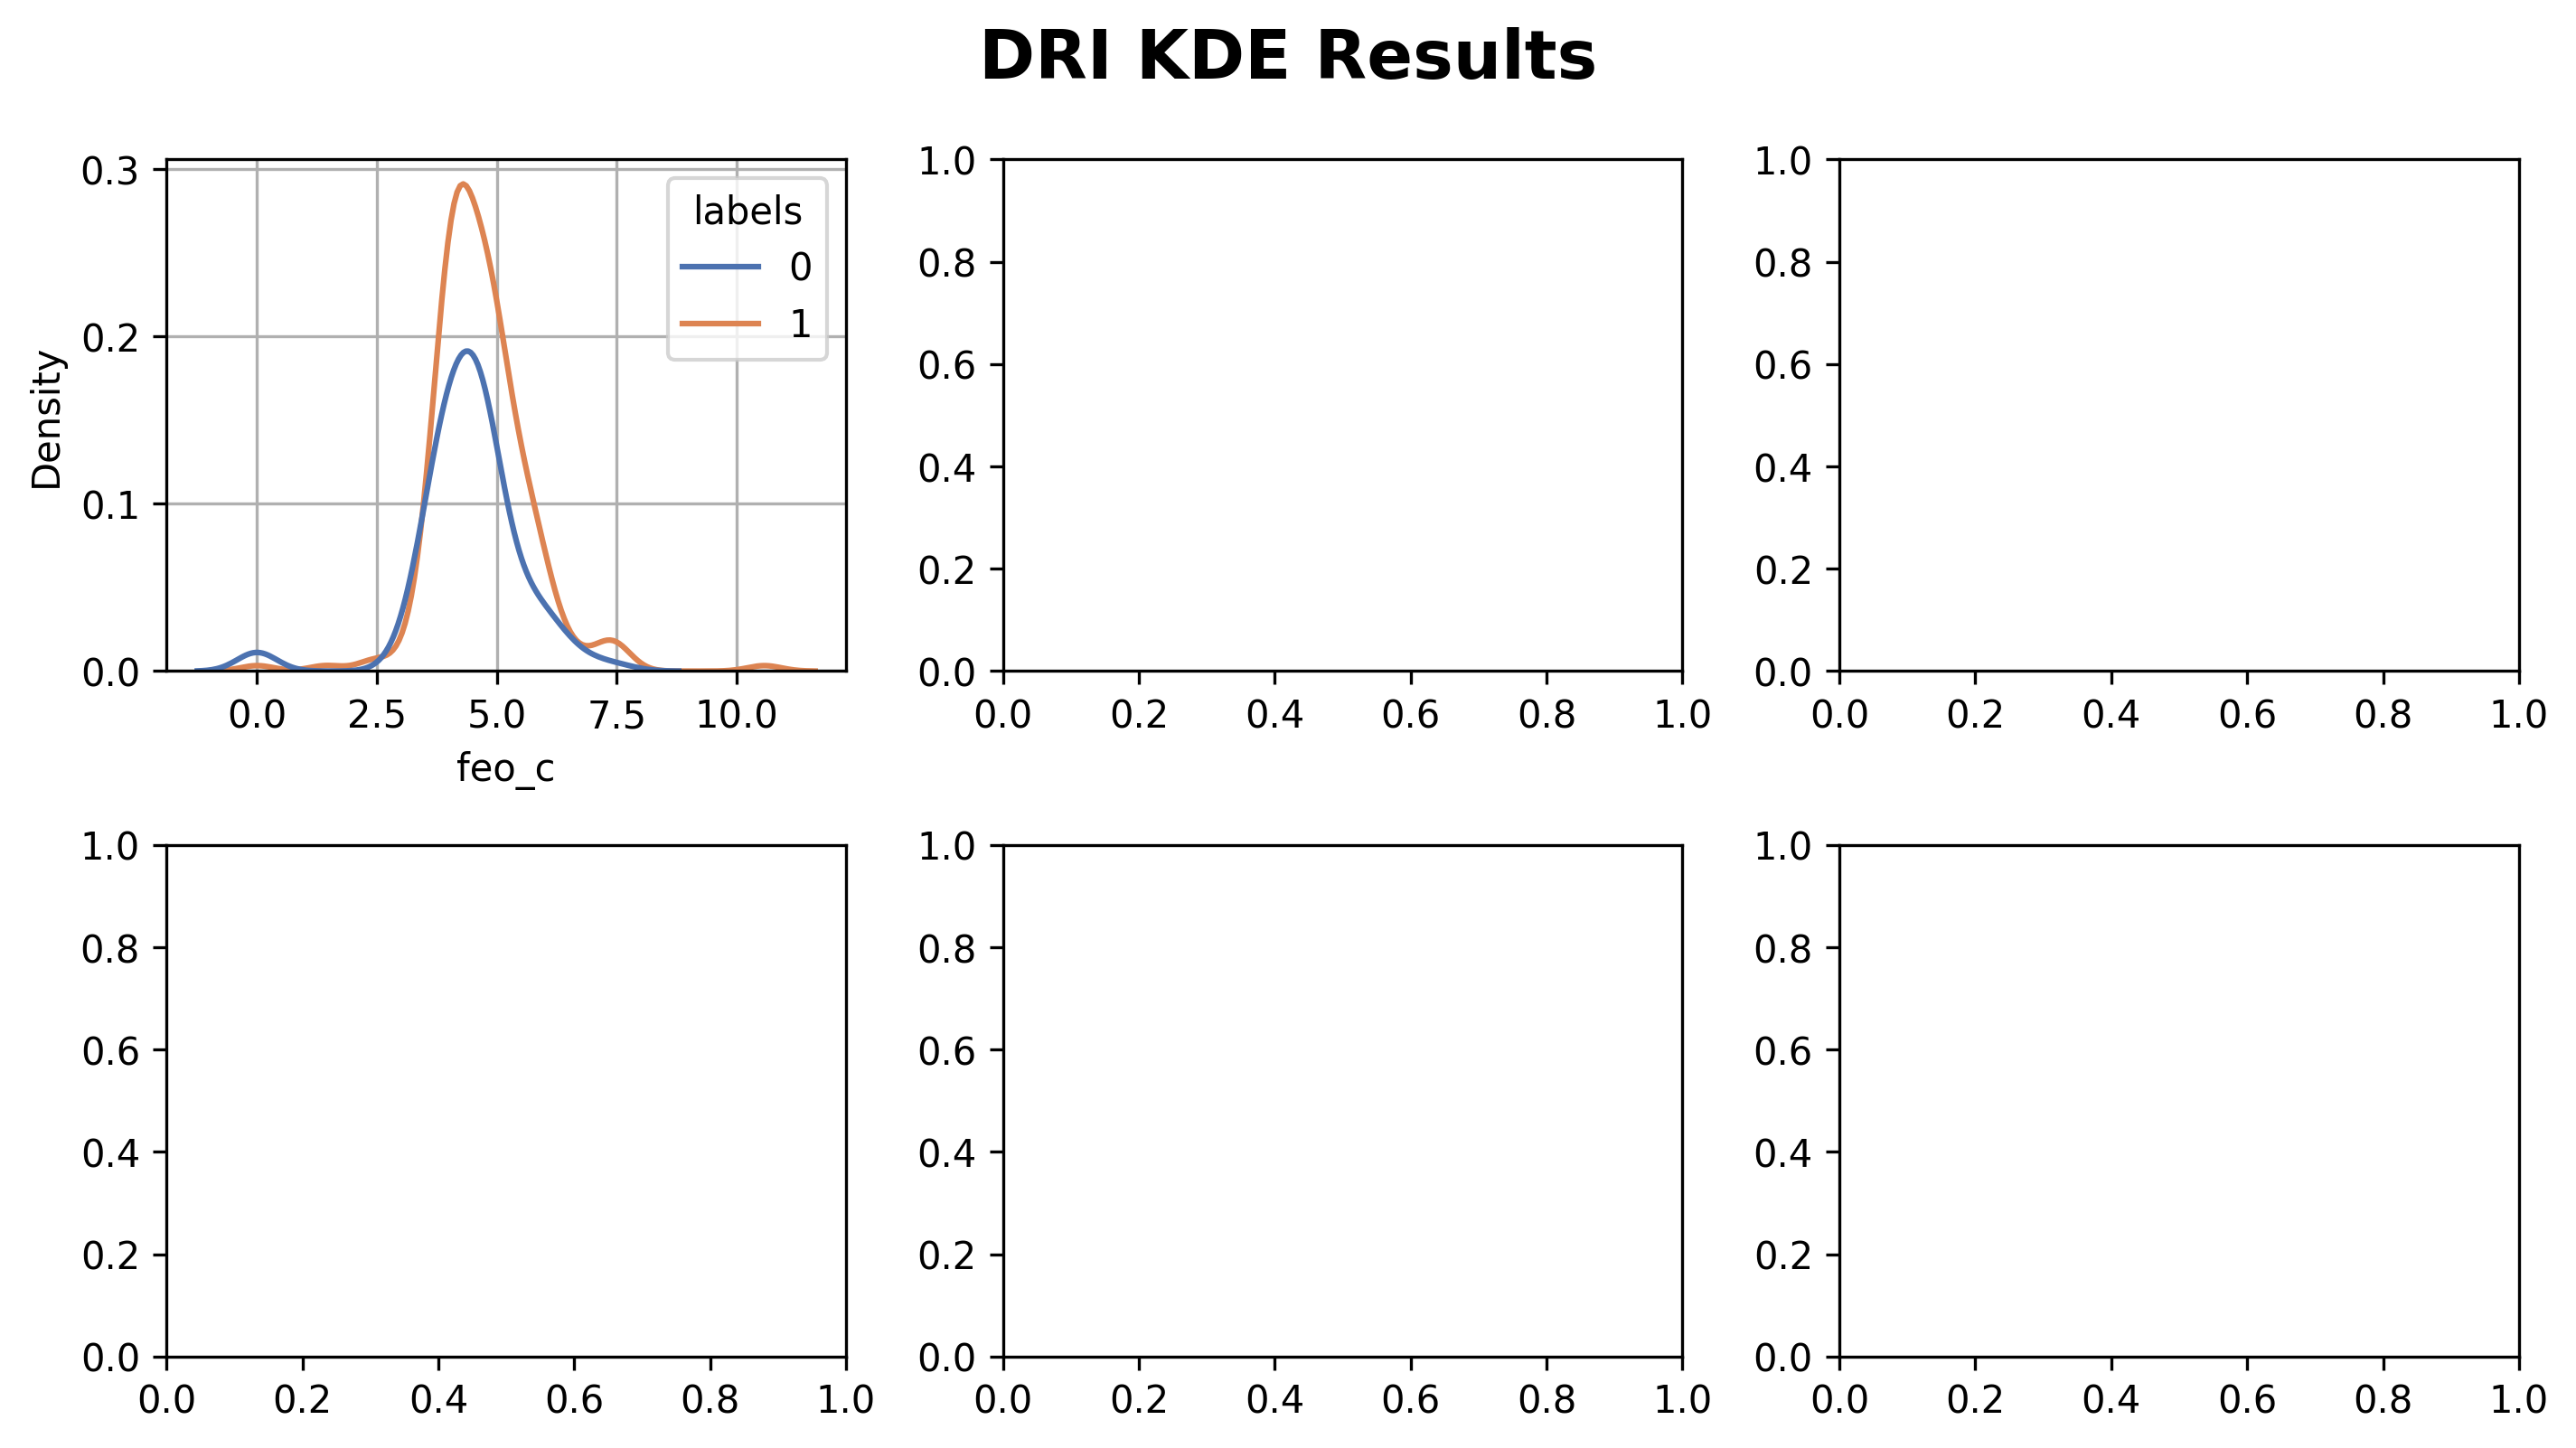

In [11]:
df = pd.read_csv(f"{working_dir}/data/dri.csv")
df.set_index(keys='tar', inplace=True ,drop=True)
print(df.shape)
#--------Normalizing-------- 
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
print(normal_df.shape)
#--------Correlation--------
corr_df = normal_df.corr().abs()
corr_df = corr_df.where(np.triu(np.ones(corr_df.shape),k= 1).astype(bool)) #paiine matice motegharen ast ve hazf shod
high_corr_columns_name = pd.DataFrame(corr_df.ge(.95).stack().loc[lambda corr_df: corr_df].index.to_list())
print(high_corr_columns_name)
#df.drop(labels=['s315'] ,axis=1,inplace=True)
#-------Clustering---------
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
t_sne = TSNE(n_components=2, learning_rate='auto',random_state=0,
                  init='random', perplexity=50)
data=t_sne.fit_transform(normal_df)
sne_column_name = [f"SNE{column}"  for column in range(2) ]
sne_df = pd.DataFrame(data=data,columns=sne_column_name)
print(sne_df.shape)
model = AgglomerativeClustering(n_clusters = 2, metric= 'euclidean', linkage ='average')
model.fit(sne_df)
print(model.labels_.shape)
# ---------PLOT-------------
fig = plt.figure(figsize=(9.6,5.4),dpi=300)
fig.suptitle('DRI T-SNE Clusters', fontsize=18,fontweight='bold')
ax1 = fig.subplots(1,1)
ax1.set_xlabel('Axis0', fontsize=16,fontweight='bold')
ax1.set_ylabel('Axis1', fontsize=16,fontweight='bold')
#ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
cmap = sns.color_palette("deep", as_cmap=True)
sns.scatterplot(
    data=sne_df,
    x='SNE0',
    y='SNE1',
    hue=model.labels_,
    palette= cmap,
    )
fig.tight_layout()
plt.savefig(f'{working_dir}/presentation/dri-tsne-clusters.jpg')
plt.show()
#----------Labeling---------
clust_lable_dict = {0:1,1:0,2:2}
labels = [clust_lable_dict[i] for i in model.labels_]
df["labels"] = labels
print(df.shape)
#----------Labes Conditions-----
plot_name = df.columns.drop('labels')
print(plot_name)
num = 0
for k in range(3):
    fig = plt.figure(num=k,figsize=(9.6,5.4),dpi=300)
    fig.suptitle('DRI KDE Results', fontsize=18,fontweight='bold')
    ax = fig.subplots(2,3)
    #sns.set_style("ticks",{'axes.grid' : True})
    for i in range(2):
        for j in range(3):
            if num == len(plot_name):
                break
            ax[i][j].grid(True)
            sns.kdeplot(
                data=df,
                x=plot_name[num],
                hue="labels",
                #hue_order=[0,2,3,],
                fill=False,
                #alpha = 0.4,
                palette= cmap,
                ax=ax[i][j],
            )
            num = num +1
    fig.tight_layout()
    plt.savefig(f'{working_dir}/presentation/dri-kde-results{k}.jpg')
plt.show()

# save For next use
df.to_csv(f"{working_dir}/data/dri_with_labels.csv",index=True)
del df,normal_df,corr_df,high_corr_columns_name

<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
7- خواندن دیتاهای خام مربوط به سرباره
</b>
</div>

In [12]:
df = pd.read_csv(f"{working_dir}/Raw-Data/slag_Lab.csv",encoding='latin-1' )
print(f"size of raw data = {df.shape}")
#Filter Tarikh
df = df[df['tar'] >= 14020915]
print(f"from 14020915 to 14030915 = {df.shape}")
print(df.describe())
#save prepared data for next
df.to_csv(f"{working_dir}/data/slag.csv",index=False)
#remove dataframe from memory
del df

size of raw data = (7140, 12)
from 14020915 to 14030915 = (1649, 12)
                tar       heat_no          cao          feo         sio2  \
count  1.649000e+03  1.649000e+03  1649.000000  1649.000000  1649.000000   
mean   1.402799e+07  4.030588e+06    26.811825    30.949303    22.122317   
std    4.184968e+03  3.254414e+03     3.569229     7.242999     2.864348   
min    1.402092e+07  4.024660e+06    13.100000    13.200000    12.800000   
25%    1.402122e+07  4.026355e+06    24.500000    25.800000    20.100000   
50%    1.403032e+07  4.031540e+06    27.000000    30.700000    22.100000   
75%    1.403070e+07  4.033213e+06    29.300000    35.700000    24.200000   
max    1.403092e+07  4.034580e+06    36.000000    60.000000    29.900000   

               mgo        al2o3         p2o5          mno           b2  \
count  1649.000000  1649.000000  1649.000000  1649.000000  1649.000000   
mean     10.152274     4.303457     0.787596     0.210795     1.218029   
std       1.493017     0

<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
1-7 - خوشه بندی داده 
</b>
</div>

(1649, 10)
(1649, 10)
    0   1
0  b2  b3
(1649, 2)
(1649,)


/tmp/ipykernel_1519/3789214646.py:34: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


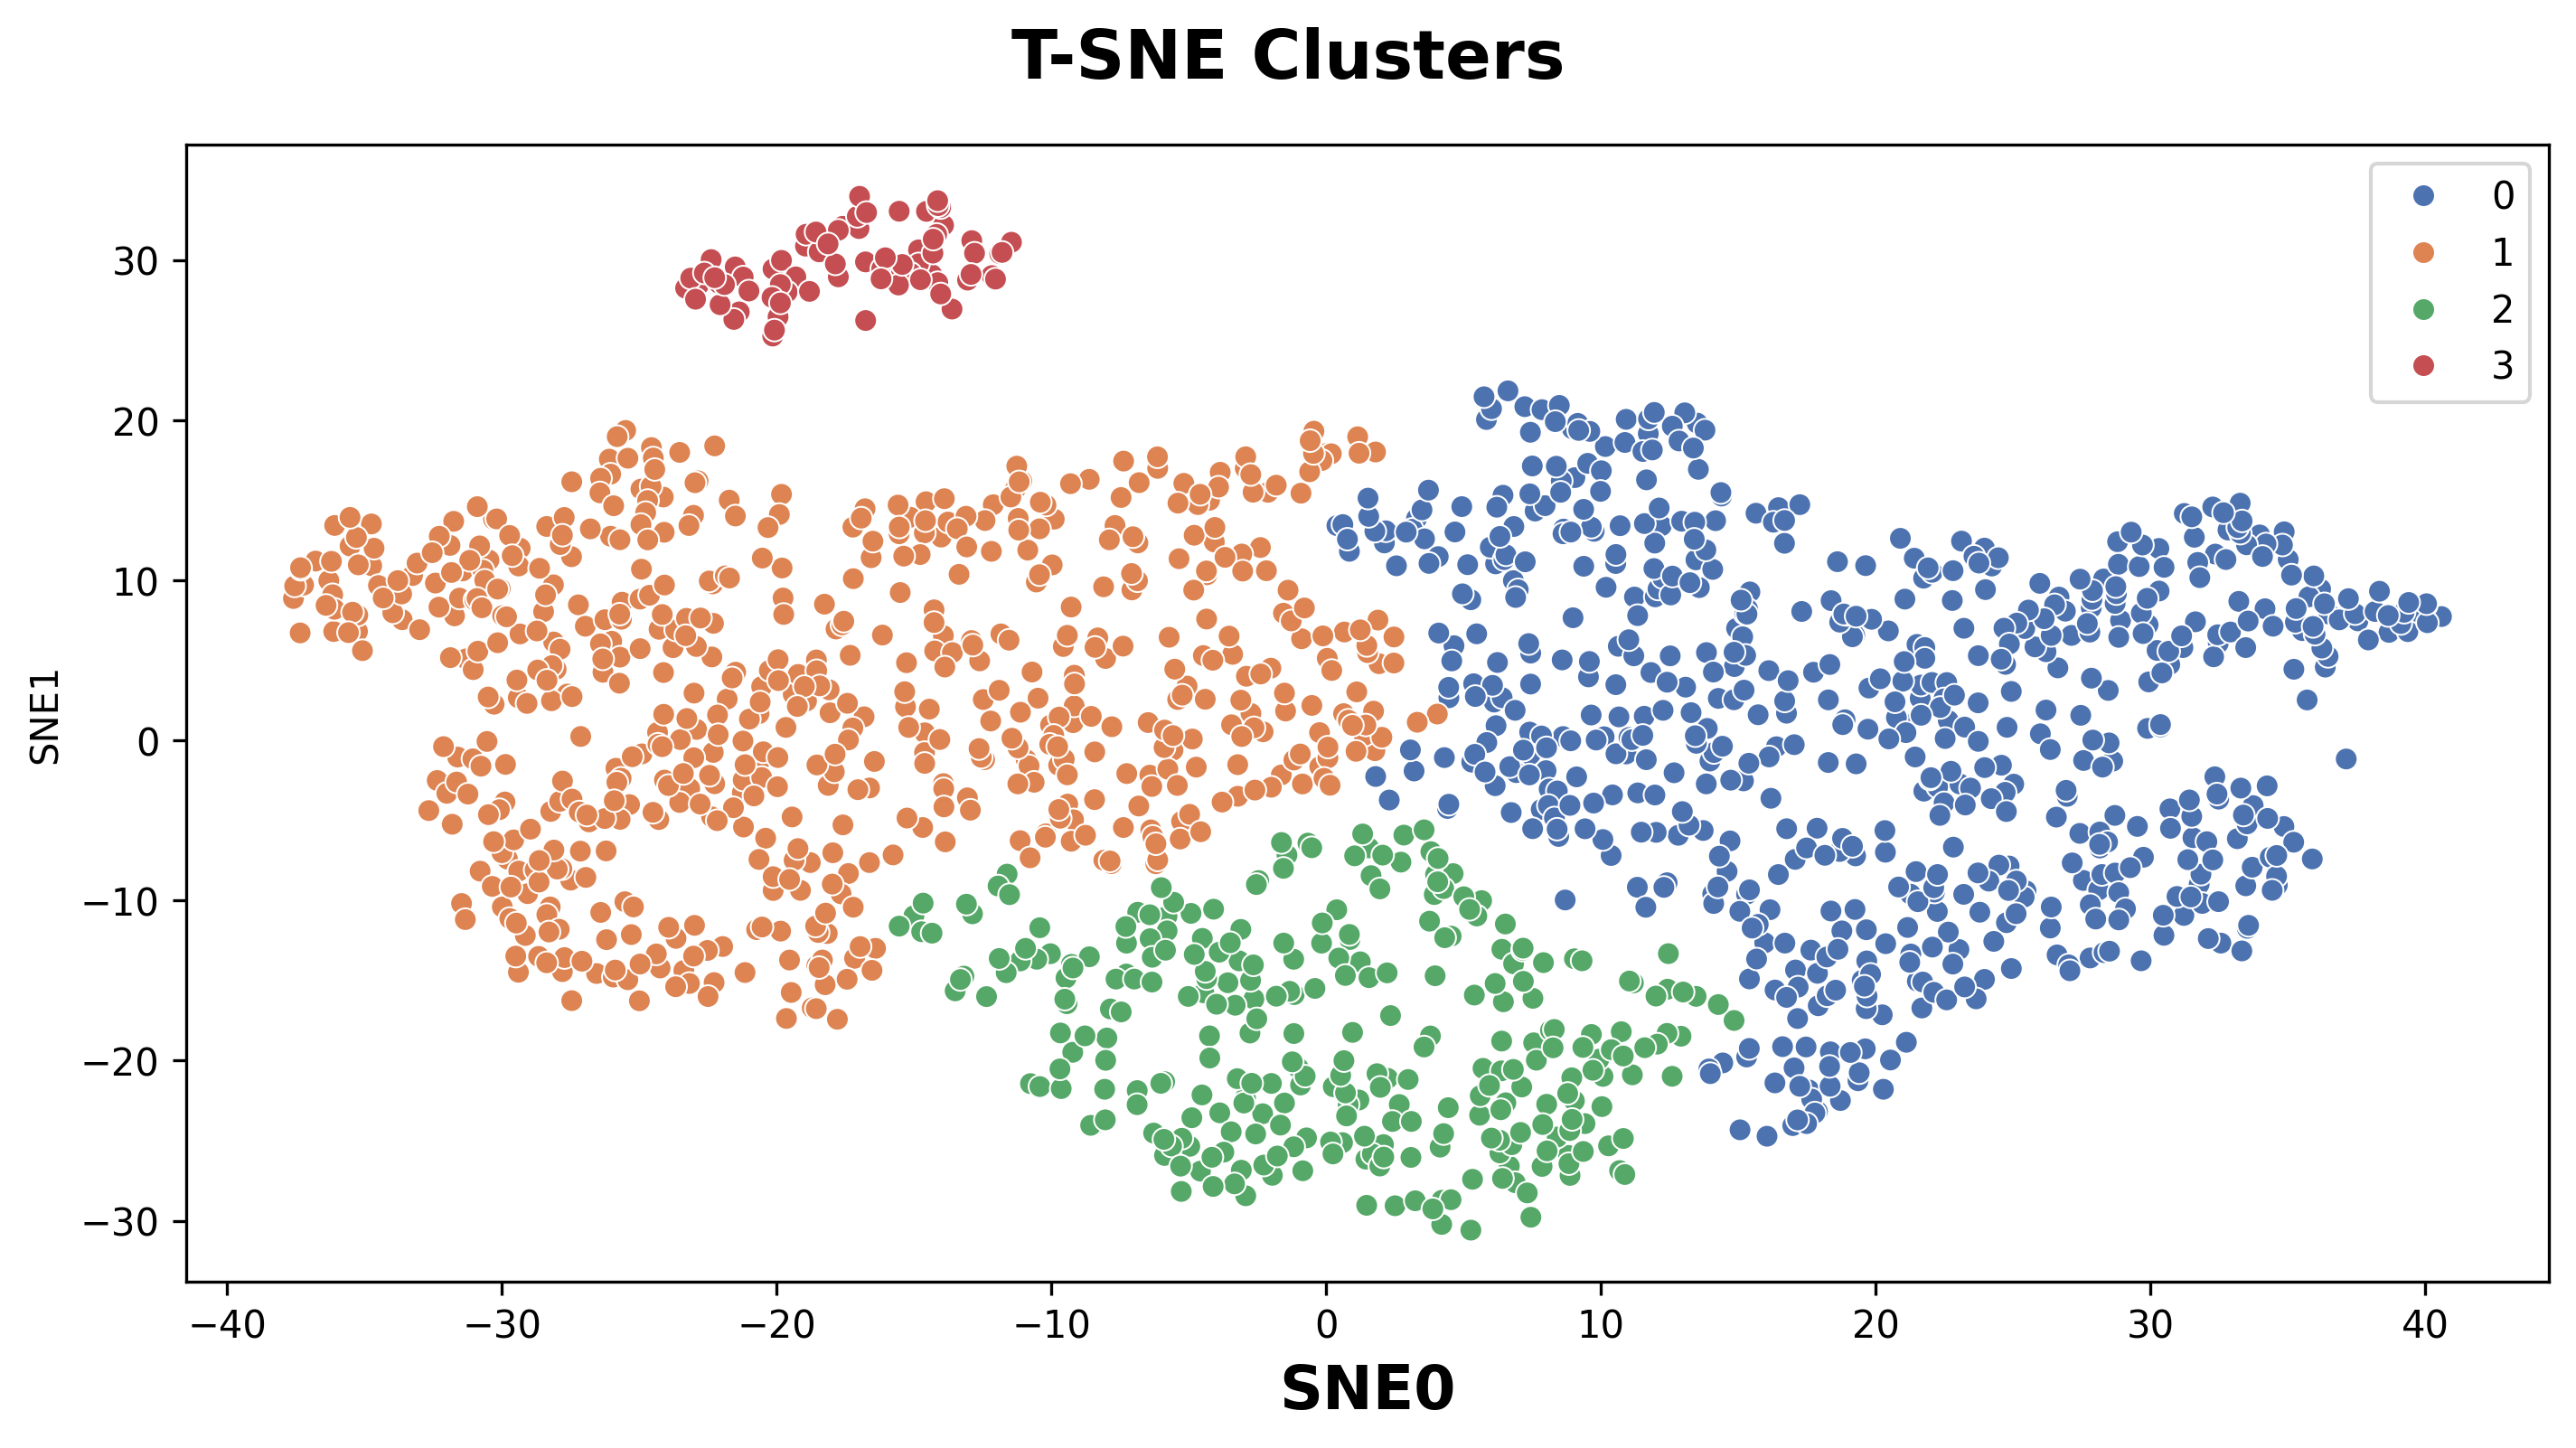

(1649, 11)
Index(['cao', 'feo', 'sio2', 'mgo', 'al2o3', 'p2o5', 'mno', 'b2', 'b3', 'b4'], dtype='object')


/tmp/ipykernel_1519/3789214646.py:63: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/3789214646.py:63: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/3789214646.py:63: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/3789214646.py:63: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/3789214646.py:63: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/3789214646.py:63: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/3789214646.py:63: UserWarning: The palette list has more values (10) than needed (4), which 

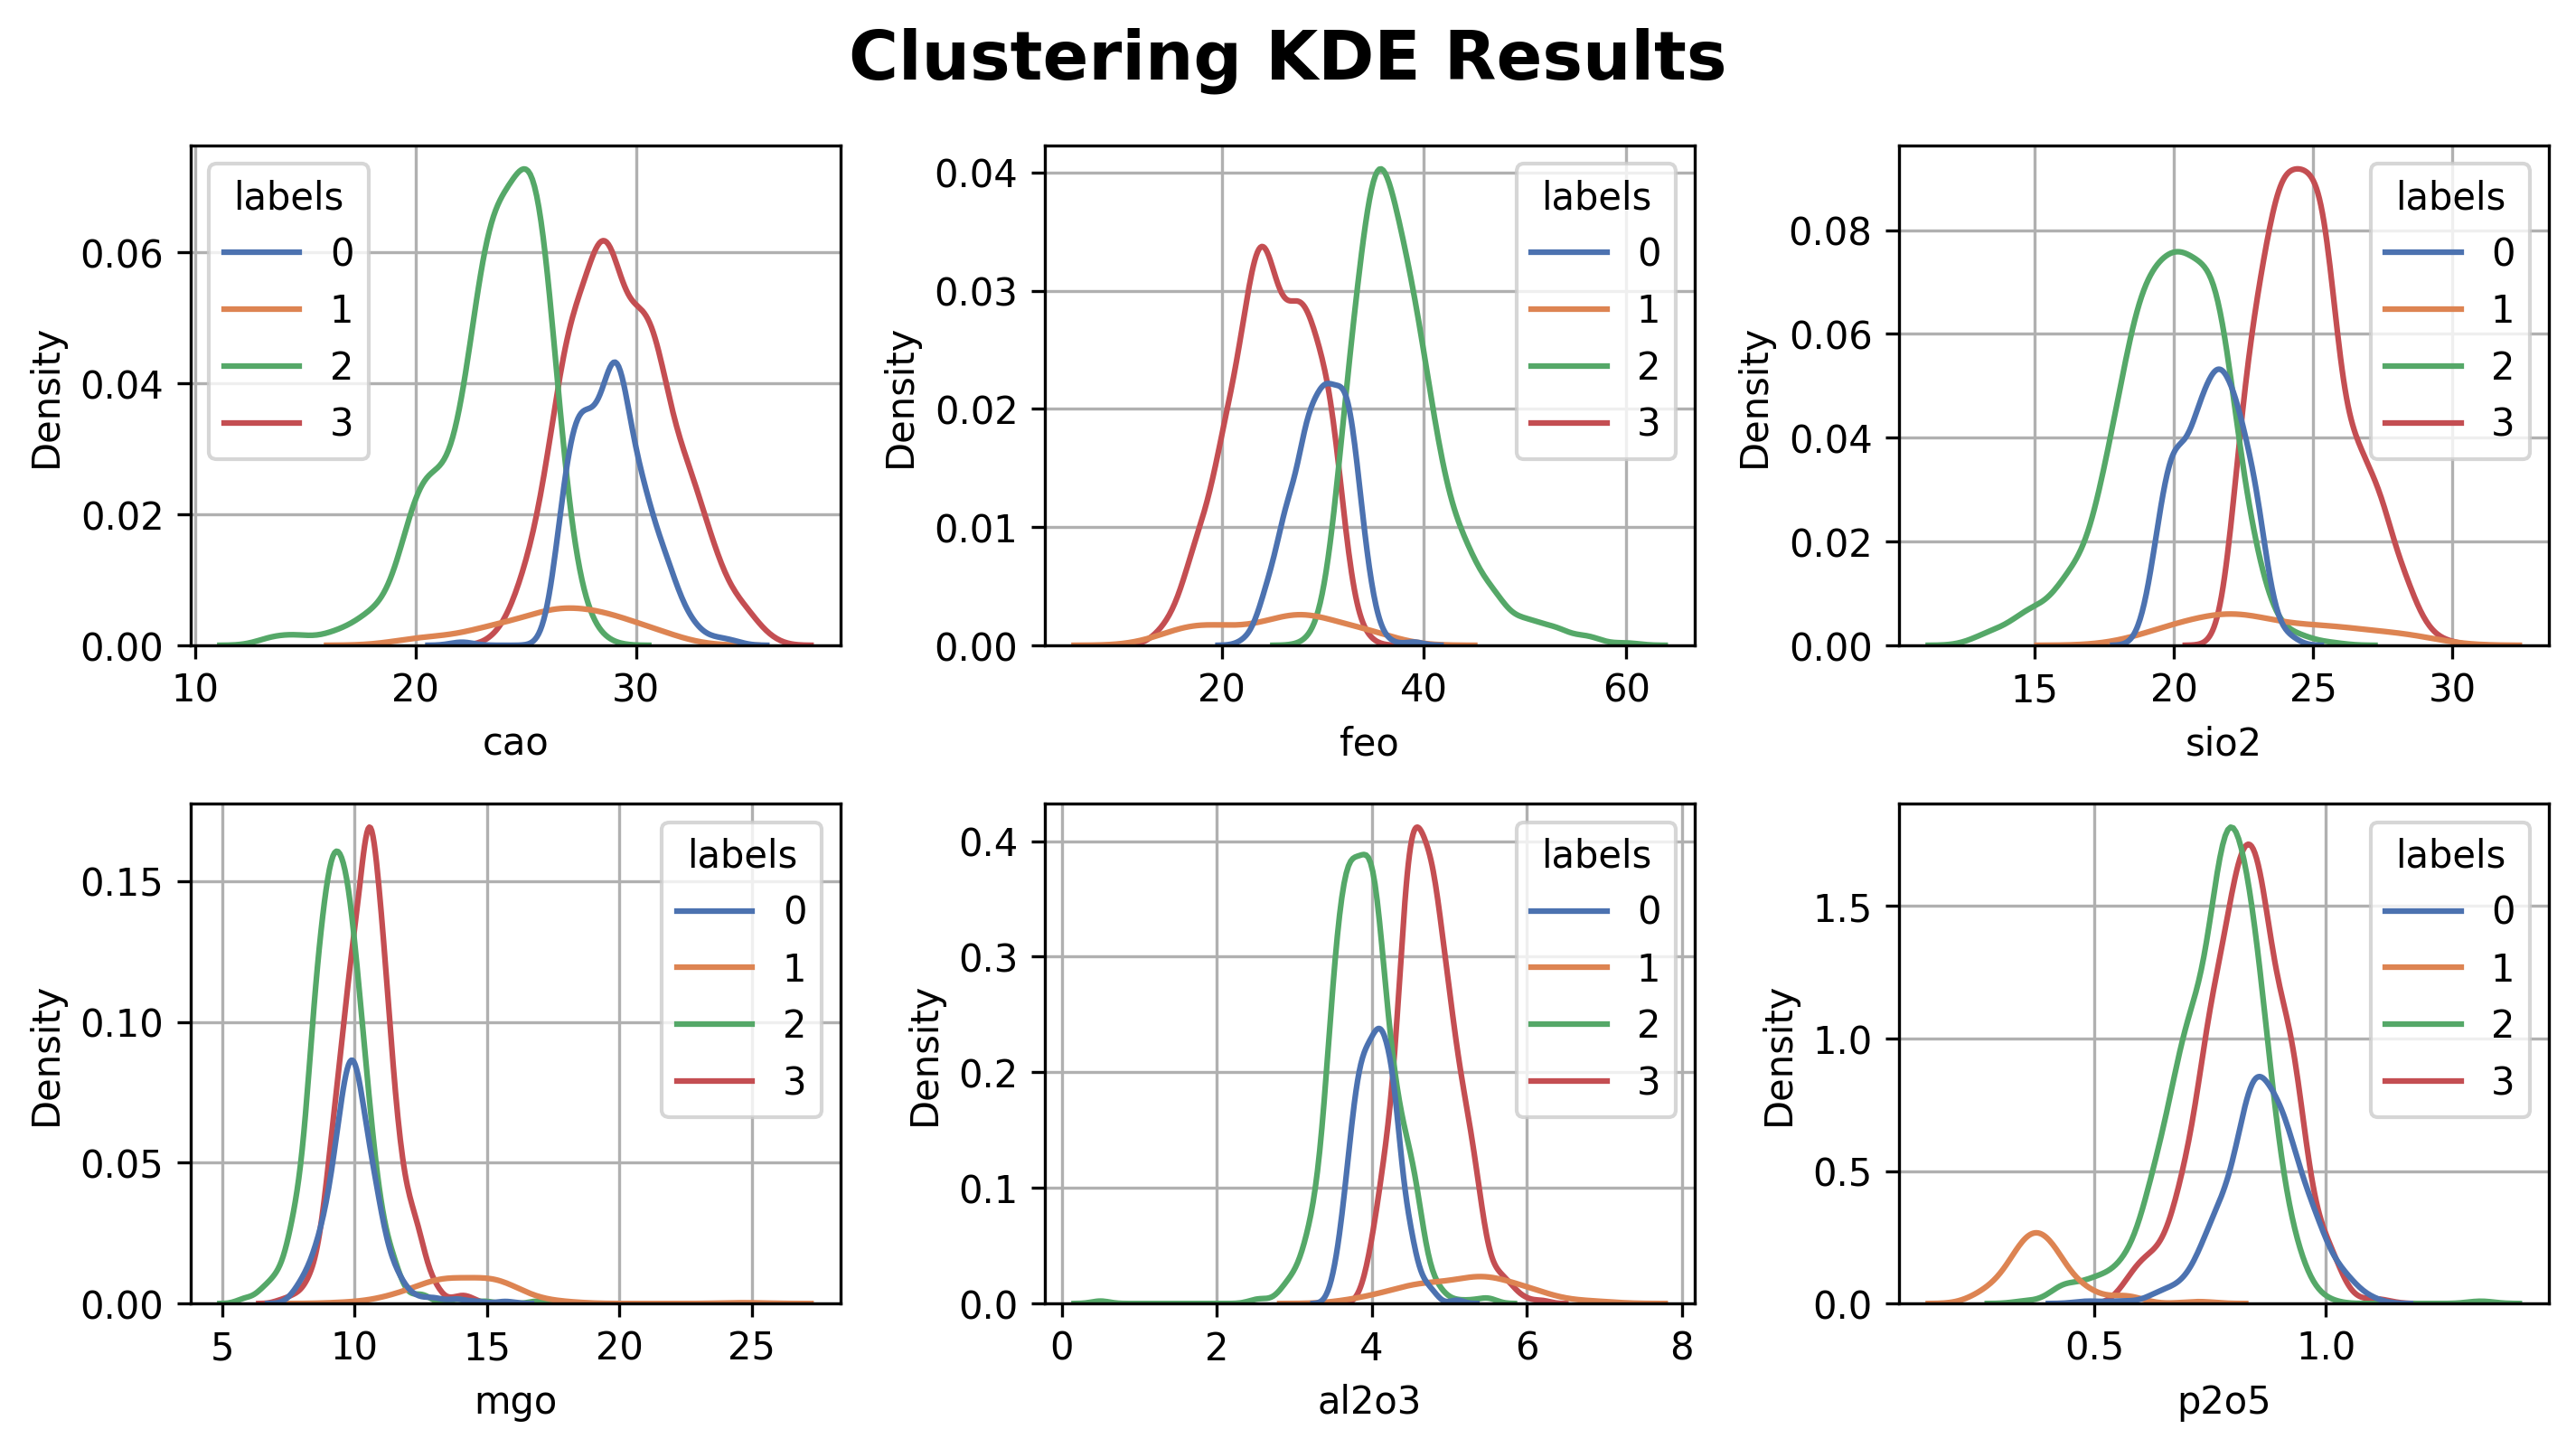

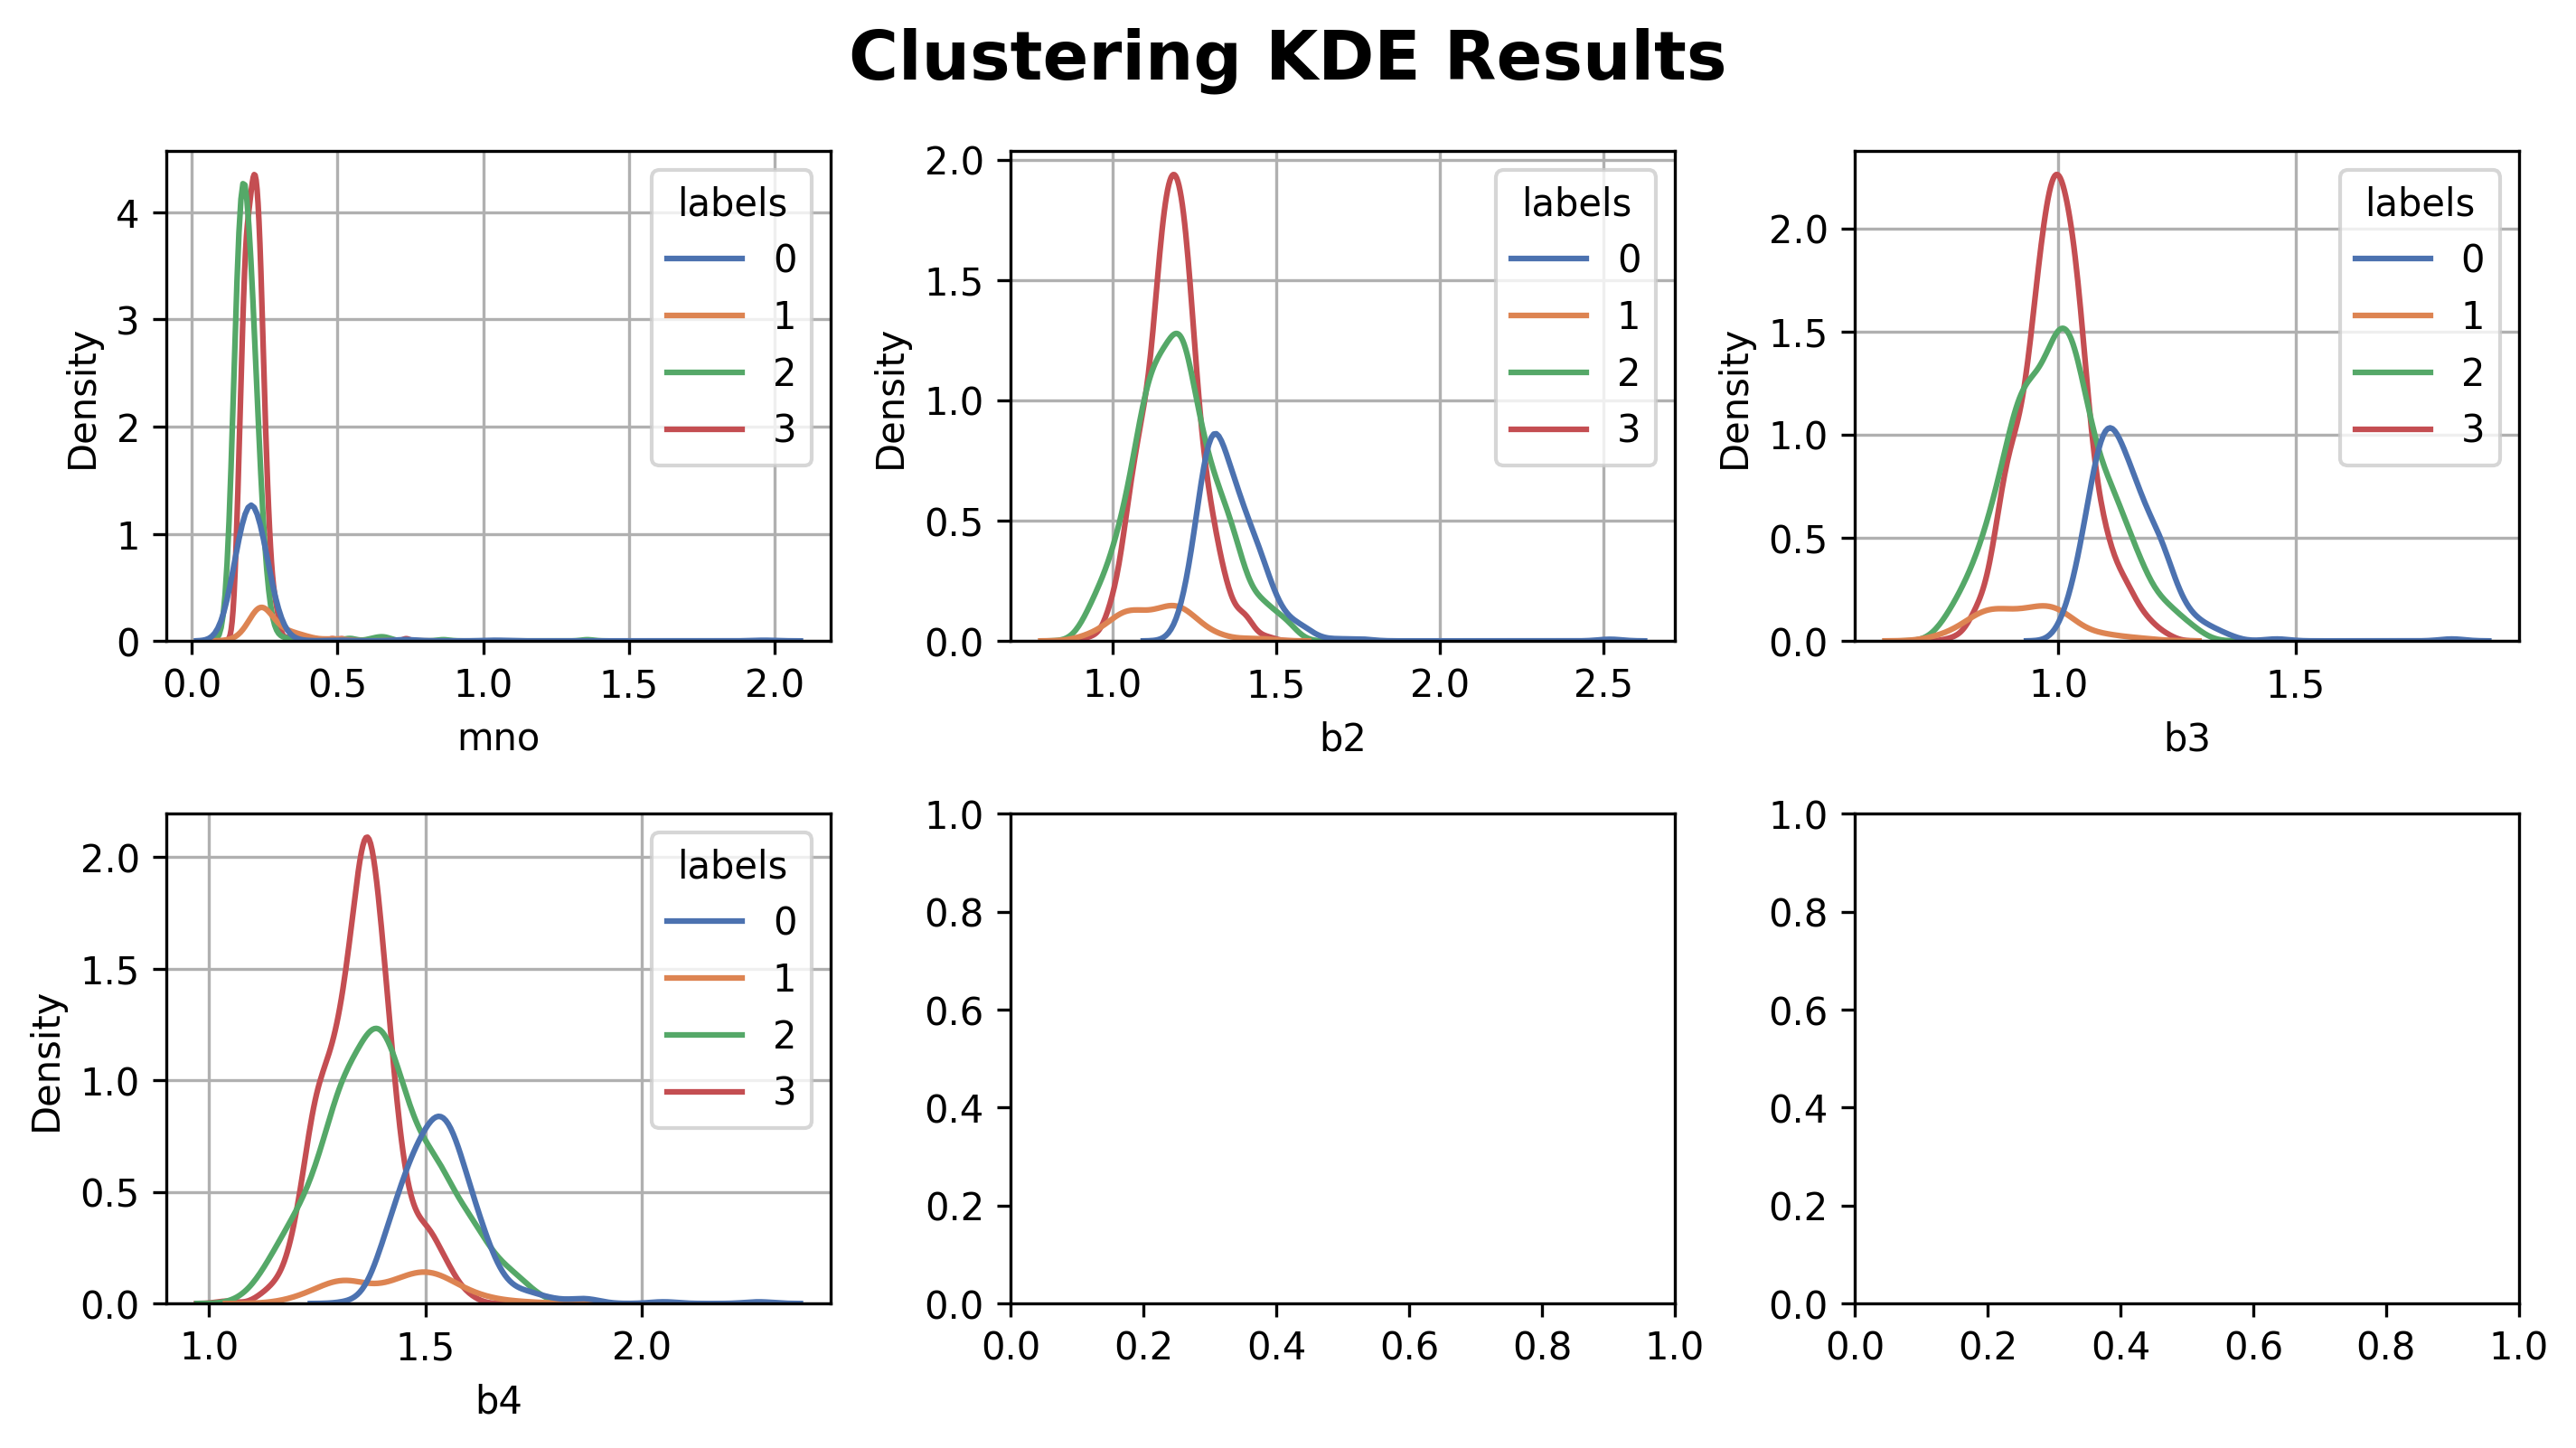

In [13]:
df = pd.read_csv(f"{working_dir}/data/slag.csv")
df.set_index(keys='heat_no', inplace=True ,drop=True)
df.drop(labels=['tar'],axis=1,inplace=True)
print(df.shape)
#--------Normalizing-------- 
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
print(normal_df.shape)
#--------Correlation--------
corr_df = normal_df.corr().abs()
corr_df = corr_df.where(np.triu(np.ones(corr_df.shape),k= 1).astype(bool)) #paiine matice motegharen ast ve hazf shod
high_corr_columns_name = pd.DataFrame(corr_df.ge(.95).stack().loc[lambda corr_df: corr_df].index.to_list())
print(high_corr_columns_name)
#df.drop(labels=['s315'] ,axis=1,inplace=True)
#-------Clustering---------
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
t_sne = TSNE(n_components=2, learning_rate='auto',random_state=0,
                  init='random', perplexity=50)
data=t_sne.fit_transform(normal_df)
sne_column_name = [f"SNE{column}"  for column in range(2) ]
sne_df = pd.DataFrame(data=data,columns=sne_column_name)
print(sne_df.shape)
model = AgglomerativeClustering(n_clusters = 4, metric= 'euclidean', linkage ='average')
model.fit(sne_df)
print(model.labels_.shape)
# ---------PLOT-------------
fig = plt.figure(figsize=(9.6,5.4),dpi=300)
fig.suptitle('T-SNE Clusters', fontsize=18,fontweight='bold')
ax1 = fig.subplots(1,1)
ax1.set_xlabel('SNE0', fontsize=16,fontweight='bold')
#ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
cmap = sns.color_palette("deep", as_cmap=True)
sns.scatterplot(
    data=sne_df,
    x='SNE0',
    y='SNE1',
    hue=model.labels_,
    palette= cmap,
    )
fig.tight_layout()
#plt.savefig(f'{working_dir}/presentation/C5000 Amp VS O2 purity.jpg')
plt.show()
#----------Labeling---------
clust_lable_dict = {0:2,1:3,2:0,3:1,4:4}
labels = [clust_lable_dict[i] for i in model.labels_]
df["labels"] = labels
print(df.shape)
#----------Labes Conditions-----
plot_name = df.columns.drop(['labels'])
print(plot_name)
num = 0
for k in range(2):
    fig = plt.figure(num=k,figsize=(9.6,5.4),dpi=300)
    fig.suptitle('Clustering KDE Results', fontsize=18,fontweight='bold')
    ax = fig.subplots(2,3)
    #sns.set_style("ticks",{'axes.grid' : True})
    for i in range(2):
        for j in range(3):
            if num == len(plot_name):
                break
            ax[i][j].grid(True)
            sns.kdeplot(
                data=df,
                x=plot_name[num],
                hue="labels",
                #hue_order=['Slag_Grade_A','Slag_Grade_B','Slag_Grade_C','Slag_Grade_D'],
                fill=False,
                #alpha = 0.4,
                palette= cmap,
                ax=ax[i][j],
            )
            num = num +1
    fig.tight_layout()
plt.show()

# save For next use
df.to_csv(f"{working_dir}/data/slag_with_labels.csv",index=True)
del df,normal_df,corr_df,high_corr_columns_name

<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
8- خواندن دیتاهای خام مربوط به ذوب و کوره
</b>
</div>

In [14]:
def remove_hyphen(x):
    output = str(x).replace("-","")
    return int(output)


df = pd.read_csv(f"{working_dir}/Raw-Data/EAF Data.csv",encoding='latin-1' )
#drop twe row from end because its total reports
df.drop(df.tail(2).index,inplace = True)
print(f"size of raw data = {df.shape}")
#modify tarikh format to shape of other files and Drop Some Columns
df['tar_'] = df['Persian_Date'].apply(remove_hyphen)
df.insert(0, 'tar', df['tar_'])
df.drop(labels=['Row','Date','Persian_Date','tar_'],axis=1,inplace=True)
#Filter Tarikh
df = df[df['tar'] >= 14020915]
print(f"from 14020915 to 14030915 = {df.shape}")
# some rows have equal values
df = df.drop_duplicates(subset=['tar', 'Heat'], keep='last')
# filter only dri and drop column
mask = df['Product Kind'] == 'ONLY_DRI'
df = df[mask]
df.drop(labels=['Product Kind'],axis=1,inplace=True)
# filter tapped (ton)
mask = df['Tapped [t]'].between(170,200)
df = df[mask]
# filter tapping time(sec)
mask = df['Tapping Time [Sec]'] <= 600
df = df[mask]
# filter melting without scrap and drop column
mask = df['Scarp [t]'] == 0
df = df[mask]
df.drop(labels=['# Bucket','Scarp [t]','CaO.inj [kg]','Grade','Start','End','Last Temp [kWh/t]','Last Temp [C]','First Temp','First C','Ele [kWh]','Ele [kWh/t]'],axis=1,inplace=True)
# filter duration 
mask = df['Duration'].between(40,70)
df = df[mask]
print(df.describe())
#save prepared data for next
df.to_csv(f"{working_dir}/data/eaf_data.csv",index=False)
#remove dataframe from memory
del df

size of raw data = (6587, 35)
from 14020915 to 14030915 = (6586, 33)
                tar          Heat     Duration     Power On    Power Off  \
count  3.317000e+03  3.317000e+03  3317.000000  3317.000000  3317.000000   
mean   1.402811e+07  4.030779e+06    62.702442    52.941815     9.265601   
std    4.139330e+03  3.257570e+03     4.084353     3.707643     2.895079   
min    1.402092e+07  4.024675e+06    48.000000    40.000000     4.000000   
25%    1.402122e+07  4.026445e+06    60.000000    51.000000     7.000000   
50%    1.403033e+07  4.031692e+06    63.000000    53.000000     8.000000   
75%    1.403072e+07  4.033502e+06    66.000000    56.000000    10.000000   
max    1.403092e+07  4.034594e+06    70.000000    63.000000    26.000000   

            Delays      DRI [t]     Ele [MW]   Tapped [t]  Tapped [kWh/t]  \
count  3317.000000  3317.000000  3317.000000  3317.000000     3317.000000   
mean      4.220078    60.656509   116.628628   176.370265      588.658579   
std       2.893

<div style="font-size: 14;color:red;font-size:25PX;font-family: arial;" align ="rigth" dir="rtl">
<b>
1-8 - خوشه بندی داده 
</b>
</div>

(3317, 18)
(3317, 18)
           0               1
0  Power Off          Delays
1    DRI [t]         EAF_DRI
2   O2 [Nm3]  Chemical [MWh]
(3317, 2)
(3317,)


/tmp/ipykernel_1519/1591570707.py:34: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


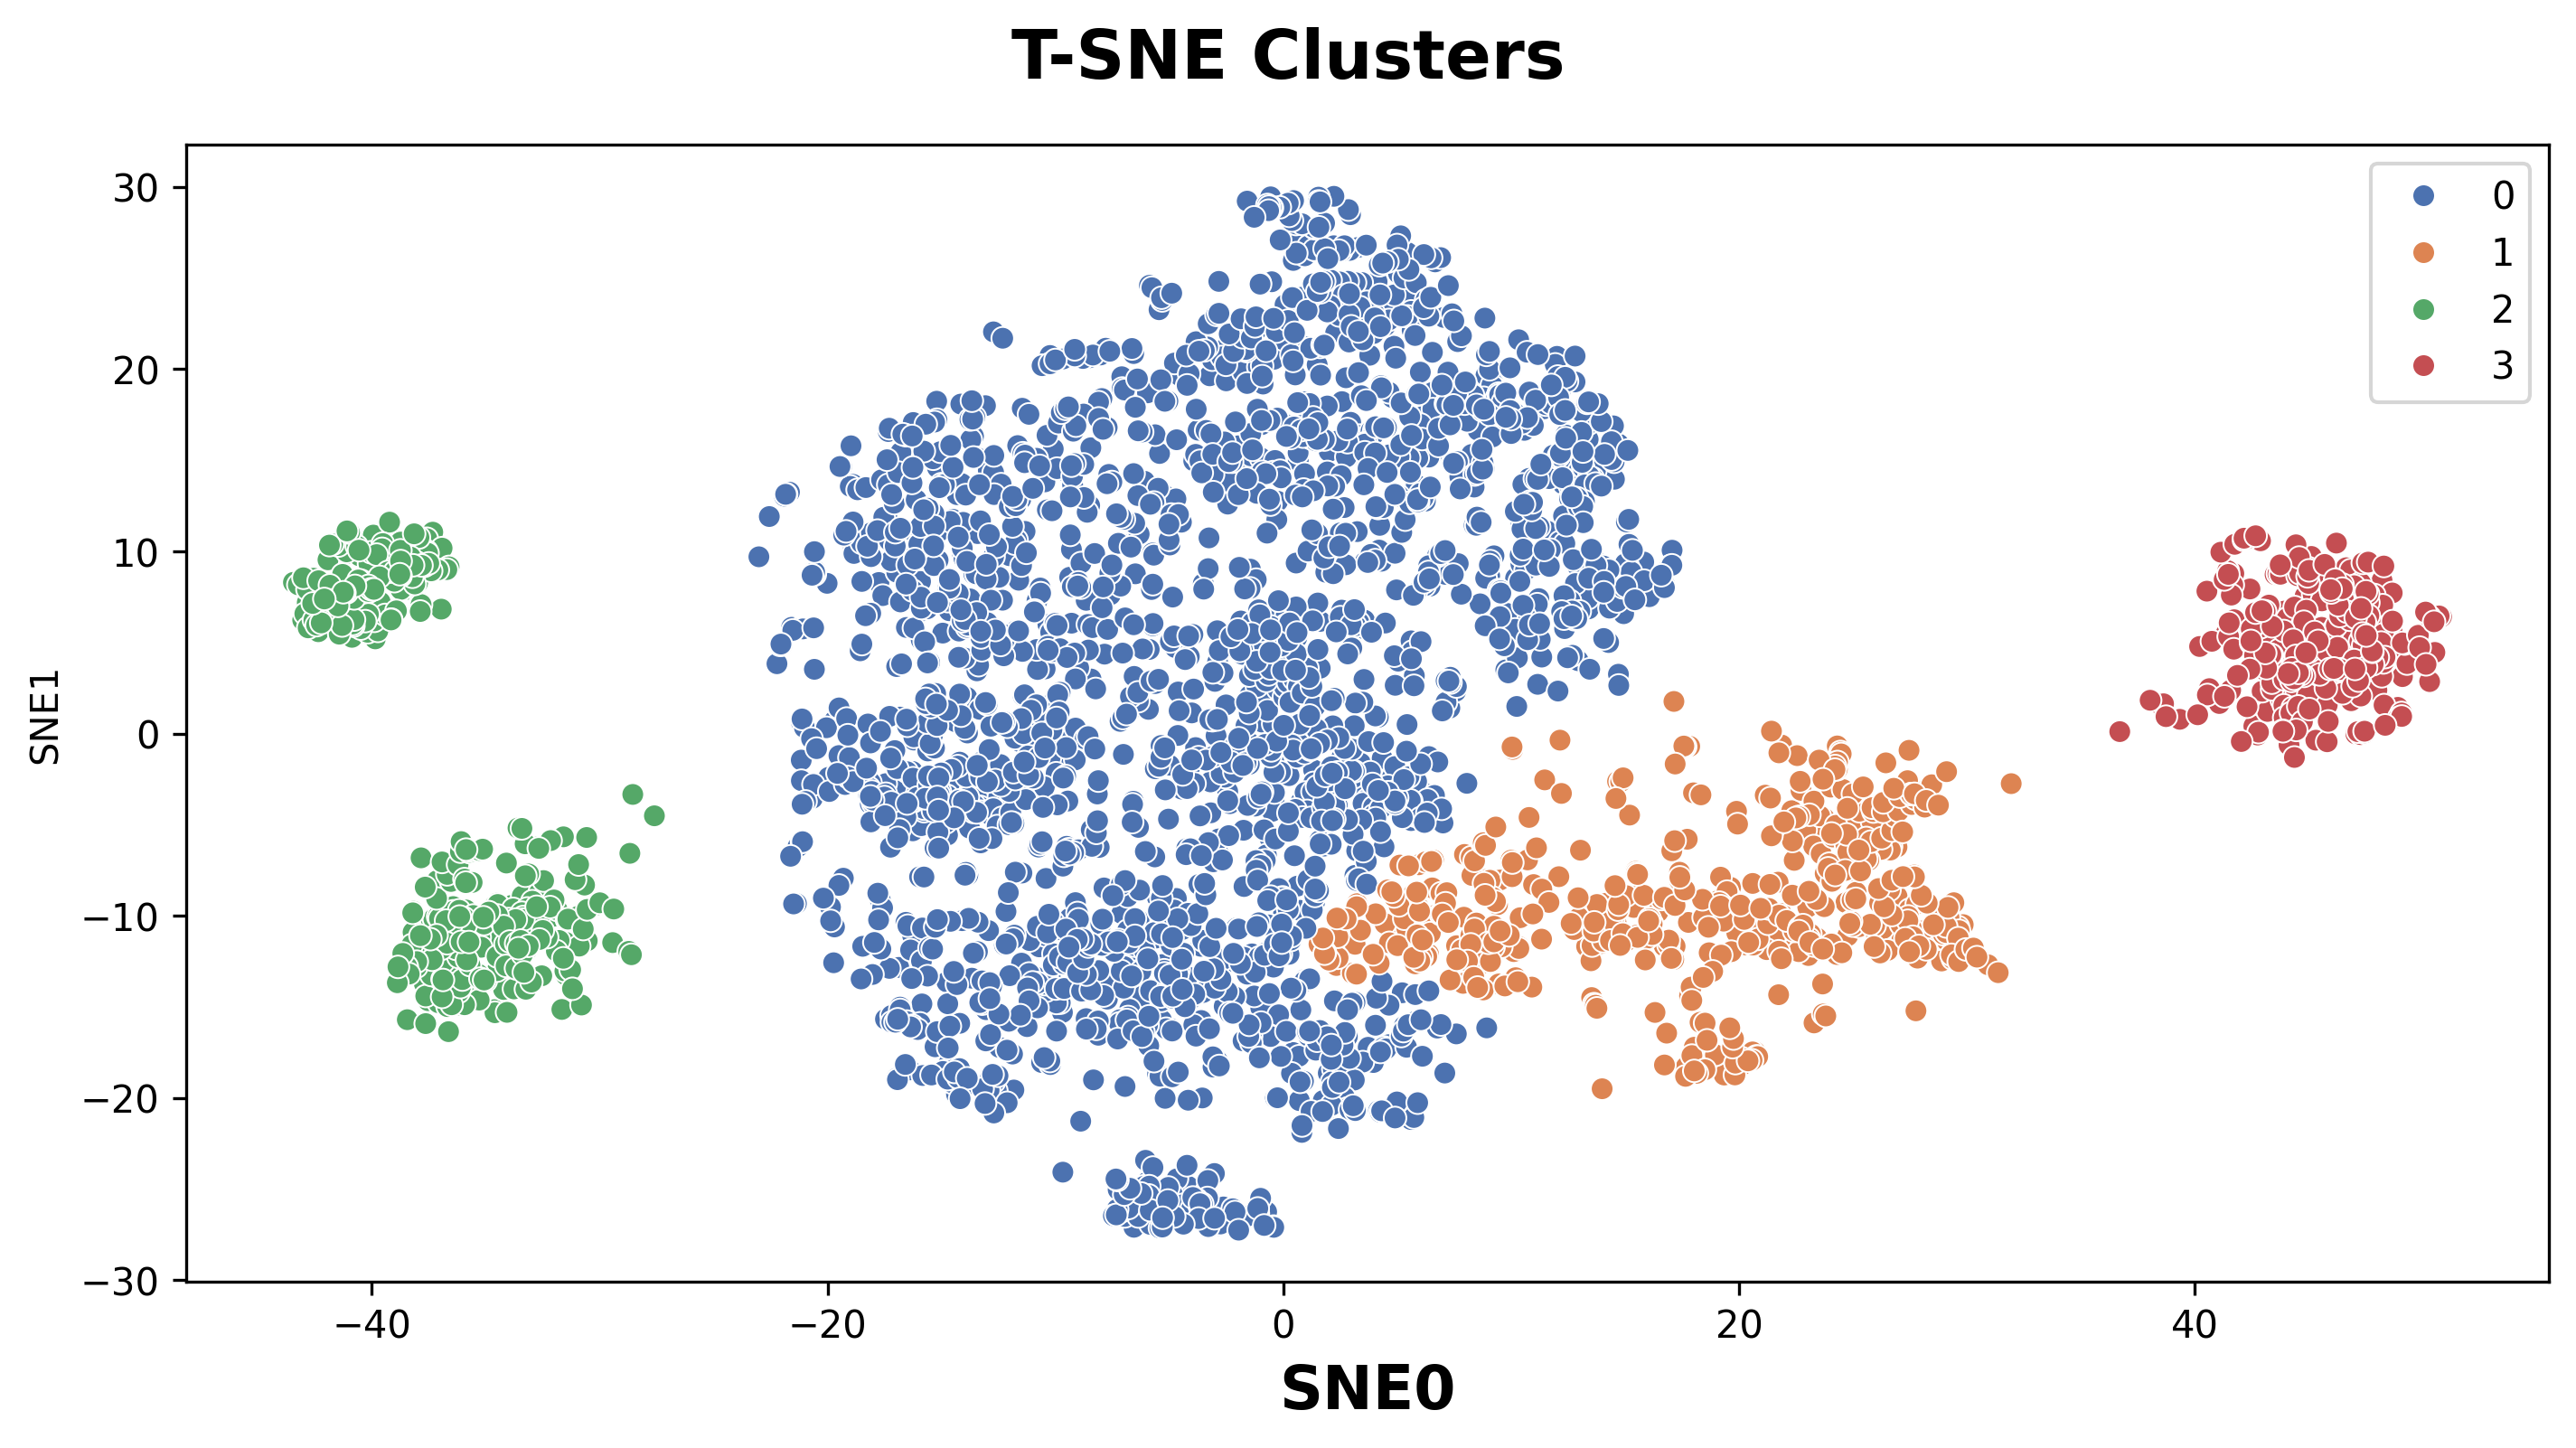

(3317, 16)
Index(['Duration', 'Power On', 'Power Off', 'DRI [t]', 'Ele [MW]',
       'Tapped [t]', 'Tapped [kWh/t]', 'O2 [Nm3]', 'CH4 [Nm3]', 'C.inj [kg]',
       'C [kg]', 'CaO [kg]', 'MgO [kg]', 'Tapping Time [Sec]', 'HDRI(T)'],
      dtype='object')


/tmp/ipykernel_1519/1591570707.py:63: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/1591570707.py:63: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/1591570707.py:63: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/1591570707.py:63: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/1591570707.py:63: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/1591570707.py:63: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
/tmp/ipykernel_1519/1591570707.py:63: UserWarning: The palette list has more values (10) than needed (4), which 

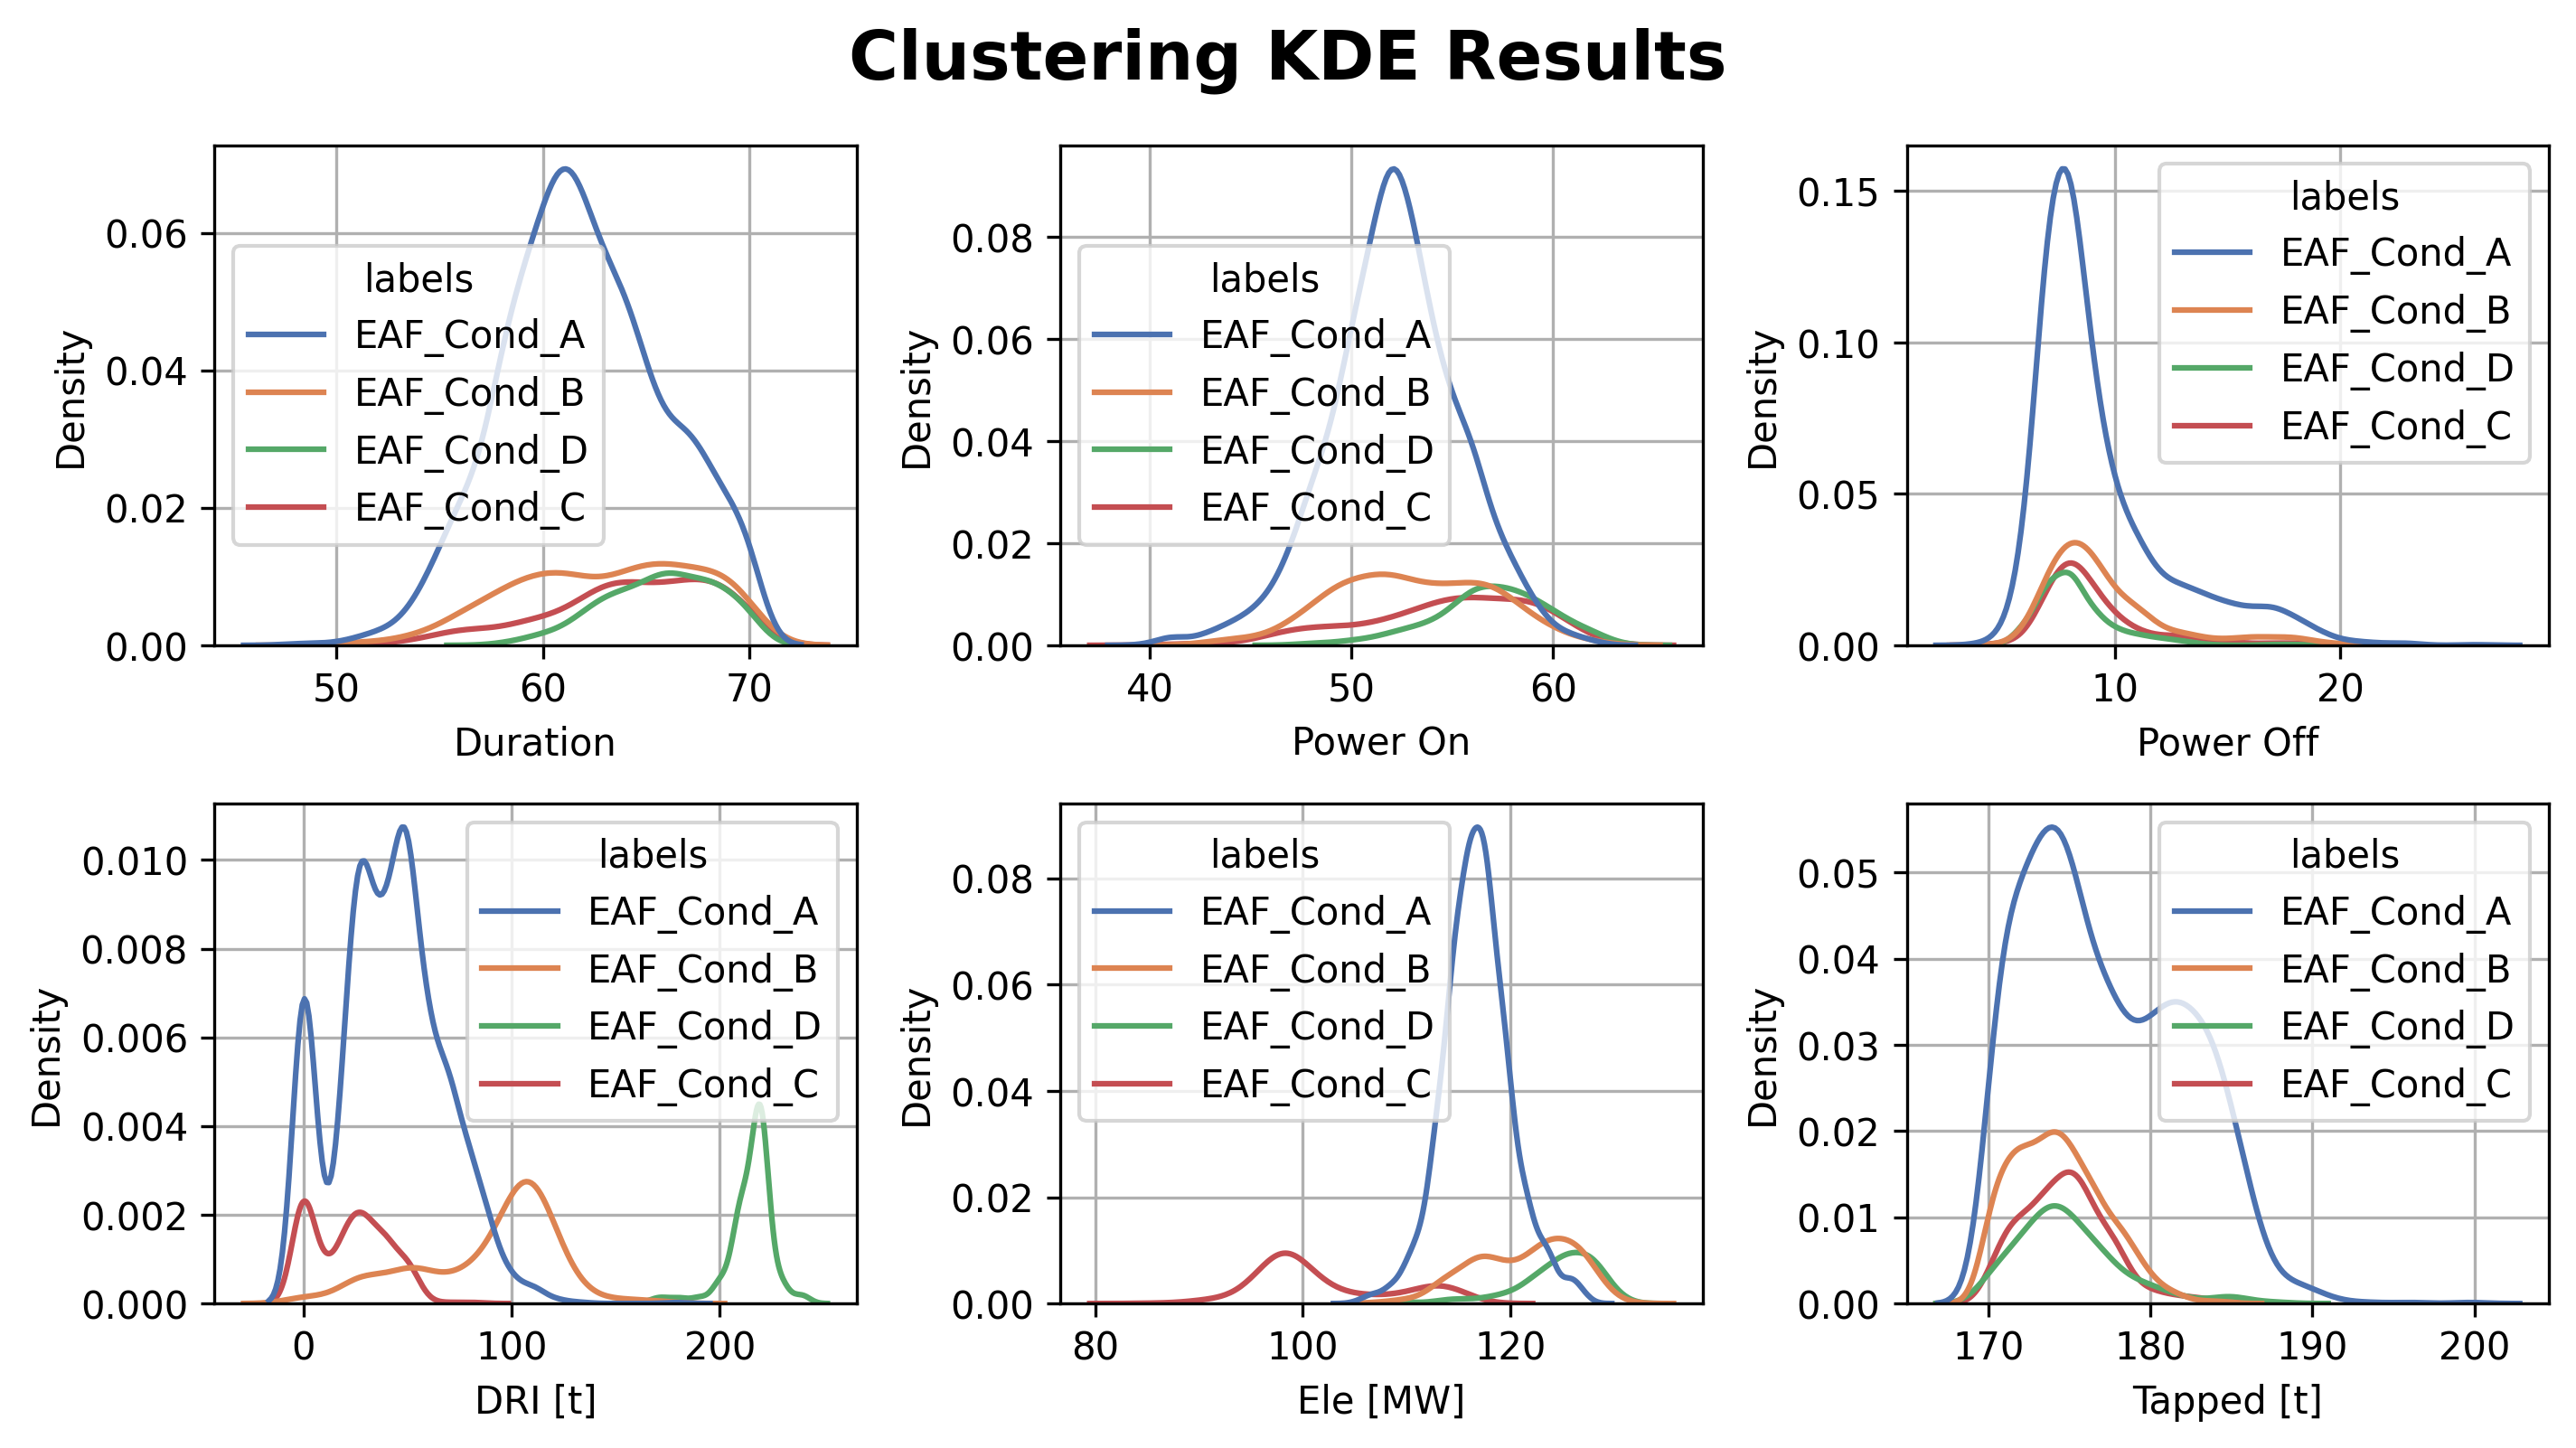

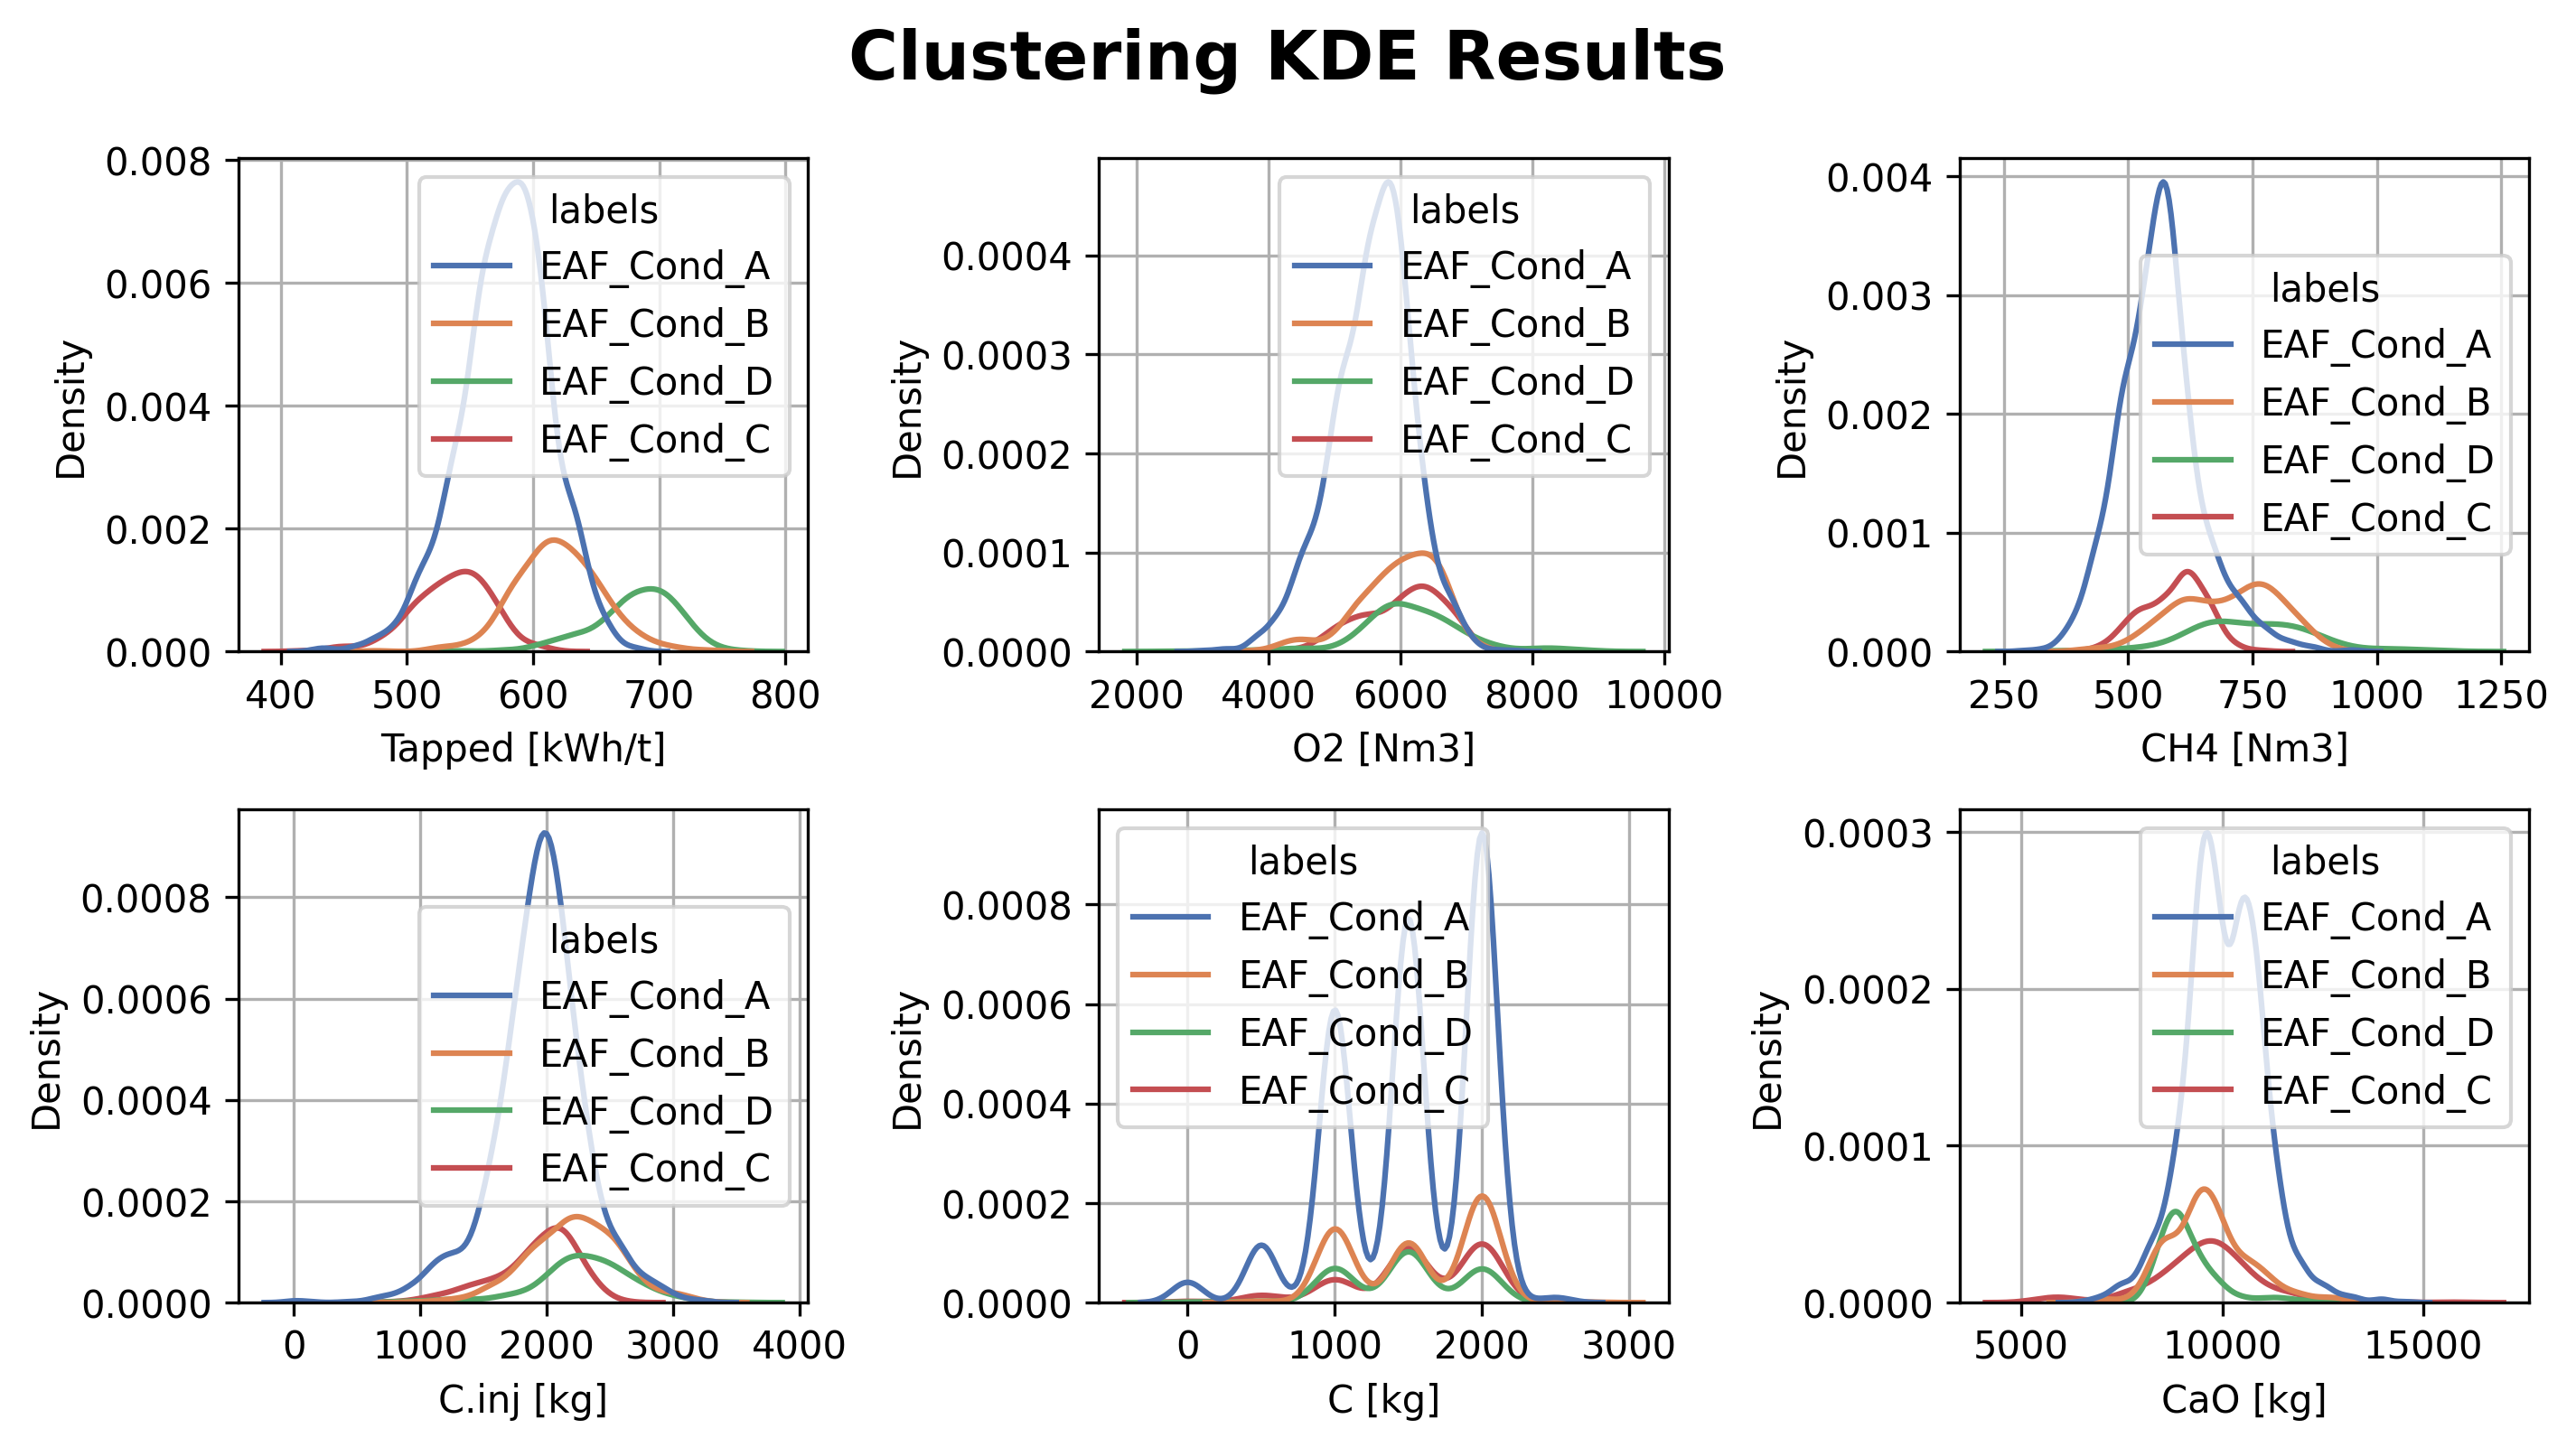

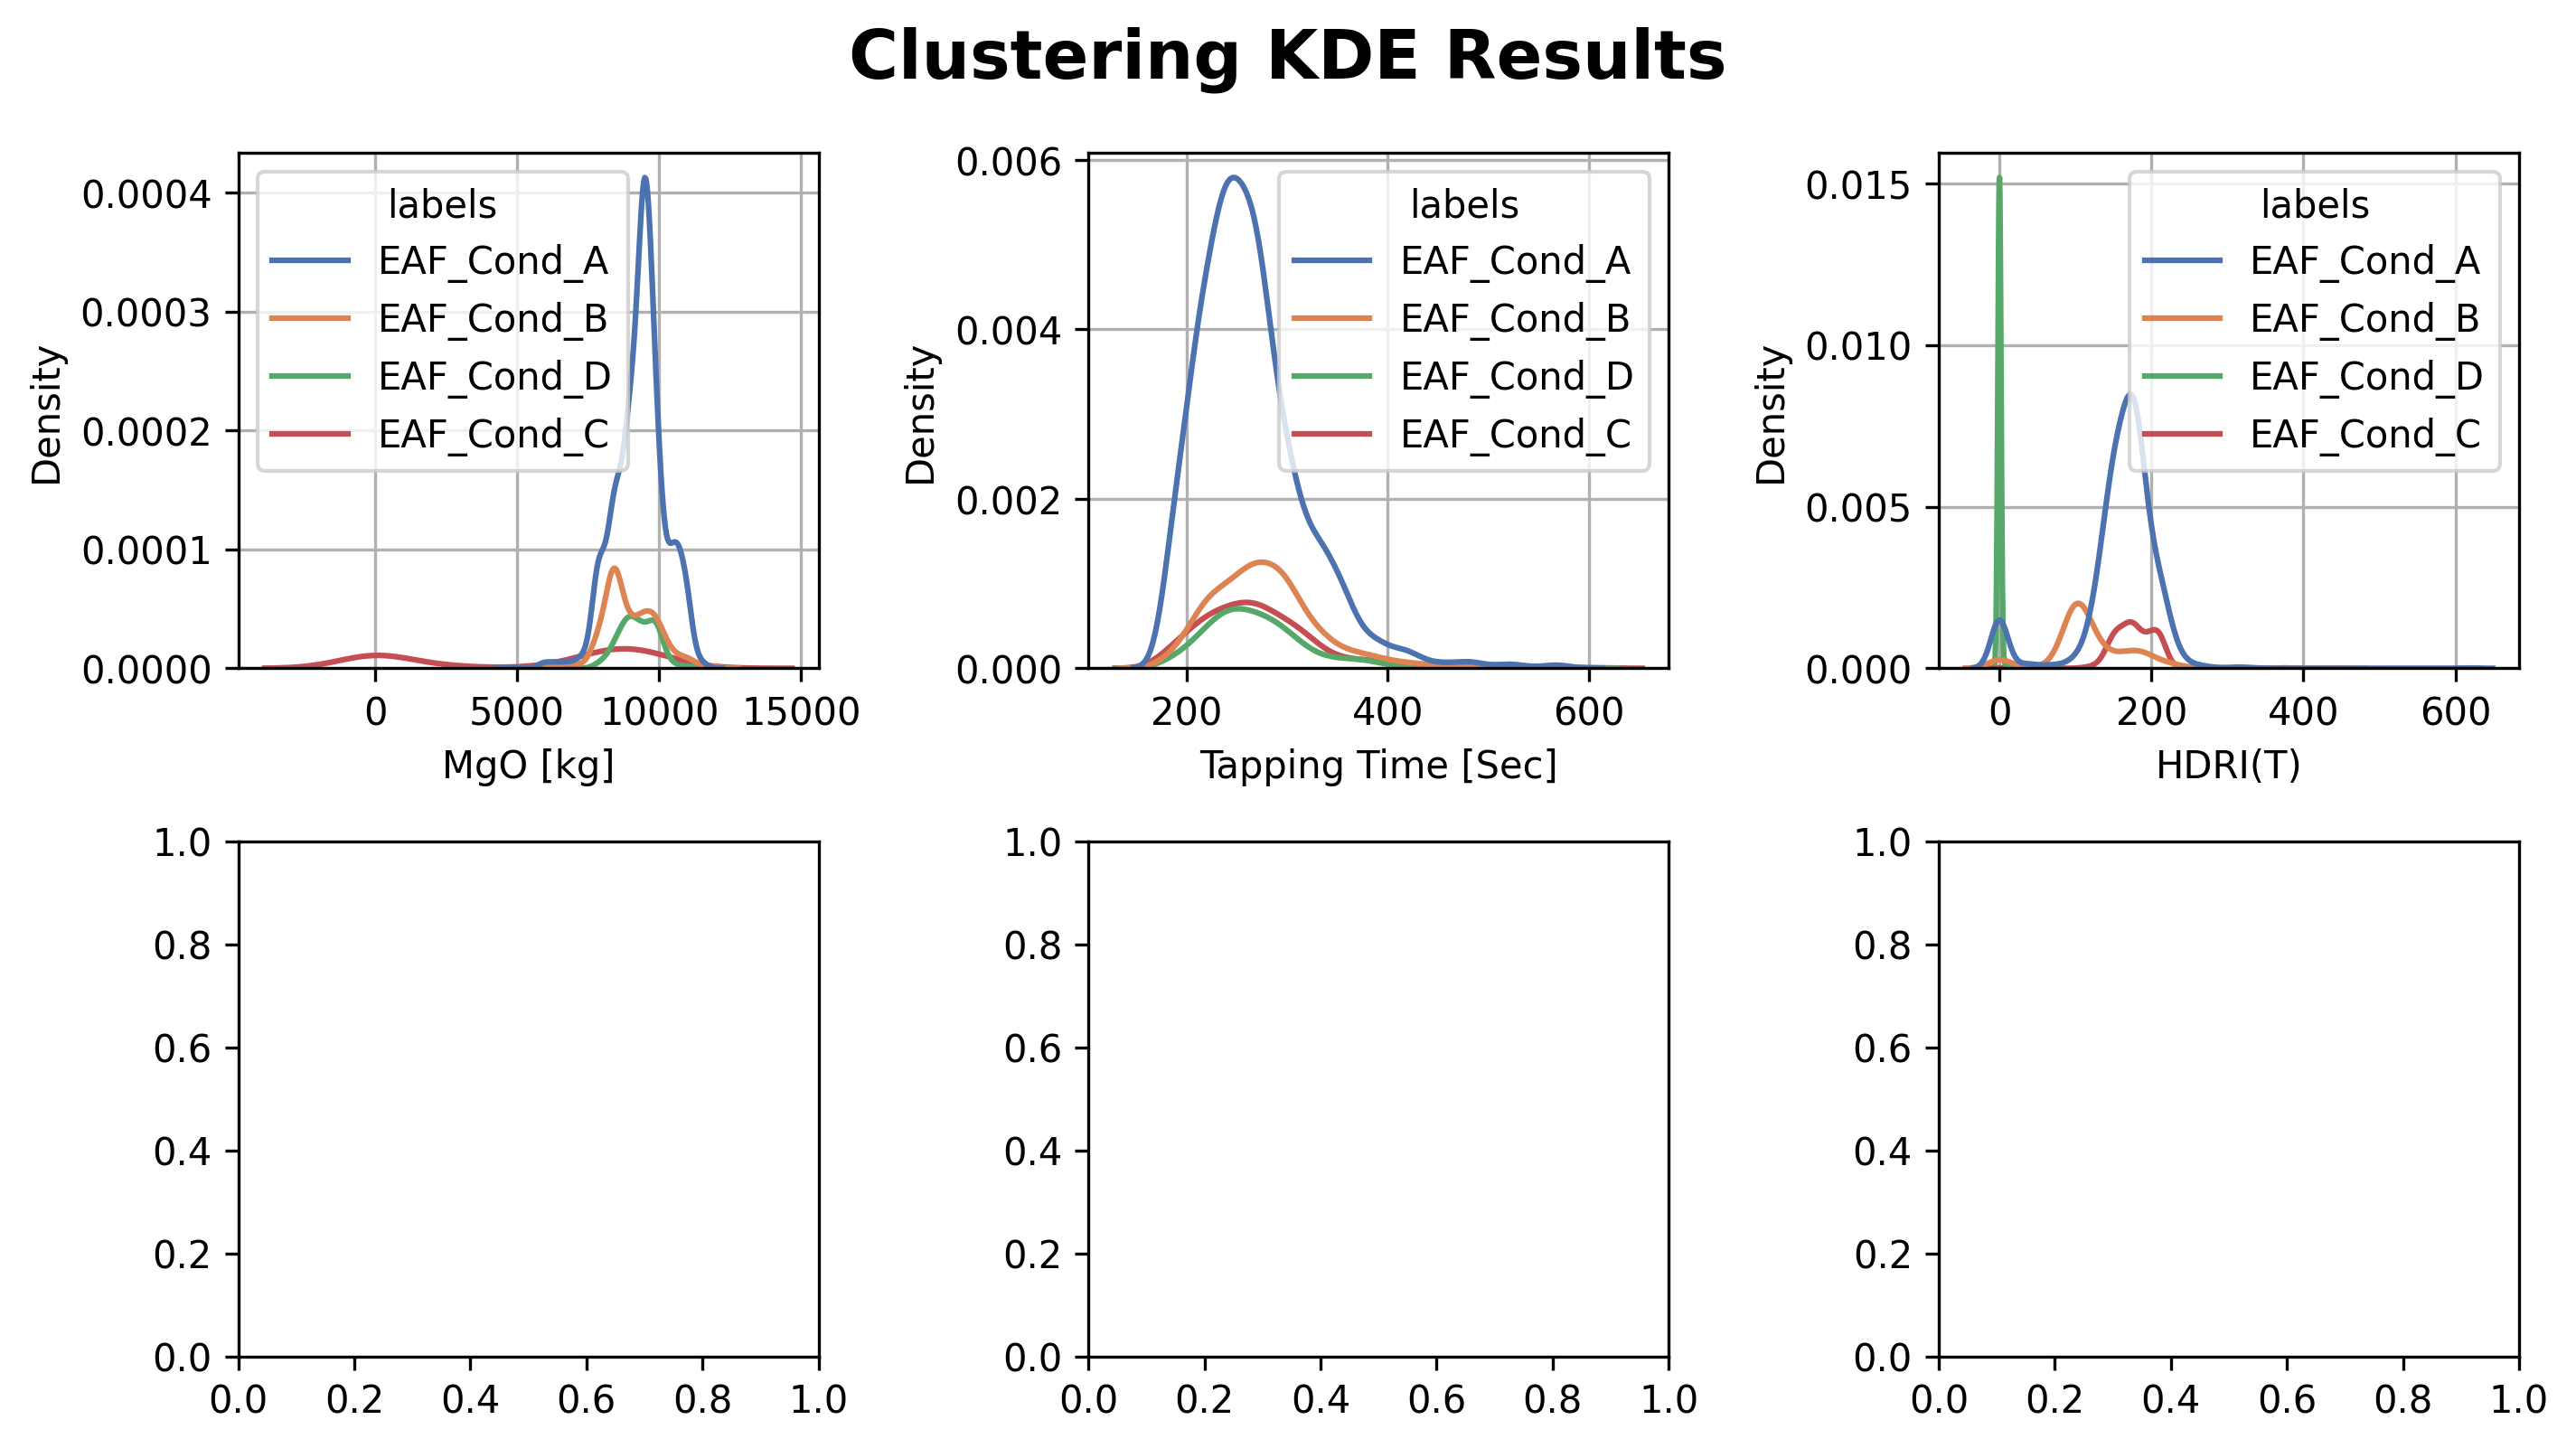

In [15]:
df = pd.read_csv(f"{working_dir}/data/eaf_data.csv")
df.set_index(keys='Heat', inplace=True ,drop=True)
df.drop(labels=['tar'],axis=1,inplace=True)
print(df.shape)
#--------Normalizing-------- 
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
print(normal_df.shape)
#--------Correlation--------
corr_df = normal_df.corr().abs()
corr_df = corr_df.where(np.triu(np.ones(corr_df.shape),k= 1).astype(bool)) #paiine matice motegharen ast ve hazf shod
high_corr_columns_name = pd.DataFrame(corr_df.ge(.95).stack().loc[lambda corr_df: corr_df].index.to_list())
print(high_corr_columns_name)
df.drop(labels=['Delays','EAF_DRI','Chemical [MWh]'] ,axis=1,inplace=True)
#-------Clustering---------
scale = MinMaxScaler()
normal_df = pd.DataFrame(data = scale.fit_transform(df) , columns= df.columns)
t_sne = TSNE(n_components=2, learning_rate='auto',random_state=0,
                  init='random', perplexity=100)
data=t_sne.fit_transform(normal_df)
sne_column_name = [f"SNE{column}"  for column in range(2) ]
sne_df = pd.DataFrame(data=data,columns=sne_column_name)
print(sne_df.shape)
model = AgglomerativeClustering(n_clusters = 4, metric= 'euclidean', linkage ='average')
model.fit(sne_df)
print(model.labels_.shape)
# ---------PLOT-------------
fig = plt.figure(figsize=(9.6,5.4),dpi=300)
fig.suptitle('T-SNE Clusters', fontsize=18,fontweight='bold')
ax1 = fig.subplots(1,1)
ax1.set_xlabel('SNE0', fontsize=16,fontweight='bold')
#ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
cmap = sns.color_palette("deep", as_cmap=True)
sns.scatterplot(
    data=sne_df,
    x='SNE0',
    y='SNE1',
    hue=model.labels_,
    palette= cmap,
    )
fig.tight_layout()
#plt.savefig(f'{working_dir}/presentation/C5000 Amp VS O2 purity.jpg')
plt.show()
#----------Labeling---------
clust_lable_dict = {0:'EAF_Cond_A',1:'EAF_Cond_B',2:'EAF_Cond_C',3:'EAF_Cond_D',4:'EAF_Cond_D',5:'EAF_Cond_E',6:'EAF_Cond_F'}
labels = [clust_lable_dict[i] for i in model.labels_]
df["labels"] = labels
print(df.shape)
#----------Labes Conditions-----
plot_name = df.columns.drop(['labels'])
print(plot_name)
num = 0
for k in range(3):
    fig = plt.figure(num=k,figsize=(9.6,5.4),dpi=300)
    fig.suptitle('Clustering KDE Results', fontsize=18,fontweight='bold')
    ax = fig.subplots(2,3)
    #sns.set_style("ticks",{'axes.grid' : True})
    for i in range(2):
        for j in range(3):
            if num == len(plot_name):
                break
            ax[i][j].grid(True)
            sns.kdeplot(
                data=df,
                x=plot_name[num],
                hue="labels",
                #hue_order=['Slag_Grade_A','Slag_Grade_B','Slag_Grade_C','Slag_Grade_D'],
                fill=False,
                #alpha = 0.4,
                palette= cmap,
                ax=ax[i][j],
            )
            num = num +1
    fig.tight_layout()
plt.show()

# save For next use
#df.to_csv(f"{working_dir}/data/eaf_with_labels.csv",index=True)
del df,normal_df,corr_df,high_corr_columns_name